In [1333]:
##모듈 불러오기

import pandas as pd
import numpy as np
import datetime as dt
import sklearn

import seaborn as sns
# from pycaret.regression import*
import matplotlib.pyplot as plt
# from tqdm.notebook import tqdm

In [1334]:
import os
os.getcwd()

'/Users/admin/PycharmProjects/pythonProject'

In [1335]:
#한글폰트 해결하기

from matplotlib import font_manager, rc

font_path = './malgun.ttf'
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

In [1336]:
#seaborn 한글폰트 해결하기
sns.set(font="AppleGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

In [1337]:
## 데이터 로드 및 변환 및 feature 생성

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
train.info()
test.info()

train['일자'] = pd.to_datetime(train['일자'])
test['일자'] = pd.to_datetime(test['일자'])

train[['현본사소속재택근무자수', '중식계', '석식계']] = train[['현본사소속재택근무자수', '중식계', '석식계']].astype('int')
test['현본사소속재택근무자수'] = test['현본사소속재택근무자수'].astype('int')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   조식메뉴            1205 non-null   object 
 8   중식메뉴            1205 non-null   object 
 9   석식메뉴            1205 non-null   object 
 10  중식계             1205 non-null   float64
 11  석식계             1205 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 113.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일

In [1338]:
# Feature extraction


# train
train['년'] = train['일자'].dt.year
train['월'] = train['일자'].dt.month
train['일'] = train['일자'].dt.day
train['주'] = train['일자'].dt.week
train['요일'] = train['일자'].dt.weekday
train['출근'] = train['본사정원수'] - (train['본사휴가자수'] + train['본사출장자수'] + train['현본사소속재택근무자수'])
train['휴가비율'] = train['본사휴가자수'] / train['본사정원수']
train['출장비율'] = train['본사출장자수'] / train['본사정원수']
train['야근비율'] = train['본사시간외근무명령서승인건수'] / train['출근']
train['재택비율'] = train['현본사소속재택근무자수'] / train['본사정원수']
train['출장휴가재택비율'] = train['출장비율'] + train['휴가비율'] + train['재택비율']

# test
test['년'] = test['일자'].dt.year
test['월'] = test['일자'].dt.month
test['일'] = test['일자'].dt.day
test['주'] = test['일자'].dt.week
test['요일'] = test['일자'].dt.weekday
test['출근'] = test['본사정원수'] - (test['본사휴가자수'] + test['본사출장자수'] + test['현본사소속재택근무자수'])
test['휴가비율'] = test['본사휴가자수'] / test['본사정원수']
test['출장비율'] = test['본사출장자수'] / test['본사정원수']
test['야근비율'] = test['본사시간외근무명령서승인건수'] / test['출근']
test['재택비율'] = test['현본사소속재택근무자수'] / test['본사정원수']
test['출장휴가재택비율'] = test['출장비율'] + test['휴가비율'] + test['재택비율']


/var/folders/ff/ml_0qskx6n1f7vd8y3ns0z900000gp/T/ipykernel_47182/1669224862.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train['주'] = train['일자'].dt.week
/var/folders/ff/ml_0qskx6n1f7vd8y3ns0z900000gp/T/ipykernel_47182/1669224862.py:21: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  test['주'] = test['일자'].dt.week


In [1339]:
# 요일 분포 보기
train['요일'].value_counts()

3    244
4    242
0    240
1    240
2    239
Name: 요일, dtype: int64

In [1340]:
test['요일'].value_counts()

2    11
3    10
4    10
1    10
0     9
Name: 요일, dtype: int64

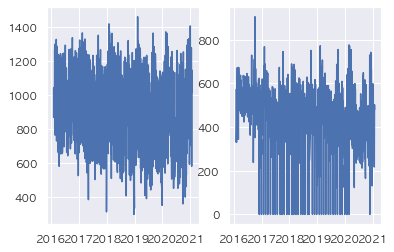

In [1341]:
# 식수인원 plot

plt.subplot(1,2,1)
plt.plot(train['일자'], train['중식계'])

plt.subplot(1,2,2)
plt.plot(train['일자'], train['석식계'])

plt.show()

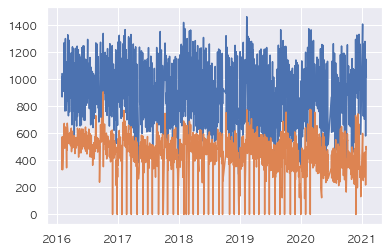

In [1342]:
plt.plot(train['일자'], train['중식계'])
plt.plot(train['일자'], train['석식계'])

plt.show()


## 중식인원과 석식인원 사이에 확연한 차이가 있다는 것을 알 수 있다. 모델을 다르게 설정해야함

In [1343]:
# 외부데이터 가지고 오기

# 기상데이터 가지고 오기(12시에 비 온 데이터 one_hot encoding)(비가 오면 아무래도 사람들이 밖에나가서 밥을 먹기보다는 구내식당에서 밥을 먹을 가능성이 높다는 가정)

rain_train = pd.read_csv("./rain_train.csv")

rain_train['날짜'] = pd.to_datetime(rain_train['일시'])
rain_train['년'] = rain_train['날짜'].dt.year
rain_train['월'] = rain_train['날짜'].dt.month
rain_train['일'] = rain_train['날짜'].dt.day
rain_train['시간'] = rain_train['날짜'].dt.hour

rain_train['TF'] = np.where((rain_train['시간']==12) & (rain_train.iloc[:,3]>=3),1,0)

rain_12 = rain_train[(rain_train['시간']==12)].loc[:, ['년', '월', '일', 'TF']]

train_rain = pd.merge(train, rain_12, on=['년', '월', '일'], how='left')

train_rain.rename(columns={"TF_x":"TF"}, inplace=True)
train = train_rain

# test 데이터 기상데이터 one_hot encoding
rain_test = pd.read_csv("./rain_test.csv")
rain_test
rain_test['날짜'] = pd.to_datetime(rain_test['일시'])
rain_test['년'] = rain_test['날짜'].dt.year
rain_test['월'] = rain_test['날짜'].dt.month
rain_test['일'] = rain_test['날짜'].dt.day
rain_test['시간'] = rain_test['날짜'].dt.hour


rain_test['TF'] = np.where((rain_test['시간']==12) & (rain_test.iloc[:,3]>=3),1,0)

rain_12 = rain_test[(rain_test['시간']==12)].loc[:, ['년', '월', '일', 'TF']]

test_rain = pd.merge(test, rain_12, on=['년', '월', '일'], how='left')

test_rain.rename(columns={"TF_x":"TF"}, inplace=True)
test = test_rain


In [1344]:
train.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계', '년', '월', '일', '주',
       '출근', '휴가비율', '출장비율', '야근비율', '재택비율', '출장휴가재택비율', 'TF'],
      dtype='object')

In [1345]:
rain_test['TF'].sum()

2

In [1346]:
# 외부데이터 가지고 오기

# 온도 데이터 불러오기

temp = pd.read_csv("./highest_temp.csv")
temp['날짜'] = pd.to_datetime(temp['날짜'])
temp['년'] = temp['날짜'].dt.year
temp['월'] = temp['날짜'].dt.month
temp['일'] = temp['날짜'].dt.day

temp_train = temp[['년', '월', '일', '최고기온(℃)']]
temp_train.rename(columns={'최고기온(℃)':'최고기온'}, inplace = True)
train_temp = pd.merge(train, temp_train, on=['년', '월', '일'], how='left')
train = train_temp


temp = pd.read_csv("./highest_temp.csv")
temp['날짜'] = pd.to_datetime(temp['날짜'])
temp['년'] = temp['날짜'].dt.year
temp['월'] = temp['날짜'].dt.month
temp['일'] = temp['날짜'].dt.day

temp_test = temp[['년', '월', '일', '최고기온(℃)']]
temp_test.rename(columns={'최고기온(℃)':'최고기온'}, inplace = True)

test_temp = pd.merge(test, temp_test, on=['년', '월', '일'], how='left')
test = test_temp

/Users/admin/opt/anaconda3/envs/hwankam/lib/python3.9/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [1347]:
# 야근에 대한 정보 추출

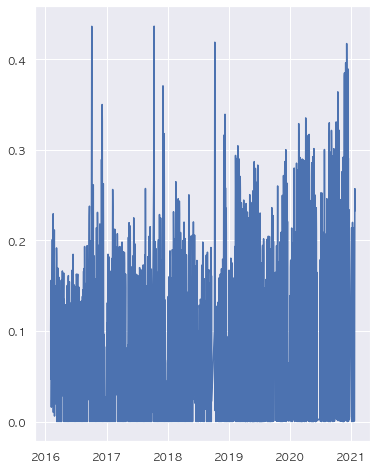

In [1348]:
plt.figure(figsize=(6,8))
plt.plot(train['일자'],train['야근비율'])

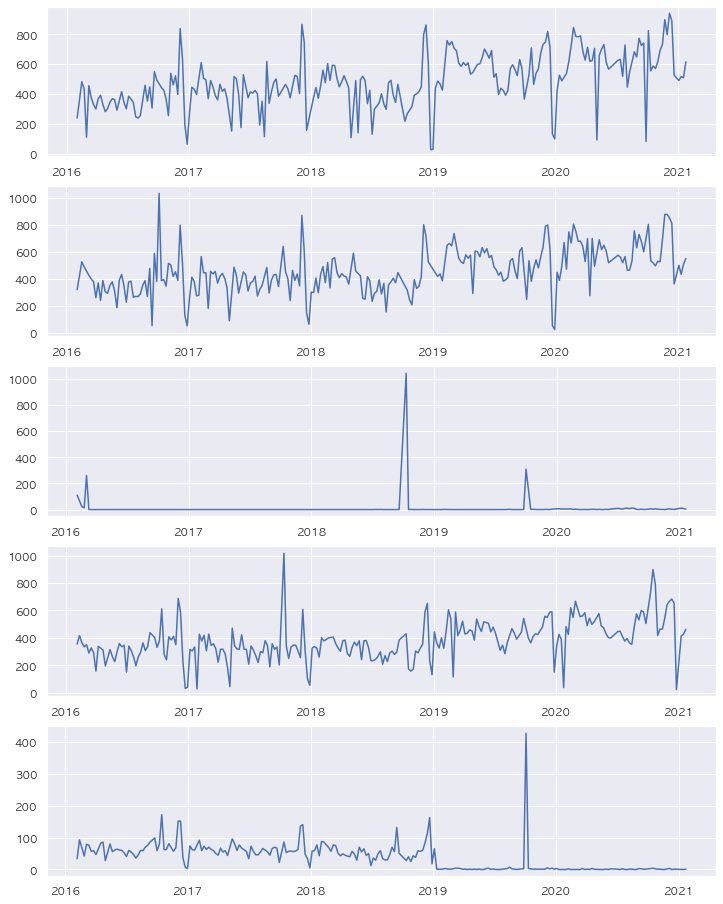

In [1349]:
plt.figure(figsize = (12,16))

train1 = train[train['요일']==0]
plt.subplot(5,1,1)
plt.plot(train1['일자'],train1['본사시간외근무명령서승인건수'])


train1 = train[train['요일']==1]
plt.subplot(5,1,2)
plt.plot(train1['일자'],train1['본사시간외근무명령서승인건수'])


train1 = train[train['요일']==2]
plt.subplot(5,1,3)
plt.plot(train1['일자'],train1['본사시간외근무명령서승인건수'])

train1 = train[train['요일']==3]
plt.subplot(5,1,4)
plt.plot(train1['일자'],train1['본사시간외근무명령서승인건수'])

train1 = train[train['요일']==4]
plt.subplot(5,1,5)
plt.plot(train1['일자'],train1['본사시간외근무명령서승인건수'])
plt.show()

2019년부터 금요일 야근이 확 줄었다.
또한 금요일 그래프에서 아주 극단적인 수치가 나타는데 이를 처리해줘야 할 것.

In [1350]:
# 2019년부터 금요일 야근이 확 줄었다.


train['overwork'] = np.where((train['년'] >= 2019) & (train['요일'] == 4),1,0)
train_overwork = train.loc[:, ['년', '월', '일', 'overwork']]
train_overwork1 = pd.merge(train, train_overwork, on=['년', '월', '일'], how='left')
train_overwork1.rename(columns={"overwork_x":"overwork"}, inplace=True)
train = train_overwork1.iloc[:,0:-1]


test['overwork'] = np.where((test['년'] >= 2019) & (test['요일'] == 4),1,0)
test_overwork = test.loc[:, ['년', '월', '일', 'overwork']]
test_overwork1 = pd.merge(test, test_overwork, on=['년', '월', '일'], how='left')
test_overwork1.rename(columns={"overwork_x":"overwork"}, inplace=True)
test = test_overwork1.iloc[:,0:-1]


In [1351]:
train[(train['요일']==4) & (train['본사시간외근무명령서승인건수']>300)]
# 금요일 300명 이상이 야근 승인을 받은 것은 매우 특이한 케이스이므로 이를 어떻게 처리해야 할지 생각해야 할 것.

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,...,주,출근,휴가비율,출장비율,야근비율,재택비율,출장휴가재택비율,TF,최고기온,overwork
895,2019-10-04,4,3121,268,231,428,0,모닝롤/치즈프레즐 우유/주스 계란후라이 홍게살죽/쌀밥 (쌀:국내산) 황태국 쥐포...,쌀밥/잡곡밥 (쌀:국내산) 해물된장찌개 소불고기 두부양념조림 미역레몬초무침 ...,쌀밥/잡곡밥 (쌀:국내산) 순두부찌개 함박스테이크 계란찜 콩나물무침 포기김치...,...,40,2622,0.08587,0.074015,0.163234,0.0,0.159885,NaN,27.6,1


In [1352]:
# 코로나 상황 고려
# 2020년 02월 27일부로 재택근무가 시작되었다.

train['home'] = np.where((train['일자'] >= "2020-02-26"),1,0)
train_home = train.loc[:, ['년', '월', '일', 'home']]
train_home1 = pd.merge(train, train_home, on=['년', '월', '일'], how='left')
train_home1.rename(columns={'home_x':'home'},inplace=True)
train = train_home1.iloc[:,:-1]

test['home'] = 1

In [1353]:
# 단순 반복 작업 (공휴일 전후, 전전, 후후, 퐁당퐁당 공휴일 변수화하기)

## 공휴일 전/후 데이터 추가 연휴 바로 전 평일 1 / 휴일 다음 날 평일 2 / 휴일 다음다음날3 / 휴일 전전날 4 / 퐁당퐁당 5

train['공휴일전후'] = 0
test['공휴일전후'] = 0
train['공휴일전후'][4] = 1
train['공휴일전후'][5] = 2
train['공휴일전후'][6] = 3
train['공휴일전후'][17] = 5
train['공휴일전후'][18] = 2
train['공휴일전후'][47] = 1
train['공휴일전후'][48] = 2
train['공휴일전후'][62] = 1
train['공휴일전후'][63] = 2
train['공휴일전후'][82] = 1
train['공휴일전후'][83] = 2
train['공휴일전후'][131] = 1
train['공휴일전후'][132] = 2
train['공휴일전후'][151] = 4
train['공휴일전후'][152] = 1
train['공휴일전후'][153] = 2
train['공휴일전후'][162] = 1
train['공휴일전후'][163] = 2
train['공휴일전후'][244] = 4
train['공휴일전후'][245] = 1
train['공휴일전후'][246] = 2
train['공휴일전후'][247] = 3
train['공휴일전후'][266] = 1
train['공휴일전후'][267] = 2
train['공휴일전후'][308] = 4
train['공휴일전후'][309] = 1
train['공휴일전후'][310] = 5
train['공휴일전후'][311] = 5
train['공휴일전후'][312] = 2
train['공휴일전후'][330] = 5
train['공휴일전후'][331] = 2
train['공휴일전후'][379] = 5
train['공휴일전후'][380] = 2
train['공휴일전후'][411] = 4
train['공휴일전후'][412] = 1
train['공휴일전후'][413] = 2
train['공휴일전후'][414] = 3
train['공휴일전후'][466] = 1
train['공휴일전후'][467] = 2
train['공휴일전후'][470] = 1
train['공휴일전후'][471] = 2
train['공휴일전후'][501] = 4
train['공휴일전후'][502] = 1
train['공휴일전후'][503] = 2
train['공휴일전후'][510] = 1
train['공휴일전후'][511] = 5
train['공휴일전후'][555] = 1
train['공휴일전후'][556] = 2
train['공휴일전후'][565] = 5
train['공휴일전후'][566] = 2
train['공휴일전후'][575] = 1
train['공휴일전후'][576] = 2
train['공휴일전후'][579] = 1
train['공휴일전후'][580] = 2
train['공휴일전후'][623] = 1
train['공휴일전후'][624] = 2
train['공휴일전후'][650] = 1
train['공휴일전후'][651] = 5
train['공휴일전후'][652] = 2
train['공휴일전후'][653] = 3
train['공휴일전후'][705] = 5
train['공휴일전후'][706] = 2
train['공휴일전후'][709] = 5
train['공휴일전후'][710] = 2
train['공휴일전후'][732] = 1
train['공휴일전후'][733] = 2
train['공휴일전후'][734] = 1
train['공휴일전후'][748] = 1
train['공휴일전후'][749] = 2
train['공휴일전후'][791] = 2
train['공휴일전후'][792] = 1
train['공휴일전후'][793] = 2
train['공휴일전후'][814] = 4
train['공휴일전후'][815] = 5
train['공휴일전후'][862] = 4
train['공휴일전후'][864] = 5
train['공휴일전후'][881] = 4
train['공휴일전후'][882] = 1
train['공휴일전후'][883] = 2
train['공휴일전후'][897] = 1

train['공휴일전후'][950] = 4
train['공휴일전후'][951] = 1
train['공휴일전후'][952] = 2
train['공휴일전후'][955] = 1
train['공휴일전후'][956] = 2
train['공휴일전후'][970] = 4
train['공휴일전후'][971] = 1
train['공휴일전후'][972] = 2
train['공휴일전후'][973] = 3
train['공휴일전후'][1027] = 1
train['공휴일전후'][1028] = 2
train['공휴일전후'][1036] = 4
train['공휴일전후'][1037] = 1
train['공휴일전후'][1038] = 5
train['공휴일전후'][1039] = 2
train['공휴일전후'][1099] = 1
train['공휴일전후'][1100] = 2
train['공휴일전후'][1029] = 1
train['공휴일전후'][1030] = 2
train['공휴일전후'][1129] = 4
train['공휴일전후'][1133] = 1
train['공휴일전후'][1134] = 2
train['공휴일전후'][1186] = 4
train['공휴일전후'][1187] = 1
train['공휴일전후'][1188] = 2
test['공휴일전후'][9] = 4
test['공휴일전후'][10] = 1
test['공휴일전후'][11] = 2
test['공휴일전후'][20] = 1
test['공휴일전후'][21] = 2


/var/folders/ff/ml_0qskx6n1f7vd8y3ns0z900000gp/T/ipykernel_47182/1211078889.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['공휴일전후'][4] = 1
/var/folders/ff/ml_0qskx6n1f7vd8y3ns0z900000gp/T/ipykernel_47182/1211078889.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['공휴일전후'][5] = 2
/var/folders/ff/ml_0qskx6n1f7vd8y3ns0z900000gp/T/ipykernel_47182/1211078889.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['공휴일전

In [1354]:
train['공휴일전후'].unique()

array([0, 1, 2, 3, 5, 4])

In [1355]:
a = train[train['공휴일전후']==0].loc[:,'중식계'].mean()
b = train[train['공휴일전후']==1].loc[:,'중식계'].mean()
c = train[train['공휴일전후']==2].loc[:,'중식계'].mean()
d = train[train['공휴일전후']==3].loc[:,'중식계'].mean()
e = train[train['공휴일전후']==4].loc[:,'중식계'].mean()
f = train[train['공휴일전후']==5].loc[:,'중식계'].mean()

In [1356]:
print( f'휴일을 공휴하지 않는 날의 중식계 평균은 {a} 이고 연휴 전날의 중식계 평균은 {b}, 연휴 다음날은 {c}, 연휴 다음다음날은 {d}, 연휴 전전날은 {e}, 퐁당퐁당인 날은 {f}') 

휴일을 공휴하지 않는 날의 중식계 평균은 892.1845454545454 이고 연휴 전날의 중식계 평균은 746.1428571428571, 연휴 다음날은 1092.2564102564102, 연휴 다음다음날은 1137.2, 연휴 전전날은 740.1538461538462, 퐁당퐁당인 날은 571.4615384615385


즉, 연휴 전날에는 휴가를 쓰는 직원들이 많고 이에 따라 식수 인원이 줄어드는 경우가 많다. 반대로 연휴가 끝나고 난 직후에는 직원들이 중식당을 평균적으로 많이 찾는다. 특히 퐁당으로 휴일과 휴일 사이에 평일이 하루 끼어있는 경우에는 중식계 평균인원이 급격하게 줄어드는 양상을 보인다.

In [1357]:
# 코로나로 인해 경각심을 가지는 시기 (20년 2말 / 20년 8말 / 20년 12월 1월초) #코로나 확진자 수가 급증하며 확진자수에 대한 대중의 관심이 커지는 시점
# mask_covid = (((train['년'] == 2020) & (train['월']==2) & (train['일'] >= 24)) |  ((train['년'] == 2020) & (train['월']==3) & (train['일'] <= 10)) | ((train['년'] == 2020) & (train['월']==8) & (train['일'] >= 24)) |  ((train['년'] == 2020) & (train['월']==9) & (train['일'] <= 10)) | ((train['년'] == 2020) & (train['월']==11) & (train['일'] >= 23)) |  ((train['년'] == 2020) & (train['월']==12) & (train['일'] <= 23))) | ((train['년'] == 2021) & (train['월']==1) & (train['일'] >=4))

mask_covid = (((train['년'] == 2020) & (train['월'] == 2) & (train['일'] >= 24)) | (
            (train['년'] == 2020) & (train['월'] == 3) & (train['일'] <= 10)) | (
                          (train['년'] == 2020) & (train['월'] == 8) & (train['일'] >= 24)) | (
                          (train['년'] == 2020) & (train['월'] == 9) & (train['일'] <= 10)) | (
                          (train['년'] == 2020) & (train['월'] == 11) & (train['일'] >= 19)) | (
                          (train['년'] == 2020) & (train['월'] == 12) & (train['일'] <= 24))) | (
                         (train['년'] == 2021) & (train['월'] == 1) & (train['일'] >= 4))

train_covid = train[mask_covid]
train_covid
train_covid['covid'] = 1
train_covid = train_covid.loc[:, ['년', '월', '일', 'covid']]
train_covid1 = pd.merge(train, train_covid, left_on=['년', '월', '일'], right_on=['년', '월', '일'], how='outer')
train_covid1.dropna(subset=['요일'], axis=0, inplace=True)
train_covid1['covid'].replace(np.nan, 0, inplace=True)
train = train_covid1
train

test.columns

mask_covid_t = (((test['년'] == 2021) & (test['월'] == 1) & (test['일'] >= 27)) & (
            (test['년'] == 2021) & (test['월'] == 1) & (test['일'] <= 29))) | (
                           ((test['년'] == 2021) & (test['월'] == 2) & (test['일'] >= 15)) & (
                               (test['년'] == 2021) & (test['월'] == 2) & (test['일'] <= 23))) | (
                           ((test['년'] == 2021) & (test['월'] == 4) & (test['일'] >= 6)) & (
                               (test['년'] == 2021) & (test['월'] == 4) & (test['일'] <= 9)))

test_covid = test[mask_covid_t]
test_covid
test_covid['covid'] = 1
test_covid = test_covid.loc[:, ['년', '월', '일', 'covid']]
test_covid1 = pd.merge(test, test_covid, left_on=['년', '월', '일'], right_on=['년', '월', '일'], how='outer')
test_covid1.dropna(subset=['요일'], axis=0, inplace=True)
test_covid1['covid'].replace(np.nan, 0, inplace=True)
test = test_covid1
test


/var/folders/ff/ml_0qskx6n1f7vd8y3ns0z900000gp/T/ipykernel_47182/3681388353.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_covid['covid'] = 1
/var/folders/ff/ml_0qskx6n1f7vd8y3ns0z900000gp/T/ipykernel_47182/3681388353.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_covid['covid'] = 1


,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,...,출장비율,야근비율,재택비율,출장휴가재택비율,TF,최고기온,overwork,home,공휴일전후,covid
0,2021-01-27,2,2983,88,182,5,358,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,...,0.061012,0.002123,0.120013,0.210526,NaN,11.4,0,1,0,1.0
1,2021-01-28,3,2983,104,212,409,348,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지,...,0.071069,0.176369,0.116661,0.222595,NaN,10.7,0,1,0,1.0
2,2021-01-29,4,2983,270,249,0,294,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치,...,0.083473,0.000000,0.098558,0.272544,NaN,3.0,1,1,0,1.0
3,2021-02-01,0,2924,108,154,538,322,모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치,...,0.052668,0.229915,0.110123,0.199726,NaN,10.6,0,1,0,0.0
4,2021-02-02,1,2924,62,186,455,314,모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치,...,0.063611,0.192633,0.107387,0.192202,NaN,7.5,0,1,0,0.0
5,2021-02-03,2,2924,59,199,5,286,모닝롤/게살모닝샌드 우유/주스 계란후라이/찐계란 소고기죽/흑미밥 시래기된장국 베이컨...,쌀밥/흑미밥/찰현미밥 아욱국 매콤해물볶음 감자조림 미나리나물 포기김치 콥샐러드*렌치D,오므라이스 가쓰오장국 빌소세지구이*구운채소 단감치커리무침 양념고추지 겉절이김치,...,0.068057,0.002101,0.097811,0.186047,NaN,5.1,0,1,0,0.0
6,2021-02-04,3,2924,61,211,476,288,모닝롤/사과파이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 아욱국 새송이버섯곤약장...,쌀밥/차조밥/찰현미밥 설렁탕 고등어김치말이찜 볼어묵굴소스볶음 브로콜리숙회*초장 석박...,흑미밥 계란파국 돈육두루치기 감자채파프리카볶음 세발나물오리엔탈무침 포기김치,...,0.072161,0.201354,0.098495,0.191518,NaN,10.0,0,1,0,0.0
7,2021-02-05,4,2924,169,252,0,256,모닝롤/앙버터모닝빵 우유/주스 계란후라이/찐계란 고구마죽/흑미밥 옹심이국 머위나물무...,쌀밥/흑미밥/찰현미밥 북엇국 닭볶음탕 채소전*장 솎음열무나물무침 포기김치 양상추샐러...,유부초밥/추가밥 온메밀소바 국물떡볶이 순대찜*소금 청경채겉절이 포기김치,...,0.086183,0.000000,0.087551,0.231532,NaN,8.0,1,1,0,0.0
8,2021-02-08,0,2924,88,174,690,329,모닝롤/스콘 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 꽃게탕 근대나물무침 연두부...,쌀밥/흑미밥/찰현미밥 감자양파국 돈수육*씨앗쌈장 매콤어묵볶음 콩나물파채무침 포기김치...,흑미밥 냉이국 반반치킨 꼬막채소무침 청경채찜 포기김치,...,0.059508,0.295757,0.112517,0.202120,NaN,6.6,0,1,0,0.0
9,2021-02-09,1,2924,94,183,542,329,모닝롤/치즈팡샌드 우유/주스 계란후라이/찐계란 팥죽/흑미밥 맑은버섯국 시금치나물무침...,쌀밥/기장밥/찰현미밥 장각백숙 적어양념장구이 채소스틱*쌈장 도라지오이초무침 겉절이김...,흑미밥 미역국 매운소불고기 단호박두부탕수 메추리알장조림 석박지,...,0.062585,0.233822,0.112517,0.207250,NaN,9.1,0,1,4,0.0


In [1358]:
# 과거 매달 마지막 주 수요일 문화의 날 행사 원핫인코딩 / test 데이터에서는 자기계발의 날이 없는것으로 보아 현재는 시행 안하는듯.

train['culture'] = np.where(train['석식계'] == 0,1,0)
train_culture = train.loc[:, ['년', '월', '일', 'culture']]
train_culture1 = pd.merge(train, train_culture, on=['년', '월', '일'], how='left')
train_culture1.rename(columns={'culture_x':'culture'},inplace=True)
train = train_culture1.iloc[:,:-1]


test['culture'] = 0

In [1359]:
# 연말연초에는 약속이 많다

mask_alcho = ((train['년'] == 2016) & (train['월'] == 12) & (train['일'] >= 22)) & (
            (train['년'] == 2016) & (train['월'] == 12) & (train['일'] <= 31)) | (
                         (train['년'] == 2017) & (train['월'] == 12) & (train['일'] >= 22)) & (
                         (train['년'] == 2017) & (train['월'] == 12) & (train['일'] <= 31)) | (
                         (train['년'] == 2018) & (train['월'] == 12) & (train['일'] >= 20)) & (
                         (train['년'] == 2018) & (train['월'] == 12) & (train['일'] <= 31)) | (
                         (train['년'] == 2019) & (train['월'] == 12) & (train['일'] >= 20)) & (
                         (train['년'] == 2019) & (train['월'] == 12) & (train['일'] <= 31)) | (
                         (train['년'] == 2020) & (train['월'] == 12) & (train['일'] >= 22)) & (
                         (train['년'] == 2020) & (train['월'] == 12) & (train['일'] <= 31))

train_alcho = train[mask_alcho]
train_alcho['일자']
train_alcho['alcho'] = 1
train_alcho = train_alcho.loc[:, ['년', '월', '일', 'alcho']]
train_alcho1 = pd.merge(train, train_alcho, left_on=['년', '월', '일'], right_on=['년', '월', '일'], how='outer')
train_alcho1.dropna(subset=['요일'], axis=0, inplace=True)
train_alcho1['alcho'].replace(np.nan, 0, inplace=True)
train = train_alcho1
train

test['alcho'] = 0


/var/folders/ff/ml_0qskx6n1f7vd8y3ns0z900000gp/T/ipykernel_47182/1067509767.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_alcho['alcho'] = 1


In [1360]:
train.shape

(1205, 30)

In [1361]:
# 서울시 코로나 확진자 데이터 가져오기

covid = pd.read_csv("./covid.csv")
covid['확진일'] = pd.to_datetime(covid['확진일'])

covid['확진자수'] = 1
covid = covid[['확진일', '확진자수']]
covid1 = covid.groupby(['확진일']).sum()
covid1.reset_index(inplace=True)

datee = pd.date_range('2016-02-01', '2021-04-09')
datee = pd.DataFrame(datee)
datee.rename(columns={0:'날짜'},inplace=True)
covid2 = pd.merge(datee, covid1, left_on=['날짜'],right_on=['확진일'], how='left')



covid3 = covid2[covid2['날짜'].notnull()]
covid3['날짜'] = pd.to_datetime(covid3['날짜'])
covid3['년'] = covid3['날짜'].dt.year
covid3['월'] = covid3['날짜'].dt.month
covid3['일'] = covid3['날짜'].dt.day
covid3 = covid3[['년','월','일', '확진자수']]
covid3['확진자수'].replace(np.nan, 0, inplace=True)

train = pd.merge(train, covid3, on=['년', '월', '일'], how='left')
train.rename(columns={'확진자수_x':'확진자수'},inplace=True)

test = pd.merge(test, covid3, left_on=['년', '월', '일'], right_on=['년', '월', '일'], how='left')
test.rename(columns={'확진자수_x':'확진자수'},inplace=True)


/

데이터 transformation 및 스케일링

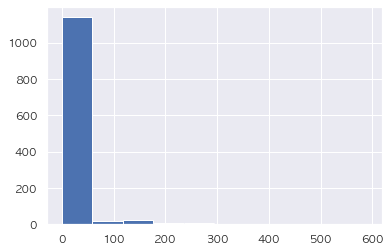

In [1362]:
plt.hist(train['확진자수'])
plt.show()

왜도가 크기 때문에, 확진자수 데이터에 대한 로그변환이 필요할듯.

In [1363]:
#확진자수 로그변환

train['확진자수_log'] = np.log1p(train['확진자수'])
test['확진자수_log'] = np.log1p(test['확진자수'])

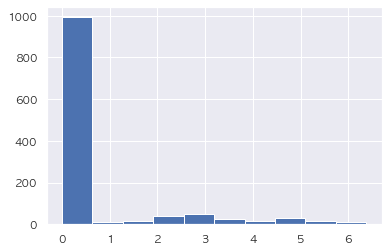

In [1364]:
plt.hist(train['확진자수_log'])
plt.show()

In [1365]:
# 서울시 확진자수 minmaxscaler

minmax = StandardScaler()
total = np.array(train['확진자수_log'])
total = total.reshape(-1, 1)
minmax.fit(total)
total = minmax.transform(total)
total = pd.DataFrame(total, columns=['확진자수_log_scale'])
train = pd.merge(train, total, left_index=True, right_index=True, how='left')

total_test = np.array(test['확진자수_log'])
total_test = total_test.reshape(-1, 1)
total_test = minmax.transform(total_test)
total_test = pd.DataFrame(total_test, columns=['확진자수_log_scale'])
test = pd.merge(test, total_test, left_index=True, right_index=True, how='left')

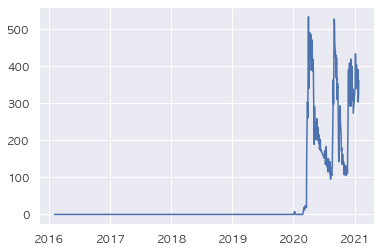

In [1366]:
plt.plot(train['일자'], train['현본사소속재택근무자수'])
plt.show()

In [1367]:
# 현본사소속재택근무자수 minmax scale 하기 (0의 값이 매우 많기 때문에 standardscaler보다는 minmaxscaler를 쓰는게 낫다)

from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
total = np.array(train['현본사소속재택근무자수'])
total = total.reshape(-1, 1)
minmax.fit(total)
total = minmax.transform(total)
total = pd.DataFrame(total, columns=['현본사소속재택근무자수_scale'])
train = pd.merge(train, total, left_index=True, right_index=True, how='left')

total_test = np.array(test['현본사소속재택근무자수'])
total_test = total_test.reshape(-1, 1)
total_test = minmax.transform(total_test)
total_test = pd.DataFrame(total_test, columns=['현본사소속재택근무자수_scale'])
test = pd.merge(test, total_test, left_index=True, right_index=True, how='left')


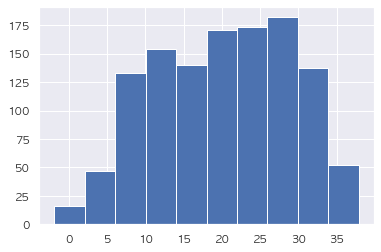

In [1368]:
plt.hist(train['최고기온'])
plt.show()

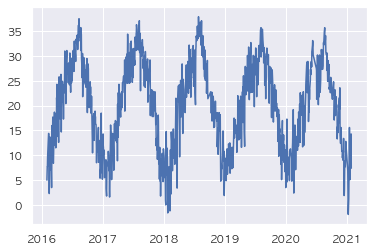

In [1369]:
plt.plot(train['일자'],train['최고기온'])
plt.show()

In [1370]:
# 전주시 최고기온 standardscaler(이상치가 그리 크지 않기 때문에 정규화시킴)

from sklearn.preprocessing import StandardScaler

minmax = StandardScaler()
total = np.array(train['최고기온'])
total = total.reshape(-1, 1)
minmax.fit(total)
total = minmax.transform(total)
total = pd.DataFrame(total, columns=['최고기온_scale'])
train = pd.merge(train, total, left_index=True, right_index=True, how='left')

total_test = np.array(test['최고기온'])
total_test = total_test.reshape(-1, 1)
total_test = minmax.transform(total_test)
total_test = pd.DataFrame(total_test, columns=['최고기온_scale'])
test = pd.merge(test, total_test, left_index=True, right_index=True, how='left')
test

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,...,home,공휴일전후,covid,culture,alcho,확진자수,확진자수_log,확진자수_log_scale,현본사소속재택근무자수_scale,최고기온_scale
0,2021-01-27,2,2983,88,182,5,358,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,...,1,0,1.0,0,0,104.0,4.653960,2.895345,0.671670,-0.981024
1,2021-01-28,3,2983,104,212,409,348,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지,...,1,0,1.0,0,0,113.0,4.736198,2.953965,0.652908,-1.059767
2,2021-01-29,4,2983,270,249,0,294,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치,...,1,0,1.0,0,0,152.0,5.030438,3.163703,0.551595,-1.925948
3,2021-02-01,0,2924,108,154,538,322,모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치,...,1,0,0.0,0,0,126.0,4.844187,3.030941,0.604128,-1.071016
4,2021-02-02,1,2924,62,186,455,314,모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치,...,1,0,0.0,0,0,190.0,5.252273,3.321831,0.589118,-1.419738
5,2021-02-03,2,2924,59,199,5,286,모닝롤/게살모닝샌드 우유/주스 계란후라이/찐계란 소고기죽/흑미밥 시래기된장국 베이컨...,쌀밥/흑미밥/찰현미밥 아욱국 매콤해물볶음 감자조림 미나리나물 포기김치 콥샐러드*렌치D,오므라이스 가쓰오장국 빌소세지구이*구운채소 단감치커리무침 양념고추지 겉절이김치,...,1,0,0.0,0,0,170.0,5.141664,3.242987,0.536585,-1.689717
6,2021-02-04,3,2924,61,211,476,288,모닝롤/사과파이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 아욱국 새송이버섯곤약장...,쌀밥/차조밥/찰현미밥 설렁탕 고등어김치말이찜 볼어묵굴소스볶음 브로콜리숙회*초장 석박...,흑미밥 계란파국 돈육두루치기 감자채파프리카볶음 세발나물오리엔탈무침 포기김치,...,1,0,0.0,0,0,125.0,4.836282,3.025306,0.540338,-1.138511
7,2021-02-05,4,2924,169,252,0,256,모닝롤/앙버터모닝빵 우유/주스 계란후라이/찐계란 고구마죽/흑미밥 옹심이국 머위나물무...,쌀밥/흑미밥/찰현미밥 북엇국 닭볶음탕 채소전*장 솎음열무나물무침 포기김치 양상추샐러...,유부초밥/추가밥 온메밀소바 국물떡볶이 순대찜*소금 청경채겉절이 포기김치,...,1,0,0.0,0,0,145.0,4.983607,3.130321,0.480300,-1.363493
8,2021-02-08,0,2924,88,174,690,329,모닝롤/스콘 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 꽃게탕 근대나물무침 연두부...,쌀밥/흑미밥/찰현미밥 감자양파국 돈수육*씨앗쌈장 매콤어묵볶음 콩나물파채무침 포기김치...,흑미밥 냉이국 반반치킨 꼬막채소무침 청경채찜 포기김치,...,1,0,0.0,0,0,91.0,4.521789,2.801130,0.617261,-1.520980
9,2021-02-09,1,2924,94,183,542,329,모닝롤/치즈팡샌드 우유/주스 계란후라이/찐계란 팥죽/흑미밥 맑은버섯국 시금치나물무침...,쌀밥/기장밥/찰현미밥 장각백숙 적어양념장구이 채소스틱*쌈장 도라지오이초무침 겉절이김...,흑미밥 미역국 매운소불고기 단호박두부탕수 메추리알장조림 석박지,...,1,4,0.0,0,0,175.0,5.170484,3.263530,0.617261,-1.239753


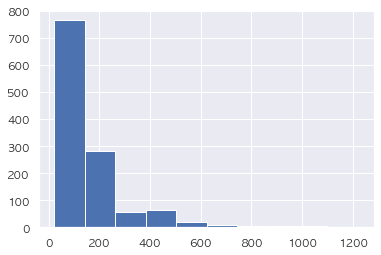

In [1371]:
plt.hist(train['본사휴가자수'])
plt.show()

In [1372]:
train['본사휴가자수_log'] = np.log1p(train['본사휴가자수'])
test['본사휴가자수_log'] = np.log1p(test['본사휴가자수'])

In [1373]:
# 본사 정원수 minmax scale 하기
from sklearn.preprocessing import StandardScaler

minmax = StandardScaler()
total = np.array(train['출근'])
total = total.reshape(-1, 1)
minmax.fit(total)
total = minmax.transform(total)
total = pd.DataFrame(total, columns=['출근_scale'])
train = pd.merge(train, total, left_index=True, right_index=True, how='left')
train.rename(columns={"출근_scale_x":"출근"}, inplace = True)

total_test = np.array(test['출근'])
total_test = total_test.reshape(-1, 1)
total_test = minmax.transform(total_test)
total_test = pd.DataFrame(total_test, columns=['출근_scale'])
test = pd.merge(test, total_test, left_index=True, right_index=True, how='left')
test.rename(columns={"출근_scale_x":"출근"}, inplace = True)


# 본사 휴가자수 minmax scale 하기
from sklearn.preprocessing import StandardScaler

minmax = StandardScaler()
total = np.array(train['본사휴가자수_log'])
total = total.reshape(-1, 1)
minmax.fit(total)
total = minmax.transform(total)
total = pd.DataFrame(total, columns=['본사휴가자수_log_scale'])
train = pd.merge(train, total, left_index=True, right_index=True, how='left')
train.rename(columns={"본사휴가자수_log_scale_x":"본사휴가자수_log_scale"}, inplace = True)

total_test = np.array(test['본사휴가자수_log'])
total_test = total_test.reshape(-1, 1)
total_test = minmax.transform(total_test)
total_test = pd.DataFrame(total_test, columns=['본사휴가자수_log_scale'])
test = pd.merge(test, total_test, left_index=True, right_index=True, how='left')
test.rename(columns={"본사휴가자수_log_scale_x":"본사휴가자수_log_scale"}, inplace = True)

# 본사출장자수 minmax scale 하기
from sklearn.preprocessing import StandardScaler

minmax = StandardScaler()
total = np.array(train['본사출장자수'])
total = total.reshape(-1, 1)
minmax.fit(total)
total = minmax.transform(total)
total = pd.DataFrame(total, columns=['본사출장자수_scale'])
train = pd.merge(train, total, left_index=True, right_index=True, how='left')
train.rename(columns={"본사출장자수_scale_x":"본사출장자수_scale"}, inplace = True)

total_test = np.array(test['본사출장자수'])
total_test = total_test.reshape(-1, 1)
total_test = minmax.transform(total_test)
total_test = pd.DataFrame(total_test, columns=['본사출장자수_scale'])
test = pd.merge(test, total_test, left_index=True, right_index=True, how='left')
test.rename(columns={"본사출장자수_scale_x":"본사출장자수_scale"}, inplace = True)

# 본사시간외근무명령서승인건수 minmax scale 하기
from sklearn.preprocessing import StandardScaler

minmax = StandardScaler()
total = np.array(train['본사시간외근무명령서승인건수'])
total = total.reshape(-1, 1)
minmax.fit(total)
total = minmax.transform(total)
total = pd.DataFrame(total, columns=['본사시간외근무명령서승인건수_scale'])
train = pd.merge(train, total, left_index=True, right_index=True, how='left')
train.rename(columns={"본사시간외근무명령서승인건수_scale_x":"본사시간외근무명령서승인건수_scale"}, inplace = True)

total_test = np.array(test['본사시간외근무명령서승인건수'])
total_test = total_test.reshape(-1, 1)
total_test = minmax.transform(total_test)
total_test = pd.DataFrame(total_test, columns=['본사시간외근무명령서승인건수_scale'])
test = pd.merge(test, total_test, left_index=True, right_index=True, how='left')
test.rename(columns={"본사시간외근무명령서승인건수_scale_x":"본사시간외근무명령서승인건수_scale"}, inplace = True)



In [1374]:
# corr 파일에서 본 상관계수가 높은 변수 만들어내기

train['휴가ls2시간외s'] = (train['본사휴가자수_log_scale'] ** 2) * (train['본사시간외근무명령서승인건수_scale'])
train['최고기온s2시간외s'] = (train['최고기온_scale'] ** 2) * (train['본사시간외근무명령서승인건수_scale'])
train['시간외s3'] = (train['본사시간외근무명령서승인건수_scale']) ** 3
train['출장자수s2시간외s'] = (train['본사출장자수_scale'] ** 2) * (train['본사시간외근무명령서승인건수_scale'])
train['출근s2시간외s'] = (train['출근_scale'] ** 2) * (train['본사시간외근무명령서승인건수_scale'])

test['휴가ls2시간외s'] = (test['본사휴가자수_log_scale'] ** 2) * (test['본사시간외근무명령서승인건수_scale'])
test['최고기온s2시간외s'] = (test['최고기온_scale'] ** 2) * (test['본사시간외근무명령서승인건수_scale'])
test['시간외s3'] = (test['본사시간외근무명령서승인건수_scale']) ** 3
test['출장자수s2시간외s'] = (test['본사출장자수_scale'] ** 2) * (test['본사시간외근무명령서승인건수_scale'])
test['출근s2시간외s'] = (test['출근_scale'] ** 2) * (test['본사시간외근무명령서승인건수_scale'])


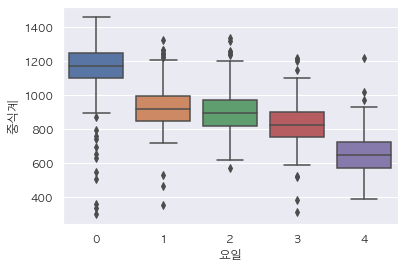

In [1375]:
sns.boxplot(x='요일', y='중식계', data=train)
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7fcd13bab100>,
 'caps': [<matplotlib.lines.Line2D at 0x7fcd13babfd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fcd13bab5e0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fcd13ba12e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fcd13ba1df0>],
 'means': []}

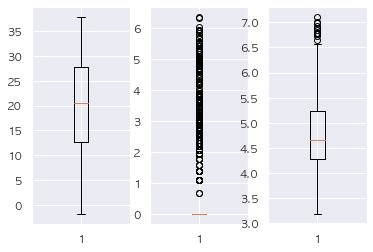

In [1376]:
# 이상치제거
plt.subplot(1,3,1)
plt.boxplot(train.최고기온)
plt.subplot(1,3,2)
plt.boxplot(train.확진자수_log)
plt.subplot(1,3,3)
plt.boxplot(train.본사휴가자수_log)

<AxesSubplot:xlabel='요일', ylabel='본사시간외근무명령서승인건수'>

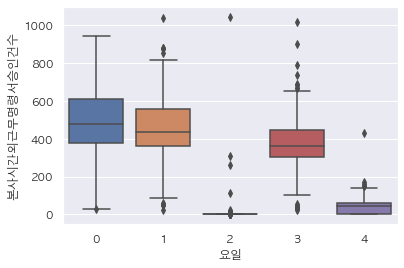

In [1377]:
sns.boxplot(x='요일', y='본사시간외근무명령서승인건수', data = train)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fcd11dca190>,
 'caps': [<matplotlib.lines.Line2D at 0x7fcd11dca700>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fcd11dca160>],
 'medians': [<matplotlib.lines.Line2D at 0x7fcd12530e20>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fcd125305b0>],
 'means': []}

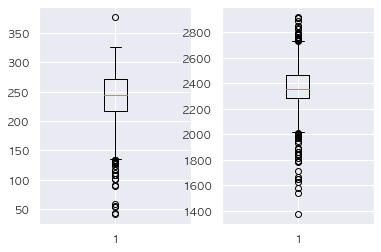

In [1378]:
plt.subplot(1,2,1)
plt.boxplot(train.본사출장자수)
plt.subplot(1,2,2)
plt.boxplot(train.출근)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,...,본사휴가자수_log,출근_scale,본사휴가자수_log_scale,본사출장자수_scale,본사시간외근무명령서승인건수_scale,휴가ls2시간외s,최고기온s2시간외s,시간외s3,출장자수s2시간외s,출근s2시간외s
0,2021-01-27,2,2983,88,182,5,358,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,...,4.488636,-0.058095,-0.473583,-1.359159,-1.093361,-0.245220,-1.052258,-1.307044,-2.019778,-0.003690
2,2021-01-29,4,2983,270,249,0,294,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치,...,5.602119,-1.106314,1.182960,0.180568,-1.113675,-1.558470,-4.130924,-1.381258,-0.036311,-1.363060
5,2021-02-03,2,2924,59,199,5,286,모닝롤/게살모닝샌드 우유/주스 계란후라이/찐계란 소고기죽/흑미밥 시래기된장국 베이컨...,쌀밥/흑미밥/찰현미밥 아욱국 매콤해물볶음 감자조림 미나리나물 포기김치 콥샐러드*렌치D,오므라이스 가쓰오장국 빌소세지구이*구운채소 단감치커리무침 양념고추지 겉절이김치,...,4.094345,0.083557,-1.060176,-0.968482,-1.093361,-1.228908,-3.121700,-1.307044,-1.025525,-0.007634
7,2021-02-05,4,2924,169,252,0,256,모닝롤/앙버터모닝빵 우유/주스 계란후라이/찐계란 고구마죽/흑미밥 옹심이국 머위나물무...,쌀밥/흑미밥/찰현미밥 북엇국 닭볶음탕 채소전*장 솎음열무나물무침 포기김치 양상추샐러...,유부초밥/추가밥 온메밀소바 국물떡볶이 순대찜*소금 청경채겉절이 포기김치,...,5.135798,-0.670028,0.489209,0.249511,-1.113675,-0.266531,-2.070447,-1.381258,-0.069332,-0.499970
10,2021-02-10,2,2924,489,134,0,233,모닝롤/길거리토스트 우유/주스 계란후라이/찐계란 옥수수스프/흑미밥 우거지국 스팸구이...,유니짜장밥 짬뽕국 수제찹쌀꿔바로우 계란후라이 단무지락교무침 포기김치 그린샐러드*딸기...,흑미밥 참치김치찌개 오징어굴소스볶음 차돌비빔국수 건새우무나물 포기김치,...,6.194405,-1.684251,2.064113,-2.462246,-1.113675,-4.744878,-0.714603,-1.381258,-6.751824,-3.159162
13,2021-02-17,2,2924,77,181,3,379,모닝롤/트위스터버거 우유/주스 계란후라이/찐계란 단호박크림스프/흑미밥 사골파국 양념...,쌀밥/흑미밥/찰현미밥 미니쌀국수 삼겹살고추장구이 스프링롤*타르타르D 동초나물무침 알...,곤드레밥 황태국 찰떡떡갈비조림 계란후라이 재래김*달래양념장 무생채,...,4.356709,-0.443386,-0.669853,-1.382140,-1.101486,-0.494240,-5.531369,-1.336402,-2.104180,-0.216543
15,2021-02-19,4,2924,176,268,1,280,모닝롤/크로와상샌드위치 우유/주스 계란후라이/찐계란 쇠고기죽/흑미밥 닭살해장국 해물...,쌀밥/흑미밥/찰현미밥 유부장국 해물누룽지탕 김치전 마약계란장조림 포기김치 양상추샐러...,흑미밥 버섯들깨탕 아귀콩나물찜 콤비네이션피자 돌나물&된장소스 포기김치,...,5.176150,-0.936332,0.549240,0.617206,-1.109612,-0.334731,-0.672563,-1.366196,-0.422700,-0.972817
18,2021-02-24,2,2924,77,235,3,234,모닝롤/파게트 우유/주스 계란후라이 감자스프/흑미밥 시금치된장국 우엉조림 양상추샐러...,쌀밥/흑미밥/찰현미밥 해물탕 쇠고기숙주볶음 맛살계란말이 물미역초고추장무침 포기김치 ...,애플카레라이스 팽이장국 가지탕수 소떡소떡 오복지무침 포기김치,...,4.356709,0.072225,-0.669853,-0.141166,-1.101486,-0.494240,-1.012014,-1.336402,-0.021950,-0.005746
20,2021-02-26,4,2924,261,279,1,179,모닝롤/베이컨맥모닝 우유/주스 계란후라이 게살죽/흑미밥 매생이굴국 두부양념구이 양상...,"쌀밥/오곡밥/찰현미밥 옹심이국 목살스테이크 베이비크랩강정 이색나물(호박고지,건취나물...",흑미밥 스팸김치찌개 삼치구이*와사비장 브로콜리깨소스무침 연근조림 포기김치,...,5.568345,-0.908002,1.132714,0.869997,-1.109612,-1.423676,-0.543393,-1.366196,-0.839860,-0.914839
22,2021-03-03,2,2975,50,195,1,292,모닝롤/크림치즈와플 우유/주스 계란후라이 고구마죽/흑미밥 사골우거지국 비엔나소세지볶...,쌀밥/흑미밥/찰현미밥 황태미역국 동파육 느타리버섯볶음 참나물상추겉절이 포기김치/망고...,흑미밥 (New)수제오떡탕 매운족발볶음 크래미오이보트샐러드 청경채나물 겉절이김치,...,3.931826,0.412188,-1.301957,-1.060406,-1.109612,-1.880895,-1.142634,-1.366196,-1.247714,-0.188521


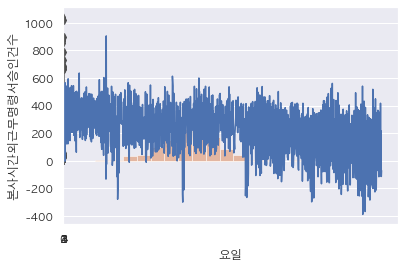

In [1379]:
# IQR을 사용해서 이상치 제거하기
sns.boxplot(x='요일', y='본사시간외근무명령서승인건수', data=train)

# 월
iqr = np.quantile(train[train['요일'] == 0].본사시간외근무명령서승인건수, 0.75) - np.quantile(train[train['요일'] == 0].본사시간외근무명령서승인건수,
                                                                              0.25)
iqr * 1.5
upper = np.quantile(train[train['요일'] == 0].본사시간외근무명령서승인건수, 0.75) + iqr * 1.5
lower = np.quantile(train[train['요일'] == 0].본사시간외근무명령서승인건수, 0.25) - iqr * 1.5
mask_time = (train[train['요일'] == 0].본사시간외근무명령서승인건수 > upper) | (train[train['요일'] == 0].본사시간외근무명령서승인건수 < lower)
train_outliers = train[train['요일'] == 0][mask_time]
List = list(train_outliers.index)
List  # 705 실제 train 데이터에서 엑셀 기준 707

for i in List:
    train.drop(index=i, inplace=True)

# 화 (실제로 예측해야할 데이터들이 화요일에 야근이 많다 따라서 크다고 여겨지는 이상치는 이상치가 아니다)
iqr = np.quantile(train[train['요일'] == 1].본사시간외근무명령서승인건수, 0.75) - np.quantile(train[train['요일'] == 1].본사시간외근무명령서승인건수,
                                                                              0.25)
iqr * 1.5
upper = np.quantile(train[train['요일'] == 1].본사시간외근무명령서승인건수, 0.75) + iqr * 1.5
lower = np.quantile(train[train['요일'] == 1].본사시간외근무명령서승인건수, 0.25) - iqr * 1.5
mask_time = (train[train['요일'] == 1].본사시간외근무명령서승인건수 < lower)
train_outliers = train[train['요일'] == 1][mask_time]
List = list(train_outliers.index)
List  # 152, 163, 223, 453*, 467, 951, 955, 1165*, 1170*, 1175* *별표는 큰 이상치

for i in List:
    train.drop(index=i, inplace=True)

# 수
iqr = np.quantile(train[train['요일'] == 2].본사시간외근무명령서승인건수, 0.75) - np.quantile(train[train['요일'] == 2].본사시간외근무명령서승인건수,
                                                                              0.25)
iqr * 1.5
upper = np.quantile(train[train['요일'] == 2].본사시간외근무명령서승인건수, 0.75) + iqr * 1.5
lower = np.quantile(train[train['요일'] == 2].본사시간외근무명령서승인건수, 0.25) - iqr * 1.5
mask_time = (train[train['요일'] == 2].본사시간외근무명령서승인건수 > upper) | (train[train['요일'] == 2].본사시간외근무명령서승인건수 < lower)
train_outliers = train[train['요일'] == 2][mask_time]
List = list(train_outliers.index)
List  # 세자리, 네자리 수인 2,9,14,18 만 지우겠다.

train.drop(index=2, inplace=True)
train.drop(index=18, inplace=True)
train.drop(index=652, inplace=True)
train.drop(index=894, inplace=True)

# 목
iqr = np.quantile(train[train['요일'] == 3].본사시간외근무명령서승인건수, 0.75) - np.quantile(train[train['요일'] == 3].본사시간외근무명령서승인건수,
                                                                              0.25)
iqr * 1.5
upper = np.quantile(train[train['요일'] == 3].본사시간외근무명령서승인건수, 0.75) + iqr * 1.5
lower = np.quantile(train[train['요일'] == 3].본사시간외근무명령서승인건수, 0.25) - iqr * 1.5
mask_time = (train[train['요일'] == 3].본사시간외근무명령서승인건수 < lower)
train_outliers = train[train['요일'] == 3][mask_time]
List = list(train_outliers.index)  # TESTSET에 746 정도가 있기 때문에 매우 작은 것과 800 이상의 점 두개를 지운다.
List

for i in List:
    train.drop(index=i, inplace=True)

mask_time = (train[train['요일'] == 3].본사시간외근무명령서승인건수 > upper)
train_outliers = train[train['요일'] == 3][mask_time]
List = list(train_outliers.index)  # TESTSET에 746 정도가 있기 때문에 매우 작은 것과 800 이상의 점 두개를 지운다.
List  # 415, 1137

train.drop(index=415, inplace=True)
train.drop(index=1137, inplace=True)

# 금
iqr = np.quantile(train[train['요일'] == 4].본사시간외근무명령서승인건수, 0.75) - np.quantile(train[train['요일'] == 4].본사시간외근무명령서승인건수,
                                                                              0.25)
iqr * 1.5
upper = np.quantile(train[train['요일'] == 4].본사시간외근무명령서승인건수, 0.75) + iqr * 1.5
lower = np.quantile(train[train['요일'] == 4].본사시간외근무명령서승인건수, 0.25) - iqr * 1.5
mask_time = (train[train['요일'] == 4].본사시간외근무명령서승인건수 > upper) | (train[train['요일'] == 4].본사시간외근무명령서승인건수 < lower)
train_outliers = train[train['요일'] == 4][mask_time]
List = list(train_outliers.index)
List  # 400이상인 895번 index만 삭제한다.

train.drop(index=895, inplace=True)

train_lunch = train
train_dinner = train
test_lunch = test
test_dinner = test

# train dinner에서 결측치 이상치 제거하기

mask_oo = train_dinner['일자'] != '2017-09-27'
train_dinner = train_dinner[mask_oo]
mask_ooo = train_dinner['일자'] != '2018-02-14'
train_dinner = train_dinner[mask_ooo]
train_dinner

mask_0 = train_dinner['석식계'] != 0
train_dinner = train_dinner[mask_0]
train_dinner

mask_0 = train_dinner['석식계']!=0
train_dinner = train_dinner[mask_0]
train_dinner
 
train_dinner['야근제외석식'] = train_dinner['석식계']-train_dinner['본사시간외근무명령서승인건수']
plt.plot(train_dinner.index, train_dinner.야근제외석식)
 
train_dinner['석식계'].skew()
train_dinner['석식계'].kurt()
plt.hist(train_dinner['석식계'], bins=15, alpha=0.5)
 
 
 
#월화목/ 수금 분리
mask_day = (train_dinner['요일']==0) |  (train_dinner['요일']==1) | (train_dinner['요일']==3)  
train_dinner_mtt = train_dinner[mask_day]
train_dinner_mtt
 
 
mask_day = (train_dinner['요일']==2) |  (train_dinner['요일']==4)   
train_dinner_wf = train_dinner[mask_day]
train_dinner_wf
 
 
mask_day = (test_dinner['요일']==0) |  (test_dinner['요일']==1) | (test_dinner['요일']==3)  
test_dinner_mtt = test_dinner[mask_day]
test_dinner_mtt
 
 
mask_day = (test_dinner['요일']==2) |  (test_dinner['요일']==4)   
test_dinner_wf = test_dinner[mask_day]
test_dinner_wf

In [1380]:
train.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계', '년', '월', '일', '주',
       '출근', '휴가비율', '출장비율', '야근비율', '재택비율', '출장휴가재택비율', 'TF', '최고기온',
       'overwork', 'home', '공휴일전후', 'covid', 'culture', 'alcho', '확진자수',
       '확진자수_log', '확진자수_log_scale', '현본사소속재택근무자수_scale', '최고기온_scale',
       '본사휴가자수_log', '출근_scale', '본사휴가자수_log_scale', '본사출장자수_scale',
       '본사시간외근무명령서승인건수_scale', '휴가ls2시간외s', '최고기온s2시간외s', '시간외s3',
       '출장자수s2시간외s', '출근s2시간외s'],
      dtype='object')

In [1381]:
#Catboost 모델 적합

In [1382]:
from catboost import CatBoostRegressor
from imblearn.over_sampling import SMOTE

In [1383]:
train_lunch

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,...,본사휴가자수_log,출근_scale,본사휴가자수_log_scale,본사출장자수_scale,본사시간외근무명령서승인건수_scale,휴가ls2시간외s,최고기온s2시간외s,시간외s3,출장자수s2시간외s,출근s2시간외s
0,2016-02-01,0,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",...,3.931826,0.202544,-1.301957,-2.094550,-0.146735,-0.248730,-0.424546,-0.003159,-0.643748,-0.006020
1,2016-02-02,1,2601,50,173,319,0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",...,3.931826,0.072225,-1.301957,-1.565987,0.182349,0.309099,0.447172,0.006063,0.447178,0.000951
3,2016-02-04,3,2601,104,220,355,0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",...,4.653960,-0.500047,-0.227628,-0.485881,0.328609,0.017027,0.641537,0.035484,0.077578,0.082168
4,2016-02-05,4,2601,278,181,34,0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",...,5.631212,-1.264963,1.226242,-1.382140,-0.975540,-1.466890,-1.366429,-0.928401,-1.863584,-1.560994
5,2016-02-11,3,2601,383,143,417,0,팬케익/찐빵 우유/두유/주스 계란후라이 견과류죽/쌀밥 (쌀:국내산) 감자찌개 ...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 시래기국 훈제오리구이 도토리묵무침 쌈무/양...","참치회덮밥 (쌀,현미흑미:국내산) 맑은국 군만두 과일샐러드 락교 포기김치 (...",...,5.950643,-1.644589,1.701463,-2.255417,0.580501,1.680537,0.240419,0.195618,2.952953,1.570064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,2,2983,75,198,4,391,모닝롤/페퍼로니피자 우유/주스 계란후라이/찐계란 크루통크림스프/흑미밥 아귀지리 마늘...,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,...,4.330733,-0.262072,-0.708497,-0.991463,-1.097423,-0.550872,-1.258828,-1.321669,-1.078765,-0.075373
1201,2021-01-21,3,2983,92,231,462,351,모닝롤/생크림단팥빵 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 떡국 해물땡굴소스볶...,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,...,4.532599,-0.318733,-0.408178,-0.233090,0.763325,0.127177,0.546369,0.444764,0.041472,0.077547
1202,2021-01-22,4,2983,255,248,1,303,모닝롤/BLT샌드위치 우유/주스 계란후라이/찐계란 흑임자죽/흑미밥 바지락살국 두부조...,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,...,5.545177,-1.066652,1.098248,0.157587,-1.109612,-1.338356,-1.495693,-1.366196,-0.027556,-1.262456
1203,2021-01-25,0,2983,107,153,616,327,모닝롤/호박고구마오븐구이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 감자양파국 분...,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,...,4.682131,0.174213,-0.185718,-2.025607,1.388992,0.047908,0.595548,2.679781,5.699152,0.042156


## oversampling

In [1384]:
# 2020년도 데이터를 증폭시켜서 비중을 비슷하게 만든 다음 21년도를 예측해보자.

# 제일 마지막 case만 round를 실제로 해준 것과 같다.

# TF 값을 지웠다.


#cc2 = train_lunch[[ '본사휴가자수_log_scale', '본사출장자수_scale' ,'최고기온_scale',
 #                   '휴가ls2시간외s', '시간외s3' ,'출장자수s2시간외s' ,'현본사소속재택근무자수_scale' ,'확진자수_log_scale',
  #                  '본사시간외근무명령서승인건수_scale' ,'최고기온s2시간외s' ,'요일' ,'공휴일전후', '월' ,'중식계']].iloc[:1169]


cc2 = train_lunch[[ '본사휴가자수_log_scale', '본사출장자수_scale' ,'최고기온_scale',
                    '휴가ls2시간외s' ,'현본사소속재택근무자수_scale' ,'확진자수_log_scale'
                     ,'최고기온s2시간외s' ,'요일' ,'공휴일전후', '월' ,'중식계']].iloc[:1169]

train_lunch_home = train_lunch[['home']].iloc[:1169]
train_lunch_home = train_lunch_home['home'].astype('category')


In [1385]:
oversample = SMOTE()
X, y = oversample.fit_resample(cc2, train_lunch_home.ravel())

In [1386]:
cc4_total =pd.DataFrame(X)
cc4_total.fillna(method='ffill')
cc5_total =cc4_total.iloc[: ,-1]
cc4_total_cut = cc4_total.iloc[: ,0:cc2.shape[1]-1]


cc4_total['요일'] = cc4_total['요일'].round()
cc4_total['공휴일전후'] = cc4_total['공휴일전후'].round()
cc4_total['월'] = cc4_total['월'].round()
#cc4_total['TF'] = cc4_total['TF'].round()

cc4_total_cut['요일'] = cc4_total_cut['요일'].round()
cc4_total_cut['공휴일전후'] = cc4_total_cut['공휴일전후'].round()
cc4_total_cut['월'] = cc4_total_cut['월'].round()
#cc4_total_cut['TF'] = cc4_total_cut['TF'].round()

#cc4_1 = train_lunch[[ '본사휴가자수_log_scale', '본사출장자수_scale' ,'최고기온_scale',
#                    '휴가ls2시간외s', '시간외s3' ,'출장자수s2시간외s' ,'현본사소속재택근무자수_scale' ,'확진자수_log_scale',
#                    '본사시간외근무명령서승인건수_scale' ,'최고기온s2시간외s' ,'요일' ,'공휴일전후', '월' ,'중식계']].iloc[1169:]

#중요변수 탐색 이후 feature 변환

cc4_1 = train_lunch[[ '본사휴가자수_log_scale', '본사출장자수_scale' ,'최고기온_scale',
                    '휴가ls2시간외s', '현본사소속재택근무자수_scale' ,'확진자수_log_scale',
                    '최고기온s2시간외s' ,'요일' ,'공휴일전후', '월' ,'중식계']].iloc[1169:]


cc5_1 = train_lunch[['중식계']].iloc[1169:]

In [1387]:
cc4_total_cut

,본사휴가자수_log_scale,본사출장자수_scale,최고기온_scale,휴가ls2시간외s,현본사소속재택근무자수_scale,확진자수_log_scale,최고기온s2시간외s,요일,공휴일전후,월
0,-1.301957,-2.094550,-1.700966,-0.248730,0.000000,-0.422069,-0.424546,0,0,2
1,-1.301957,-1.565987,-1.565977,0.309099,0.000000,-0.422069,0.447172,1,0,2
2,-0.227628,-0.485881,-1.397240,0.017027,0.000000,-0.422069,0.641537,3,0,2
3,1.226242,-1.382140,-1.183507,-1.466890,0.000000,-0.422069,-1.366429,4,1,2
4,1.701463,-2.255417,-0.643551,1.680537,0.000000,-0.422069,0.240419,3,2,2
...,...,...,...,...,...,...,...,...,...,...
1945,0.309915,-2.129366,-0.506195,0.332205,0.582693,2.110432,0.964344,1,0,5
1946,-0.398019,0.300565,-0.389154,0.206212,0.223918,1.825895,0.447007,1,0,9
1947,0.000848,-1.004732,0.318586,-0.589886,0.771423,1.020408,-0.050020,1,0,6
1948,0.472163,0.668269,0.422206,-0.319574,0.418039,1.393306,-0.285175,4,0,5


## Catboost

In [1388]:
model = CatBoostRegressor(iterations=96, learning_rate=0.18, depth=4, l2_leaf_reg=30, subsample=1, eval_metric='MAE', od_type='IncToDec', random_seed=42, allow_writing_files=False)

In [1389]:
model.fit(cc4_total_cut ,cc5_total, verbose=1)

0:	learn: 152.7892181	total: 3.25ms	remaining: 309ms
1:	learn: 138.2822985	total: 5.06ms	remaining: 238ms
2:	learn: 128.6840005	total: 6.32ms	remaining: 196ms
3:	learn: 118.2411797	total: 7.61ms	remaining: 175ms
4:	learn: 110.2603361	total: 9.01ms	remaining: 164ms
5:	learn: 103.1435346	total: 10.7ms	remaining: 161ms
6:	learn: 97.8295146	total: 13.2ms	remaining: 168ms
7:	learn: 93.8555723	total: 14.4ms	remaining: 158ms
8:	learn: 89.8026799	total: 15.5ms	remaining: 150ms
9:	learn: 86.5001517	total: 18.8ms	remaining: 161ms
10:	learn: 83.2858731	total: 20.5ms	remaining: 159ms
11:	learn: 80.7684432	total: 22.5ms	remaining: 157ms
12:	learn: 78.9024785	total: 24.5ms	remaining: 156ms
13:	learn: 76.7252920	total: 26.3ms	remaining: 154ms
14:	learn: 74.6697768	total: 28ms	remaining: 151ms
15:	learn: 73.5429658	total: 30.7ms	remaining: 153ms
16:	learn: 73.1538811	total: 32.5ms	remaining: 151ms
17:	learn: 72.4776162	total: 34.6ms	remaining: 150ms
18:	learn: 71.4650279	total: 36ms	remaining: 146ms
1

In [1390]:
results = model.evals_result_
results

{'learn': {'MAE': [152.78921813343104,
   138.2822984895145,
   128.6840005032176,
   118.24117969054389,
   110.26033609317314,
   103.14353462606996,
   97.82951458209423,
   93.85557229628955,
   89.80267991961747,
   86.50015174950113,
   83.28587308879685,
   80.76844316636159,
   78.90247848561866,
   76.72529199209077,
   74.66977677537072,
   73.5429658082684,
   73.15388105359762,
   72.47761622052863,
   71.46502785863795,
   70.20576133500377,
   69.7482194435999,
   68.7173815844125,
   67.91001947575157,
   67.44519859855991,
   66.89081765007612,
   66.18197716499111,
   65.46466932392718,
   64.88210507482006,
   64.43185169369818,
   63.9644440035851,
   63.567417580348575,
   63.15504752450717,
   62.843870605025025,
   62.73043090771159,
   62.31819168256806,
   62.129913259180256,
   61.704174973861946,
   61.21387786456109,
   60.876352410881026,
   60.642190537865595,
   60.31945171273736,
   59.95797330125691,
   59.67372601488903,
   59.47635624454265,
   59.2635

In [1391]:
from sklearn.model_selection import cross_val_score

model.score(cc4_total_cut ,cc5_total)
cv_results = cross_val_score(model, cc4_total_cut ,cc5_total ,cv=10, scoring='neg_mean_absolute_error')
cv_results.mean()

0:	learn: 155.6172705	total: 1.52ms	remaining: 144ms
1:	learn: 140.6101212	total: 2.96ms	remaining: 139ms
2:	learn: 127.3993691	total: 4.06ms	remaining: 126ms
3:	learn: 117.6860801	total: 5.15ms	remaining: 119ms
4:	learn: 109.2741851	total: 6.32ms	remaining: 115ms
5:	learn: 101.7747532	total: 7.45ms	remaining: 112ms
6:	learn: 96.1859142	total: 8.89ms	remaining: 113ms
7:	learn: 91.1293667	total: 9.98ms	remaining: 110ms
8:	learn: 87.2678733	total: 11.2ms	remaining: 108ms
9:	learn: 84.7329039	total: 12.2ms	remaining: 105ms
10:	learn: 81.7430218	total: 14.1ms	remaining: 109ms
11:	learn: 78.7910319	total: 15.5ms	remaining: 108ms
12:	learn: 76.8521084	total: 16.6ms	remaining: 106ms
13:	learn: 74.8283917	total: 17.6ms	remaining: 103ms
14:	learn: 73.0788196	total: 18.7ms	remaining: 101ms
15:	learn: 71.6896494	total: 19.8ms	remaining: 98.8ms
16:	learn: 70.8709028	total: 20.8ms	remaining: 96.8ms
17:	learn: 70.0652262	total: 21.9ms	remaining: 95.1ms
18:	learn: 69.4597078	total: 23.2ms	remaining: 

68:	learn: 54.4916356	total: 84.3ms	remaining: 33ms
69:	learn: 54.4650815	total: 86.1ms	remaining: 32ms
70:	learn: 54.2287181	total: 87.9ms	remaining: 30.9ms
71:	learn: 53.9730084	total: 93.8ms	remaining: 31.3ms
72:	learn: 53.8702030	total: 96.4ms	remaining: 30.4ms
73:	learn: 53.7135317	total: 97.9ms	remaining: 29.1ms
74:	learn: 53.4676579	total: 99.1ms	remaining: 27.8ms
75:	learn: 53.2832129	total: 100ms	remaining: 26.4ms
76:	learn: 53.1316220	total: 102ms	remaining: 25.1ms
77:	learn: 53.0945450	total: 103ms	remaining: 23.7ms
78:	learn: 52.9812224	total: 104ms	remaining: 22.3ms
79:	learn: 52.8259315	total: 105ms	remaining: 20.9ms
80:	learn: 52.7123283	total: 106ms	remaining: 19.6ms
81:	learn: 52.5683494	total: 107ms	remaining: 18.2ms
82:	learn: 52.4328869	total: 108ms	remaining: 16.9ms
83:	learn: 52.3193689	total: 109ms	remaining: 15.6ms
84:	learn: 52.1753471	total: 110ms	remaining: 14.2ms
85:	learn: 52.1628553	total: 111ms	remaining: 12.9ms
86:	learn: 52.1175537	total: 112ms	remainin

33:	learn: 59.4115887	total: 30.9ms	remaining: 56.3ms
34:	learn: 59.2131228	total: 32.9ms	remaining: 57.4ms
35:	learn: 59.0397568	total: 33.9ms	remaining: 56.6ms
36:	learn: 58.6173631	total: 35ms	remaining: 55.8ms
37:	learn: 58.3216796	total: 36.1ms	remaining: 55.1ms
38:	learn: 57.9523622	total: 37.2ms	remaining: 54.3ms
39:	learn: 57.7926361	total: 38.2ms	remaining: 53.5ms
40:	learn: 57.4747234	total: 39.4ms	remaining: 52.8ms
41:	learn: 57.4565189	total: 40.3ms	remaining: 51.9ms
42:	learn: 57.1710410	total: 41.2ms	remaining: 50.8ms
43:	learn: 56.8810207	total: 42.3ms	remaining: 50ms
44:	learn: 56.6612373	total: 43.4ms	remaining: 49.2ms
45:	learn: 56.6406094	total: 44.4ms	remaining: 48.3ms
46:	learn: 56.6049129	total: 45.4ms	remaining: 47.3ms
47:	learn: 56.5047844	total: 46.7ms	remaining: 46.7ms
48:	learn: 56.4721836	total: 47.8ms	remaining: 45.8ms
49:	learn: 56.2467667	total: 48.8ms	remaining: 44.9ms
50:	learn: 56.1218084	total: 49.7ms	remaining: 43.8ms
51:	learn: 55.9454924	total: 51.

93:	learn: 54.1071908	total: 98.8ms	remaining: 2.1ms
94:	learn: 53.9723959	total: 101ms	remaining: 1.06ms
95:	learn: 53.8859296	total: 102ms	remaining: 0us
0:	learn: 154.3525600	total: 967us	remaining: 91.9ms
1:	learn: 139.9659593	total: 3.46ms	remaining: 163ms
2:	learn: 127.2834371	total: 5.23ms	remaining: 162ms
3:	learn: 118.2254792	total: 6.99ms	remaining: 161ms
4:	learn: 110.3803266	total: 8.93ms	remaining: 162ms
5:	learn: 103.1705434	total: 10.8ms	remaining: 162ms
6:	learn: 97.4925286	total: 12.7ms	remaining: 161ms
7:	learn: 92.6677409	total: 14.4ms	remaining: 159ms
8:	learn: 88.6231516	total: 17.7ms	remaining: 171ms
9:	learn: 85.8943737	total: 20.7ms	remaining: 178ms
10:	learn: 82.8999339	total: 22.7ms	remaining: 175ms
11:	learn: 80.1085530	total: 30.4ms	remaining: 213ms
12:	learn: 78.3999924	total: 33ms	remaining: 211ms
13:	learn: 76.1769080	total: 35.1ms	remaining: 206ms
14:	learn: 74.8670178	total: 37.7ms	remaining: 204ms
15:	learn: 73.2806563	total: 43.5ms	remaining: 218ms
16

8:	learn: 89.2469782	total: 9.1ms	remaining: 88ms
9:	learn: 86.3225516	total: 10.4ms	remaining: 89.6ms
10:	learn: 82.7583723	total: 12.1ms	remaining: 93.4ms
11:	learn: 80.2035972	total: 13.5ms	remaining: 94.4ms
12:	learn: 78.3103298	total: 14.9ms	remaining: 95.3ms
13:	learn: 76.3973924	total: 16.4ms	remaining: 95.9ms
14:	learn: 75.0821770	total: 17.8ms	remaining: 96.2ms
15:	learn: 73.8929866	total: 19.2ms	remaining: 96.2ms
16:	learn: 73.0067477	total: 21.8ms	remaining: 101ms
17:	learn: 71.7796550	total: 23.4ms	remaining: 101ms
18:	learn: 71.1387976	total: 25.1ms	remaining: 102ms
19:	learn: 70.6223386	total: 26.5ms	remaining: 101ms
20:	learn: 69.8243043	total: 28ms	remaining: 99.9ms
21:	learn: 68.7860322	total: 29.6ms	remaining: 99.7ms
22:	learn: 68.1593672	total: 31.3ms	remaining: 99.5ms
23:	learn: 67.7720779	total: 32.9ms	remaining: 98.8ms
24:	learn: 67.3083456	total: 34.6ms	remaining: 98.2ms
25:	learn: 66.5529367	total: 36.1ms	remaining: 97.1ms
26:	learn: 65.9974218	total: 37.5ms	rem

66:	learn: 57.6796731	total: 81ms	remaining: 35.1ms
67:	learn: 57.4727584	total: 83.1ms	remaining: 34.2ms
68:	learn: 57.4274979	total: 84.9ms	remaining: 33.2ms
69:	learn: 57.3008617	total: 86.7ms	remaining: 32.2ms
70:	learn: 57.1925722	total: 89ms	remaining: 31.3ms
71:	learn: 57.1231094	total: 90.7ms	remaining: 30.2ms
72:	learn: 56.9838249	total: 92.2ms	remaining: 29.1ms
73:	learn: 56.8296879	total: 93.8ms	remaining: 27.9ms
74:	learn: 56.6736245	total: 95.7ms	remaining: 26.8ms
75:	learn: 56.5862918	total: 97.2ms	remaining: 25.6ms
76:	learn: 56.3671248	total: 100ms	remaining: 24.7ms
77:	learn: 56.2785021	total: 102ms	remaining: 23.5ms
78:	learn: 56.2378580	total: 103ms	remaining: 22.3ms
79:	learn: 56.0631011	total: 105ms	remaining: 21.1ms
80:	learn: 56.0458558	total: 107ms	remaining: 19.8ms
81:	learn: 55.8156618	total: 108ms	remaining: 18.5ms
82:	learn: 55.7758664	total: 110ms	remaining: 17.2ms
83:	learn: 55.5946147	total: 113ms	remaining: 16.1ms
84:	learn: 55.5783692	total: 114ms	remai

-60.20559034100862

In [1392]:
pd.Series(model.feature_importances_, index=cc4_total_cut.columns).sort_values(ascending=False)[:50]

요일                   45.856507
본사출장자수_scale         19.722361
본사휴가자수_log_scale      8.323036
휴가ls2시간외s             7.973261
확진자수_log_scale        5.282174
현본사소속재택근무자수_scale     3.411076
최고기온_scale            3.278553
월                     2.875476
최고기온s2시간외s            1.841225
공휴일전후                 1.436330
dtype: float64

In [1393]:
test_data_lunch = test_lunch[[ '본사휴가자수_log_scale', '본사출장자수_scale' ,'최고기온_scale',
                    '휴가ls2시간외s', '현본사소속재택근무자수_scale' ,'확진자수_log_scale',
                    '최고기온s2시간외s' ,'요일' ,'공휴일전후', '월']]

In [1394]:
lunch_prediction = model.predict(test_data_lunch)

In [1395]:
train_dinner.shape

(1143, 46)

In [1396]:
cc2 = train_dinner[['본사출장자수_scale', '본사휴가자수_log_scale', '확진자수_log_scale',
                    '본사시간외근무명령서승인건수_scale', '현본사소속재택근무자수_scale',
                    '휴가ls2시간외s', '시간외s3',
                    '월', '석식계']].iloc[:1133]

train_dinner_home = train_dinner[['home']].iloc[:1133]
train_dinner_home = train_dinner_home['home'].astype('category')

from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(cc2, train_dinner_home.ravel())
cc4_total = pd.DataFrame(X)
cc4_total.fillna(method='ffill')
cc5_total = cc4_total.iloc[:, -1]
cc4_total_cut = cc4_total.iloc[:, 0:cc2.shape[1] - 1]


In [1397]:
#cc4_total_cut['요일'] = cc4_total_cut['요일'].round()
#cc4_total_cut['공휴일전후'] = cc4_total_cut['공휴일전후'].round()
cc4_total_cut['월'] = cc4_total_cut['월'].round()
#cc4_total_cut['TF'] = cc4_total_cut['TF'].round()
#cc4_total_cut['covid'] = cc4_total_cut['covid'].round()

cc4_1 = train_dinner[['본사출장자수_scale', '본사휴가자수_log_scale', '확진자수_log_scale',
                      '본사시간외근무명령서승인건수_scale', '현본사소속재택근무자수_scale',
                      '휴가ls2시간외s', '시간외s3',
                      '월', ]].iloc[1133:]

cc5_1 = train_dinner[['석식계']].iloc[1133:]

In [1398]:
model2 = CatBoostRegressor(iterations=1700, learning_rate=0.01, depth=4, l2_leaf_reg=25, subsample=1, eval_metric='MAE',
                          od_type='IncToDec', random_seed=42, allow_writing_files=False)
model2.fit(cc4_total_cut, cc5_total, verbose=1)

0:	learn: 94.3741898	total: 1.57ms	remaining: 2.67s
1:	learn: 93.9020014	total: 4.69ms	remaining: 3.98s
2:	learn: 93.5172974	total: 6.04ms	remaining: 3.42s
3:	learn: 93.0597416	total: 8.77ms	remaining: 3.72s
4:	learn: 92.5936575	total: 11.8ms	remaining: 4s
5:	learn: 92.1281578	total: 14.5ms	remaining: 4.09s
6:	learn: 91.7038206	total: 17ms	remaining: 4.11s
7:	learn: 91.2649905	total: 18.6ms	remaining: 3.94s
8:	learn: 90.8211081	total: 20.5ms	remaining: 3.85s
9:	learn: 90.3907276	total: 21.7ms	remaining: 3.67s
10:	learn: 89.9609893	total: 24.1ms	remaining: 3.7s
11:	learn: 89.5576593	total: 29.5ms	remaining: 4.16s
12:	learn: 89.0981025	total: 30.7ms	remaining: 3.98s
13:	learn: 88.6795834	total: 32.2ms	remaining: 3.87s
14:	learn: 88.2341718	total: 34.1ms	remaining: 3.83s
15:	learn: 87.8151150	total: 36.4ms	remaining: 3.83s
16:	learn: 87.4182556	total: 38.1ms	remaining: 3.77s
17:	learn: 86.9948531	total: 40.2ms	remaining: 3.75s
18:	learn: 86.5948986	total: 41.7ms	remaining: 3.69s
19:	learn

180:	learn: 55.9655486	total: 335ms	remaining: 2.81s
181:	learn: 55.8772364	total: 336ms	remaining: 2.81s
182:	learn: 55.7996683	total: 338ms	remaining: 2.8s
183:	learn: 55.7301183	total: 340ms	remaining: 2.8s
184:	learn: 55.6407975	total: 341ms	remaining: 2.79s
185:	learn: 55.5692677	total: 343ms	remaining: 2.79s
186:	learn: 55.4961462	total: 344ms	remaining: 2.78s
187:	learn: 55.4067495	total: 345ms	remaining: 2.77s
188:	learn: 55.3321398	total: 346ms	remaining: 2.76s
189:	learn: 55.2701056	total: 347ms	remaining: 2.75s
190:	learn: 55.1982437	total: 348ms	remaining: 2.75s
191:	learn: 55.1195324	total: 349ms	remaining: 2.74s
192:	learn: 55.0344707	total: 350ms	remaining: 2.73s
193:	learn: 54.9542057	total: 351ms	remaining: 2.72s
194:	learn: 54.8970280	total: 352ms	remaining: 2.71s
195:	learn: 54.8152536	total: 353ms	remaining: 2.71s
196:	learn: 54.7596226	total: 355ms	remaining: 2.71s
197:	learn: 54.7136261	total: 356ms	remaining: 2.7s
198:	learn: 54.6420906	total: 357ms	remaining: 2.

347:	learn: 48.0478461	total: 513ms	remaining: 1.99s
348:	learn: 48.0115089	total: 515ms	remaining: 1.99s
349:	learn: 47.9807168	total: 516ms	remaining: 1.99s
350:	learn: 47.9482978	total: 517ms	remaining: 1.99s
351:	learn: 47.9212187	total: 518ms	remaining: 1.98s
352:	learn: 47.8800763	total: 519ms	remaining: 1.98s
353:	learn: 47.8601532	total: 520ms	remaining: 1.98s
354:	learn: 47.8213368	total: 521ms	remaining: 1.97s
355:	learn: 47.7917986	total: 522ms	remaining: 1.97s
356:	learn: 47.7604491	total: 522ms	remaining: 1.97s
357:	learn: 47.7196420	total: 523ms	remaining: 1.96s
358:	learn: 47.6881043	total: 524ms	remaining: 1.96s
359:	learn: 47.6612037	total: 525ms	remaining: 1.95s
360:	learn: 47.6258289	total: 526ms	remaining: 1.95s
361:	learn: 47.5957819	total: 527ms	remaining: 1.95s
362:	learn: 47.5617689	total: 528ms	remaining: 1.94s
363:	learn: 47.5389090	total: 529ms	remaining: 1.94s
364:	learn: 47.5110912	total: 530ms	remaining: 1.94s
365:	learn: 47.4941066	total: 531ms	remaining:

546:	learn: 43.8929553	total: 696ms	remaining: 1.47s
547:	learn: 43.8713160	total: 697ms	remaining: 1.47s
548:	learn: 43.8638139	total: 698ms	remaining: 1.46s
549:	learn: 43.8425311	total: 699ms	remaining: 1.46s
550:	learn: 43.8168317	total: 700ms	remaining: 1.46s
551:	learn: 43.8071117	total: 701ms	remaining: 1.46s
552:	learn: 43.7927351	total: 702ms	remaining: 1.46s
553:	learn: 43.7836422	total: 704ms	remaining: 1.46s
554:	learn: 43.7706981	total: 705ms	remaining: 1.45s
555:	learn: 43.7639474	total: 706ms	remaining: 1.45s
556:	learn: 43.7509009	total: 707ms	remaining: 1.45s
557:	learn: 43.7371081	total: 708ms	remaining: 1.45s
558:	learn: 43.7282340	total: 709ms	remaining: 1.45s
559:	learn: 43.7094771	total: 710ms	remaining: 1.44s
560:	learn: 43.7065988	total: 710ms	remaining: 1.44s
561:	learn: 43.6909314	total: 711ms	remaining: 1.44s
562:	learn: 43.6790820	total: 712ms	remaining: 1.44s
563:	learn: 43.6595476	total: 713ms	remaining: 1.44s
564:	learn: 43.6529287	total: 714ms	remaining:

714:	learn: 42.0658715	total: 888ms	remaining: 1.22s
715:	learn: 42.0625109	total: 891ms	remaining: 1.22s
716:	learn: 42.0572234	total: 892ms	remaining: 1.22s
717:	learn: 42.0532590	total: 893ms	remaining: 1.22s
718:	learn: 42.0367170	total: 895ms	remaining: 1.22s
719:	learn: 42.0217784	total: 896ms	remaining: 1.22s
720:	learn: 42.0161942	total: 897ms	remaining: 1.22s
721:	learn: 42.0099817	total: 898ms	remaining: 1.22s
722:	learn: 42.0015451	total: 899ms	remaining: 1.21s
723:	learn: 41.9919843	total: 900ms	remaining: 1.21s
724:	learn: 41.9867362	total: 901ms	remaining: 1.21s
725:	learn: 41.9714837	total: 902ms	remaining: 1.21s
726:	learn: 41.9644859	total: 903ms	remaining: 1.21s
727:	learn: 41.9604382	total: 904ms	remaining: 1.21s
728:	learn: 41.9523566	total: 905ms	remaining: 1.21s
729:	learn: 41.9408060	total: 906ms	remaining: 1.2s
730:	learn: 41.9376628	total: 907ms	remaining: 1.2s
731:	learn: 41.9321234	total: 908ms	remaining: 1.2s
732:	learn: 41.9233241	total: 909ms	remaining: 1.

879:	learn: 40.9282791	total: 1.04s	remaining: 970ms
880:	learn: 40.9162253	total: 1.04s	remaining: 969ms
881:	learn: 40.9134696	total: 1.04s	remaining: 968ms
882:	learn: 40.9092555	total: 1.04s	remaining: 966ms
883:	learn: 40.9069052	total: 1.04s	remaining: 965ms
884:	learn: 40.8921665	total: 1.05s	remaining: 964ms
885:	learn: 40.8850713	total: 1.05s	remaining: 962ms
886:	learn: 40.8808051	total: 1.05s	remaining: 961ms
887:	learn: 40.8743359	total: 1.05s	remaining: 960ms
888:	learn: 40.8654678	total: 1.05s	remaining: 958ms
889:	learn: 40.8534416	total: 1.05s	remaining: 957ms
890:	learn: 40.8523063	total: 1.05s	remaining: 955ms
891:	learn: 40.8489508	total: 1.05s	remaining: 954ms
892:	learn: 40.8374780	total: 1.05s	remaining: 953ms
893:	learn: 40.8307567	total: 1.05s	remaining: 951ms
894:	learn: 40.8216122	total: 1.05s	remaining: 950ms
895:	learn: 40.8135525	total: 1.06s	remaining: 948ms
896:	learn: 40.8047057	total: 1.06s	remaining: 947ms
897:	learn: 40.8033834	total: 1.06s	remaining:

1093:	learn: 40.1269554	total: 1.22s	remaining: 677ms
1094:	learn: 40.1264187	total: 1.22s	remaining: 676ms
1095:	learn: 40.1170933	total: 1.22s	remaining: 675ms
1096:	learn: 40.1077944	total: 1.23s	remaining: 674ms
1097:	learn: 40.1076100	total: 1.23s	remaining: 672ms
1098:	learn: 40.0978889	total: 1.23s	remaining: 671ms
1099:	learn: 40.0969817	total: 1.23s	remaining: 670ms
1100:	learn: 40.0880786	total: 1.23s	remaining: 669ms
1101:	learn: 40.0814432	total: 1.23s	remaining: 668ms
1102:	learn: 40.0745599	total: 1.23s	remaining: 666ms
1103:	learn: 40.0736557	total: 1.23s	remaining: 665ms
1104:	learn: 40.0648212	total: 1.23s	remaining: 664ms
1105:	learn: 40.0647232	total: 1.23s	remaining: 663ms
1106:	learn: 40.0645508	total: 1.23s	remaining: 661ms
1107:	learn: 40.0582743	total: 1.24s	remaining: 660ms
1108:	learn: 40.0555479	total: 1.24s	remaining: 659ms
1109:	learn: 40.0461198	total: 1.24s	remaining: 658ms
1110:	learn: 40.0459830	total: 1.24s	remaining: 657ms
1111:	learn: 40.0450609	tota

1253:	learn: 39.4621042	total: 1.4s	remaining: 500ms
1254:	learn: 39.4613049	total: 1.41s	remaining: 499ms
1255:	learn: 39.4605152	total: 1.41s	remaining: 497ms
1256:	learn: 39.4597272	total: 1.41s	remaining: 496ms
1257:	learn: 39.4589408	total: 1.41s	remaining: 495ms
1258:	learn: 39.4568250	total: 1.41s	remaining: 494ms
1259:	learn: 39.4501498	total: 1.41s	remaining: 493ms
1260:	learn: 39.4493713	total: 1.41s	remaining: 492ms
1261:	learn: 39.4430921	total: 1.41s	remaining: 490ms
1262:	learn: 39.4423070	total: 1.41s	remaining: 489ms
1263:	learn: 39.4415308	total: 1.42s	remaining: 488ms
1264:	learn: 39.4407490	total: 1.42s	remaining: 487ms
1265:	learn: 39.4383017	total: 1.42s	remaining: 486ms
1266:	learn: 39.4320650	total: 1.42s	remaining: 485ms
1267:	learn: 39.4312836	total: 1.42s	remaining: 484ms
1268:	learn: 39.4288471	total: 1.42s	remaining: 483ms
1269:	learn: 39.4287572	total: 1.42s	remaining: 481ms
1270:	learn: 39.4225628	total: 1.42s	remaining: 480ms
1271:	learn: 39.4217942	total

1442:	learn: 38.8288348	total: 1.59s	remaining: 283ms
1443:	learn: 38.8281247	total: 1.59s	remaining: 281ms
1444:	learn: 38.8273848	total: 1.59s	remaining: 280ms
1445:	learn: 38.8227710	total: 1.59s	remaining: 279ms
1446:	learn: 38.8183665	total: 1.59s	remaining: 278ms
1447:	learn: 38.8176275	total: 1.59s	remaining: 277ms
1448:	learn: 38.8169252	total: 1.59s	remaining: 276ms
1449:	learn: 38.8126691	total: 1.59s	remaining: 275ms
1450:	learn: 38.8085369	total: 1.59s	remaining: 274ms
1451:	learn: 38.8051754	total: 1.59s	remaining: 273ms
1452:	learn: 38.8006235	total: 1.6s	remaining: 271ms
1453:	learn: 38.7916225	total: 1.6s	remaining: 270ms
1454:	learn: 38.7829923	total: 1.6s	remaining: 269ms
1455:	learn: 38.7770894	total: 1.6s	remaining: 268ms
1456:	learn: 38.7713996	total: 1.6s	remaining: 267ms
1457:	learn: 38.7682388	total: 1.6s	remaining: 266ms
1458:	learn: 38.7649528	total: 1.6s	remaining: 265ms
1459:	learn: 38.7625929	total: 1.6s	remaining: 263ms
1460:	learn: 38.7561965	total: 1.6s	

1642:	learn: 38.2103748	total: 1.76s	remaining: 61.2ms
1643:	learn: 38.2042945	total: 1.77s	remaining: 60.2ms
1644:	learn: 38.1982541	total: 1.77s	remaining: 59.1ms
1645:	learn: 38.1922573	total: 1.77s	remaining: 58.1ms
1646:	learn: 38.1899379	total: 1.77s	remaining: 57ms
1647:	learn: 38.1894453	total: 1.77s	remaining: 55.9ms
1648:	learn: 38.1862091	total: 1.77s	remaining: 54.9ms
1649:	learn: 38.1857223	total: 1.77s	remaining: 53.8ms
1650:	learn: 38.1852364	total: 1.77s	remaining: 52.7ms
1651:	learn: 38.1797761	total: 1.78s	remaining: 51.6ms
1652:	learn: 38.1748823	total: 1.78s	remaining: 50.5ms
1653:	learn: 38.1696604	total: 1.78s	remaining: 49.5ms
1654:	learn: 38.1691716	total: 1.78s	remaining: 48.4ms
1655:	learn: 38.1686836	total: 1.78s	remaining: 47.3ms
1656:	learn: 38.1681965	total: 1.78s	remaining: 46.2ms
1657:	learn: 38.1677101	total: 1.78s	remaining: 45.2ms
1658:	learn: 38.1672240	total: 1.78s	remaining: 44.1ms
1659:	learn: 38.1667387	total: 1.78s	remaining: 43ms
1660:	learn: 3

In [1399]:
from sklearn.model_selection import KFold

model2.score(cc4_total_cut, cc5_total)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(model2, cc4_total_cut, cc5_total, cv=10)
cv_results.mean()

0:	learn: 95.3751476	total: 1.97ms	remaining: 3.35s
1:	learn: 94.8597294	total: 3.23ms	remaining: 2.75s
2:	learn: 94.3995032	total: 4.2ms	remaining: 2.38s
3:	learn: 93.8995348	total: 4.99ms	remaining: 2.12s
4:	learn: 93.4717657	total: 5.84ms	remaining: 1.98s
5:	learn: 92.9946063	total: 7.23ms	remaining: 2.04s
6:	learn: 92.5259180	total: 8.53ms	remaining: 2.06s
7:	learn: 92.0400786	total: 9.43ms	remaining: 1.99s
8:	learn: 91.5478655	total: 10.3ms	remaining: 1.93s
9:	learn: 91.0917795	total: 11.2ms	remaining: 1.89s
10:	learn: 90.5931262	total: 12.1ms	remaining: 1.86s
11:	learn: 90.1289387	total: 13ms	remaining: 1.83s
12:	learn: 89.6451195	total: 14.5ms	remaining: 1.89s
13:	learn: 89.2374849	total: 15.6ms	remaining: 1.88s
14:	learn: 88.8317007	total: 16.5ms	remaining: 1.85s
15:	learn: 88.4411371	total: 17.4ms	remaining: 1.83s
16:	learn: 88.0275927	total: 18.3ms	remaining: 1.81s
17:	learn: 87.6728992	total: 19.1ms	remaining: 1.78s
18:	learn: 87.2686880	total: 20.4ms	remaining: 1.8s
19:	lea

156:	learn: 56.9471334	total: 180ms	remaining: 1.77s
157:	learn: 56.8364537	total: 182ms	remaining: 1.77s
158:	learn: 56.7471456	total: 183ms	remaining: 1.77s
159:	learn: 56.6649618	total: 184ms	remaining: 1.77s
160:	learn: 56.5624875	total: 184ms	remaining: 1.76s
161:	learn: 56.4709388	total: 185ms	remaining: 1.76s
162:	learn: 56.3836550	total: 186ms	remaining: 1.75s
163:	learn: 56.2836722	total: 187ms	remaining: 1.75s
164:	learn: 56.2095421	total: 188ms	remaining: 1.75s
165:	learn: 56.1093998	total: 189ms	remaining: 1.75s
166:	learn: 56.0227513	total: 190ms	remaining: 1.74s
167:	learn: 55.9384347	total: 191ms	remaining: 1.74s
168:	learn: 55.8558159	total: 192ms	remaining: 1.74s
169:	learn: 55.7443102	total: 193ms	remaining: 1.73s
170:	learn: 55.6646243	total: 194ms	remaining: 1.73s
171:	learn: 55.5864658	total: 195ms	remaining: 1.73s
172:	learn: 55.5056766	total: 195ms	remaining: 1.73s
173:	learn: 55.4069797	total: 196ms	remaining: 1.72s
174:	learn: 55.3156428	total: 197ms	remaining:

326:	learn: 47.4323732	total: 364ms	remaining: 1.53s
327:	learn: 47.3876788	total: 366ms	remaining: 1.53s
328:	learn: 47.3433914	total: 367ms	remaining: 1.53s
329:	learn: 47.3190970	total: 368ms	remaining: 1.53s
330:	learn: 47.2903525	total: 369ms	remaining: 1.52s
331:	learn: 47.2555916	total: 370ms	remaining: 1.52s
332:	learn: 47.2155653	total: 370ms	remaining: 1.52s
333:	learn: 47.1790398	total: 371ms	remaining: 1.52s
334:	learn: 47.1413626	total: 372ms	remaining: 1.52s
335:	learn: 47.1165335	total: 373ms	remaining: 1.51s
336:	learn: 47.0729690	total: 374ms	remaining: 1.51s
337:	learn: 47.0506497	total: 375ms	remaining: 1.51s
338:	learn: 47.0148422	total: 376ms	remaining: 1.51s
339:	learn: 46.9894038	total: 377ms	remaining: 1.51s
340:	learn: 46.9694074	total: 378ms	remaining: 1.51s
341:	learn: 46.9449944	total: 379ms	remaining: 1.5s
342:	learn: 46.9185794	total: 381ms	remaining: 1.5s
343:	learn: 46.8873745	total: 382ms	remaining: 1.51s
344:	learn: 46.8631937	total: 384ms	remaining: 1

495:	learn: 43.4947873	total: 546ms	remaining: 1.33s
496:	learn: 43.4861593	total: 547ms	remaining: 1.32s
497:	learn: 43.4757671	total: 549ms	remaining: 1.32s
498:	learn: 43.4597345	total: 550ms	remaining: 1.32s
499:	learn: 43.4416231	total: 551ms	remaining: 1.32s
500:	learn: 43.4235320	total: 552ms	remaining: 1.32s
501:	learn: 43.4046982	total: 553ms	remaining: 1.32s
502:	learn: 43.3868317	total: 554ms	remaining: 1.32s
503:	learn: 43.3696548	total: 555ms	remaining: 1.32s
504:	learn: 43.3495365	total: 556ms	remaining: 1.31s
505:	learn: 43.3316687	total: 557ms	remaining: 1.31s
506:	learn: 43.3130321	total: 557ms	remaining: 1.31s
507:	learn: 43.2979830	total: 558ms	remaining: 1.31s
508:	learn: 43.2844887	total: 559ms	remaining: 1.31s
509:	learn: 43.2613982	total: 560ms	remaining: 1.31s
510:	learn: 43.2520556	total: 561ms	remaining: 1.31s
511:	learn: 43.2425026	total: 562ms	remaining: 1.3s
512:	learn: 43.2162652	total: 563ms	remaining: 1.3s
513:	learn: 43.2081990	total: 564ms	remaining: 1

669:	learn: 41.3337337	total: 727ms	remaining: 1.12s
670:	learn: 41.3224724	total: 728ms	remaining: 1.12s
671:	learn: 41.3161406	total: 730ms	remaining: 1.12s
672:	learn: 41.2995623	total: 731ms	remaining: 1.11s
673:	learn: 41.2832199	total: 732ms	remaining: 1.11s
674:	learn: 41.2775664	total: 732ms	remaining: 1.11s
675:	learn: 41.2659545	total: 733ms	remaining: 1.11s
676:	learn: 41.2575614	total: 734ms	remaining: 1.11s
677:	learn: 41.2437354	total: 735ms	remaining: 1.11s
678:	learn: 41.2378932	total: 736ms	remaining: 1.11s
679:	learn: 41.2292760	total: 738ms	remaining: 1.11s
680:	learn: 41.2111956	total: 738ms	remaining: 1.1s
681:	learn: 41.2034449	total: 739ms	remaining: 1.1s
682:	learn: 41.1918265	total: 740ms	remaining: 1.1s
683:	learn: 41.1838505	total: 741ms	remaining: 1.1s
684:	learn: 41.1730718	total: 742ms	remaining: 1.1s
685:	learn: 41.1549048	total: 743ms	remaining: 1.1s
686:	learn: 41.1460740	total: 744ms	remaining: 1.1s
687:	learn: 41.1397010	total: 745ms	remaining: 1.1s
6

857:	learn: 39.8119112	total: 907ms	remaining: 890ms
858:	learn: 39.8092429	total: 908ms	remaining: 889ms
859:	learn: 39.8053481	total: 909ms	remaining: 888ms
860:	learn: 39.7950839	total: 910ms	remaining: 887ms
861:	learn: 39.7839495	total: 911ms	remaining: 886ms
862:	learn: 39.7801965	total: 912ms	remaining: 884ms
863:	learn: 39.7711401	total: 913ms	remaining: 883ms
864:	learn: 39.7674291	total: 914ms	remaining: 882ms
865:	learn: 39.7620335	total: 915ms	remaining: 881ms
866:	learn: 39.7598885	total: 916ms	remaining: 880ms
867:	learn: 39.7503236	total: 917ms	remaining: 879ms
868:	learn: 39.7465452	total: 918ms	remaining: 878ms
869:	learn: 39.7378662	total: 919ms	remaining: 876ms
870:	learn: 39.7300028	total: 920ms	remaining: 875ms
871:	learn: 39.7271662	total: 921ms	remaining: 874ms
872:	learn: 39.7250265	total: 921ms	remaining: 873ms
873:	learn: 39.7227403	total: 922ms	remaining: 872ms
874:	learn: 39.7195459	total: 923ms	remaining: 871ms
875:	learn: 39.7165179	total: 924ms	remaining:

1024:	learn: 38.8718944	total: 1.09s	remaining: 717ms
1025:	learn: 38.8667469	total: 1.09s	remaining: 716ms
1026:	learn: 38.8616240	total: 1.09s	remaining: 716ms
1027:	learn: 38.8531353	total: 1.09s	remaining: 716ms
1028:	learn: 38.8480349	total: 1.1s	remaining: 715ms
1029:	learn: 38.8445210	total: 1.1s	remaining: 714ms
1030:	learn: 38.8393154	total: 1.1s	remaining: 713ms
1031:	learn: 38.8329192	total: 1.1s	remaining: 712ms
1032:	learn: 38.8287997	total: 1.1s	remaining: 711ms
1033:	learn: 38.8237243	total: 1.1s	remaining: 710ms
1034:	learn: 38.8111816	total: 1.1s	remaining: 710ms
1035:	learn: 38.8048689	total: 1.1s	remaining: 709ms
1036:	learn: 38.8005741	total: 1.11s	remaining: 708ms
1037:	learn: 38.7974332	total: 1.11s	remaining: 707ms
1038:	learn: 38.7924744	total: 1.11s	remaining: 707ms
1039:	learn: 38.7856495	total: 1.11s	remaining: 706ms
1040:	learn: 38.7823713	total: 1.11s	remaining: 705ms
1041:	learn: 38.7755497	total: 1.12s	remaining: 705ms
1042:	learn: 38.7708824	total: 1.12s

1185:	learn: 38.0361874	total: 1.33s	remaining: 576ms
1186:	learn: 38.0327856	total: 1.33s	remaining: 575ms
1187:	learn: 38.0277824	total: 1.33s	remaining: 574ms
1188:	learn: 38.0209499	total: 1.33s	remaining: 573ms
1189:	learn: 38.0175767	total: 1.33s	remaining: 571ms
1190:	learn: 38.0140799	total: 1.34s	remaining: 571ms
1191:	learn: 38.0010968	total: 1.34s	remaining: 570ms
1192:	learn: 37.9961341	total: 1.34s	remaining: 569ms
1193:	learn: 37.9911612	total: 1.34s	remaining: 568ms
1194:	learn: 37.9783847	total: 1.34s	remaining: 567ms
1195:	learn: 37.9717639	total: 1.34s	remaining: 566ms
1196:	learn: 37.9688188	total: 1.34s	remaining: 565ms
1197:	learn: 37.9654195	total: 1.35s	remaining: 568ms
1198:	learn: 37.9638716	total: 1.36s	remaining: 567ms
1199:	learn: 37.9624643	total: 1.36s	remaining: 565ms
1200:	learn: 37.9580291	total: 1.36s	remaining: 565ms
1201:	learn: 37.9546356	total: 1.36s	remaining: 564ms
1202:	learn: 37.9477026	total: 1.36s	remaining: 562ms
1203:	learn: 37.9443697	tota

1384:	learn: 37.1490928	total: 1.6s	remaining: 363ms
1385:	learn: 37.1397137	total: 1.6s	remaining: 362ms
1386:	learn: 37.1354142	total: 1.6s	remaining: 361ms
1387:	learn: 37.1344349	total: 1.6s	remaining: 360ms
1388:	learn: 37.1278817	total: 1.6s	remaining: 359ms
1389:	learn: 37.1219057	total: 1.6s	remaining: 358ms
1390:	learn: 37.1210274	total: 1.6s	remaining: 356ms
1391:	learn: 37.1201497	total: 1.6s	remaining: 355ms
1392:	learn: 37.1192725	total: 1.61s	remaining: 354ms
1393:	learn: 37.1104862	total: 1.61s	remaining: 353ms
1394:	learn: 37.1047103	total: 1.61s	remaining: 352ms
1395:	learn: 37.1033226	total: 1.61s	remaining: 351ms
1396:	learn: 37.1024578	total: 1.61s	remaining: 350ms
1397:	learn: 37.0964811	total: 1.61s	remaining: 348ms
1398:	learn: 37.0893926	total: 1.61s	remaining: 347ms
1399:	learn: 37.0806987	total: 1.61s	remaining: 346ms
1400:	learn: 37.0793135	total: 1.62s	remaining: 345ms
1401:	learn: 37.0734686	total: 1.62s	remaining: 344ms
1402:	learn: 37.0720869	total: 1.62s

1539:	learn: 36.4508150	total: 1.77s	remaining: 184ms
1540:	learn: 36.4461437	total: 1.77s	remaining: 183ms
1541:	learn: 36.4432895	total: 1.78s	remaining: 182ms
1542:	learn: 36.4409068	total: 1.78s	remaining: 181ms
1543:	learn: 36.4364040	total: 1.78s	remaining: 180ms
1544:	learn: 36.4312947	total: 1.78s	remaining: 179ms
1545:	learn: 36.4289410	total: 1.78s	remaining: 177ms
1546:	learn: 36.4262277	total: 1.78s	remaining: 176ms
1547:	learn: 36.4236153	total: 1.78s	remaining: 175ms
1548:	learn: 36.4185321	total: 1.79s	remaining: 174ms
1549:	learn: 36.4148248	total: 1.79s	remaining: 173ms
1550:	learn: 36.4069635	total: 1.79s	remaining: 172ms
1551:	learn: 36.4036112	total: 1.79s	remaining: 171ms
1552:	learn: 36.3987308	total: 1.79s	remaining: 170ms
1553:	learn: 36.3977044	total: 1.79s	remaining: 168ms
1554:	learn: 36.3966809	total: 1.79s	remaining: 167ms
1555:	learn: 36.3956602	total: 1.79s	remaining: 166ms
1556:	learn: 36.3915617	total: 1.79s	remaining: 165ms
1557:	learn: 36.3903948	tota

0:	learn: 97.2965698	total: 972us	remaining: 1.65s
1:	learn: 96.8080485	total: 3.13ms	remaining: 2.66s
2:	learn: 96.3905084	total: 4.07ms	remaining: 2.3s
3:	learn: 95.8903515	total: 4.91ms	remaining: 2.08s
4:	learn: 95.4216666	total: 5.81ms	remaining: 1.97s
5:	learn: 94.9383432	total: 6.7ms	remaining: 1.89s
6:	learn: 94.4739035	total: 7.71ms	remaining: 1.87s
7:	learn: 94.0098242	total: 8.6ms	remaining: 1.82s
8:	learn: 93.5280881	total: 10.4ms	remaining: 1.96s
9:	learn: 93.0653751	total: 11.5ms	remaining: 1.94s
10:	learn: 92.5879222	total: 12.4ms	remaining: 1.91s
11:	learn: 92.1421908	total: 13.4ms	remaining: 1.88s
12:	learn: 91.6901997	total: 14.3ms	remaining: 1.85s
13:	learn: 91.2618906	total: 15.2ms	remaining: 1.83s
14:	learn: 90.7679029	total: 16ms	remaining: 1.8s
15:	learn: 90.3208886	total: 18.1ms	remaining: 1.9s
16:	learn: 89.9088701	total: 19.1ms	remaining: 1.89s
17:	learn: 89.4605035	total: 20ms	remaining: 1.87s
18:	learn: 89.0690677	total: 20.9ms	remaining: 1.85s
19:	learn: 88

183:	learn: 56.4958860	total: 222ms	remaining: 1.83s
184:	learn: 56.4056403	total: 223ms	remaining: 1.82s
185:	learn: 56.3293133	total: 224ms	remaining: 1.82s
186:	learn: 56.2553995	total: 225ms	remaining: 1.82s
187:	learn: 56.1827078	total: 226ms	remaining: 1.81s
188:	learn: 56.0962221	total: 226ms	remaining: 1.81s
189:	learn: 56.0286669	total: 227ms	remaining: 1.81s
190:	learn: 55.9529539	total: 228ms	remaining: 1.8s
191:	learn: 55.8741486	total: 229ms	remaining: 1.8s
192:	learn: 55.7913544	total: 230ms	remaining: 1.8s
193:	learn: 55.7068038	total: 231ms	remaining: 1.79s
194:	learn: 55.6484374	total: 232ms	remaining: 1.79s
195:	learn: 55.5645034	total: 233ms	remaining: 1.78s
196:	learn: 55.4958015	total: 233ms	remaining: 1.78s
197:	learn: 55.4457312	total: 234ms	remaining: 1.78s
198:	learn: 55.3916143	total: 235ms	remaining: 1.77s
199:	learn: 55.3047954	total: 236ms	remaining: 1.77s
200:	learn: 55.2517706	total: 237ms	remaining: 1.77s
201:	learn: 55.1858990	total: 238ms	remaining: 1.

368:	learn: 47.5339987	total: 401ms	remaining: 1.45s
369:	learn: 47.5059007	total: 402ms	remaining: 1.45s
370:	learn: 47.4790521	total: 403ms	remaining: 1.44s
371:	learn: 47.4505189	total: 404ms	remaining: 1.44s
372:	learn: 47.4100000	total: 405ms	remaining: 1.44s
373:	learn: 47.3813241	total: 406ms	remaining: 1.44s
374:	learn: 47.3613324	total: 408ms	remaining: 1.44s
375:	learn: 47.3410737	total: 409ms	remaining: 1.44s
376:	learn: 47.3027379	total: 410ms	remaining: 1.44s
377:	learn: 47.2745244	total: 411ms	remaining: 1.44s
378:	learn: 47.2444748	total: 412ms	remaining: 1.43s
379:	learn: 47.2259861	total: 412ms	remaining: 1.43s
380:	learn: 47.1792042	total: 413ms	remaining: 1.43s
381:	learn: 47.1641928	total: 414ms	remaining: 1.43s
382:	learn: 47.1330675	total: 415ms	remaining: 1.43s
383:	learn: 47.0941312	total: 416ms	remaining: 1.42s
384:	learn: 47.0579078	total: 417ms	remaining: 1.42s
385:	learn: 47.0313298	total: 418ms	remaining: 1.42s
386:	learn: 46.9993554	total: 419ms	remaining:

535:	learn: 43.9486362	total: 619ms	remaining: 1.34s
536:	learn: 43.9395446	total: 621ms	remaining: 1.34s
537:	learn: 43.9276268	total: 623ms	remaining: 1.34s
538:	learn: 43.9211214	total: 625ms	remaining: 1.34s
539:	learn: 43.9085668	total: 626ms	remaining: 1.34s
540:	learn: 43.8939863	total: 628ms	remaining: 1.34s
541:	learn: 43.8729040	total: 630ms	remaining: 1.35s
542:	learn: 43.8548313	total: 631ms	remaining: 1.34s
543:	learn: 43.8356432	total: 632ms	remaining: 1.34s
544:	learn: 43.8120677	total: 633ms	remaining: 1.34s
545:	learn: 43.8005980	total: 634ms	remaining: 1.34s
546:	learn: 43.7737419	total: 635ms	remaining: 1.34s
547:	learn: 43.7496654	total: 636ms	remaining: 1.34s
548:	learn: 43.7413140	total: 637ms	remaining: 1.34s
549:	learn: 43.7193610	total: 638ms	remaining: 1.33s
550:	learn: 43.6900688	total: 639ms	remaining: 1.33s
551:	learn: 43.6714003	total: 640ms	remaining: 1.33s
552:	learn: 43.6509911	total: 643ms	remaining: 1.33s
553:	learn: 43.6389819	total: 647ms	remaining:

796:	learn: 41.0477111	total: 897ms	remaining: 1.02s
797:	learn: 41.0320665	total: 898ms	remaining: 1.01s
798:	learn: 41.0293207	total: 899ms	remaining: 1.01s
799:	learn: 41.0216675	total: 900ms	remaining: 1.01s
800:	learn: 41.0182225	total: 900ms	remaining: 1.01s
801:	learn: 41.0154860	total: 901ms	remaining: 1.01s
802:	learn: 41.0094827	total: 902ms	remaining: 1.01s
803:	learn: 40.9962905	total: 903ms	remaining: 1.01s
804:	learn: 40.9857792	total: 904ms	remaining: 1s
805:	learn: 40.9763955	total: 905ms	remaining: 1s
806:	learn: 40.9684088	total: 906ms	remaining: 1s
807:	learn: 40.9649482	total: 906ms	remaining: 1s
808:	learn: 40.9577279	total: 907ms	remaining: 999ms
809:	learn: 40.9527498	total: 908ms	remaining: 998ms
810:	learn: 40.9461127	total: 909ms	remaining: 997ms
811:	learn: 40.9430390	total: 910ms	remaining: 995ms
812:	learn: 40.9323935	total: 911ms	remaining: 994ms
813:	learn: 40.9276224	total: 912ms	remaining: 992ms
814:	learn: 40.9150900	total: 913ms	remaining: 991ms
815:	

959:	learn: 40.2695225	total: 1.08s	remaining: 834ms
960:	learn: 40.2604041	total: 1.08s	remaining: 833ms
961:	learn: 40.2520926	total: 1.08s	remaining: 832ms
962:	learn: 40.2513369	total: 1.09s	remaining: 831ms
963:	learn: 40.2507359	total: 1.09s	remaining: 830ms
964:	learn: 40.2462197	total: 1.09s	remaining: 830ms
965:	learn: 40.2452448	total: 1.09s	remaining: 828ms
966:	learn: 40.2419617	total: 1.09s	remaining: 827ms
967:	learn: 40.2412233	total: 1.09s	remaining: 826ms
968:	learn: 40.2401098	total: 1.09s	remaining: 825ms
969:	learn: 40.2386941	total: 1.09s	remaining: 823ms
970:	learn: 40.2380271	total: 1.1s	remaining: 823ms
971:	learn: 40.2238606	total: 1.1s	remaining: 822ms
972:	learn: 40.2151961	total: 1.1s	remaining: 820ms
973:	learn: 40.2070583	total: 1.1s	remaining: 819ms
974:	learn: 40.1955044	total: 1.1s	remaining: 818ms
975:	learn: 40.1948525	total: 1.1s	remaining: 817ms
976:	learn: 40.1848223	total: 1.1s	remaining: 815ms
977:	learn: 40.1768347	total: 1.1s	remaining: 815ms
9

1119:	learn: 39.4722386	total: 1.25s	remaining: 649ms
1120:	learn: 39.4703603	total: 1.25s	remaining: 647ms
1121:	learn: 39.4695871	total: 1.25s	remaining: 646ms
1122:	learn: 39.4621770	total: 1.25s	remaining: 645ms
1123:	learn: 39.4537862	total: 1.26s	remaining: 644ms
1124:	learn: 39.4468858	total: 1.26s	remaining: 643ms
1125:	learn: 39.4384659	total: 1.26s	remaining: 641ms
1126:	learn: 39.4331046	total: 1.26s	remaining: 640ms
1127:	learn: 39.4247616	total: 1.26s	remaining: 639ms
1128:	learn: 39.4198622	total: 1.26s	remaining: 638ms
1129:	learn: 39.4152664	total: 1.26s	remaining: 636ms
1130:	learn: 39.4089818	total: 1.26s	remaining: 635ms
1131:	learn: 39.3954085	total: 1.26s	remaining: 634ms
1132:	learn: 39.3926056	total: 1.26s	remaining: 633ms
1133:	learn: 39.3864556	total: 1.26s	remaining: 631ms
1134:	learn: 39.3812719	total: 1.27s	remaining: 630ms
1135:	learn: 39.3736717	total: 1.27s	remaining: 629ms
1136:	learn: 39.3728973	total: 1.27s	remaining: 628ms
1137:	learn: 39.3721217	tota

1281:	learn: 38.7829520	total: 1.44s	remaining: 469ms
1282:	learn: 38.7764998	total: 1.44s	remaining: 468ms
1283:	learn: 38.7764226	total: 1.44s	remaining: 468ms
1284:	learn: 38.7708103	total: 1.44s	remaining: 467ms
1285:	learn: 38.7635088	total: 1.45s	remaining: 466ms
1286:	learn: 38.7579962	total: 1.45s	remaining: 465ms
1287:	learn: 38.7505280	total: 1.45s	remaining: 464ms
1288:	learn: 38.7462058	total: 1.45s	remaining: 463ms
1289:	learn: 38.7419092	total: 1.45s	remaining: 462ms
1290:	learn: 38.7382874	total: 1.45s	remaining: 461ms
1291:	learn: 38.7382051	total: 1.46s	remaining: 460ms
1292:	learn: 38.7309091	total: 1.46s	remaining: 459ms
1293:	learn: 38.7232750	total: 1.46s	remaining: 457ms
1294:	learn: 38.7158782	total: 1.46s	remaining: 456ms
1295:	learn: 38.7157978	total: 1.46s	remaining: 455ms
1296:	learn: 38.7157176	total: 1.46s	remaining: 454ms
1297:	learn: 38.7121605	total: 1.46s	remaining: 453ms
1298:	learn: 38.7120800	total: 1.46s	remaining: 452ms
1299:	learn: 38.7119997	tota

1467:	learn: 38.0989725	total: 1.67s	remaining: 264ms
1468:	learn: 38.0972819	total: 1.67s	remaining: 263ms
1469:	learn: 38.0912422	total: 1.67s	remaining: 262ms
1470:	learn: 38.0895582	total: 1.67s	remaining: 260ms
1471:	learn: 38.0845963	total: 1.67s	remaining: 259ms
1472:	learn: 38.0784159	total: 1.67s	remaining: 258ms
1473:	learn: 38.0757538	total: 1.68s	remaining: 257ms
1474:	learn: 38.0740767	total: 1.68s	remaining: 256ms
1475:	learn: 38.0724049	total: 1.68s	remaining: 255ms
1476:	learn: 38.0658471	total: 1.68s	remaining: 254ms
1477:	learn: 38.0631984	total: 1.68s	remaining: 253ms
1478:	learn: 38.0581697	total: 1.68s	remaining: 251ms
1479:	learn: 38.0498315	total: 1.68s	remaining: 250ms
1480:	learn: 38.0472271	total: 1.68s	remaining: 249ms
1481:	learn: 38.0397312	total: 1.69s	remaining: 248ms
1482:	learn: 38.0365771	total: 1.69s	remaining: 247ms
1483:	learn: 38.0326126	total: 1.69s	remaining: 246ms
1484:	learn: 38.0294734	total: 1.69s	remaining: 244ms
1485:	learn: 38.0269003	tota

1634:	learn: 37.5553792	total: 1.87s	remaining: 74.3ms
1635:	learn: 37.5547803	total: 1.87s	remaining: 73.2ms
1636:	learn: 37.5524507	total: 1.87s	remaining: 72.1ms
1637:	learn: 37.5518558	total: 1.87s	remaining: 70.9ms
1638:	learn: 37.5485444	total: 1.87s	remaining: 69.7ms
1639:	learn: 37.5479512	total: 1.87s	remaining: 68.6ms
1640:	learn: 37.5446633	total: 1.88s	remaining: 67.4ms
1641:	learn: 37.5423721	total: 1.88s	remaining: 66.3ms
1642:	learn: 37.5401581	total: 1.88s	remaining: 65.2ms
1643:	learn: 37.5395651	total: 1.88s	remaining: 64ms
1644:	learn: 37.5389736	total: 1.88s	remaining: 62.9ms
1645:	learn: 37.5357118	total: 1.88s	remaining: 61.7ms
1646:	learn: 37.5334356	total: 1.88s	remaining: 60.6ms
1647:	learn: 37.5328454	total: 1.88s	remaining: 59.4ms
1648:	learn: 37.5297061	total: 1.88s	remaining: 58.3ms
1649:	learn: 37.5274651	total: 1.89s	remaining: 57.1ms
1650:	learn: 37.5245615	total: 1.89s	remaining: 56ms
1651:	learn: 37.5198599	total: 1.89s	remaining: 54.8ms
1652:	learn: 3

196:	learn: 54.9271866	total: 198ms	remaining: 1.51s
197:	learn: 54.8783047	total: 201ms	remaining: 1.52s
198:	learn: 54.8082499	total: 202ms	remaining: 1.52s
199:	learn: 54.7244322	total: 203ms	remaining: 1.52s
200:	learn: 54.6564316	total: 204ms	remaining: 1.52s
201:	learn: 54.5921902	total: 204ms	remaining: 1.51s
202:	learn: 54.5069094	total: 205ms	remaining: 1.51s
203:	learn: 54.4299949	total: 208ms	remaining: 1.52s
204:	learn: 54.3629933	total: 208ms	remaining: 1.52s
205:	learn: 54.3097768	total: 209ms	remaining: 1.52s
206:	learn: 54.2433774	total: 210ms	remaining: 1.51s
207:	learn: 54.1683924	total: 211ms	remaining: 1.51s
208:	learn: 54.1086424	total: 212ms	remaining: 1.51s
209:	learn: 54.0487218	total: 213ms	remaining: 1.51s
210:	learn: 53.9914142	total: 214ms	remaining: 1.51s
211:	learn: 53.9101274	total: 215ms	remaining: 1.51s
212:	learn: 53.8356706	total: 216ms	remaining: 1.51s
213:	learn: 53.7820795	total: 217ms	remaining: 1.51s
214:	learn: 53.7171133	total: 218ms	remaining:

354:	learn: 47.7340350	total: 382ms	remaining: 1.45s
355:	learn: 47.6951533	total: 384ms	remaining: 1.45s
356:	learn: 47.6582587	total: 385ms	remaining: 1.45s
357:	learn: 47.6391233	total: 386ms	remaining: 1.45s
358:	learn: 47.6159654	total: 386ms	remaining: 1.44s
359:	learn: 47.5861940	total: 387ms	remaining: 1.44s
360:	learn: 47.5487910	total: 389ms	remaining: 1.44s
361:	learn: 47.5171739	total: 390ms	remaining: 1.44s
362:	learn: 47.4822240	total: 391ms	remaining: 1.44s
363:	learn: 47.4593189	total: 392ms	remaining: 1.44s
364:	learn: 47.4297605	total: 392ms	remaining: 1.44s
365:	learn: 47.4117480	total: 393ms	remaining: 1.43s
366:	learn: 47.3911193	total: 394ms	remaining: 1.43s
367:	learn: 47.3627472	total: 396ms	remaining: 1.43s
368:	learn: 47.3392324	total: 397ms	remaining: 1.43s
369:	learn: 47.3102863	total: 398ms	remaining: 1.43s
370:	learn: 47.2837062	total: 399ms	remaining: 1.43s
371:	learn: 47.2563536	total: 400ms	remaining: 1.43s
372:	learn: 47.2288747	total: 401ms	remaining:

515:	learn: 44.2274277	total: 564ms	remaining: 1.29s
516:	learn: 44.2154692	total: 565ms	remaining: 1.29s
517:	learn: 44.1927936	total: 566ms	remaining: 1.29s
518:	learn: 44.1677602	total: 568ms	remaining: 1.29s
519:	learn: 44.1599588	total: 569ms	remaining: 1.29s
520:	learn: 44.1505112	total: 569ms	remaining: 1.29s
521:	learn: 44.1353497	total: 570ms	remaining: 1.29s
522:	learn: 44.1229743	total: 571ms	remaining: 1.28s
523:	learn: 44.1084602	total: 572ms	remaining: 1.28s
524:	learn: 44.0983461	total: 573ms	remaining: 1.28s
525:	learn: 44.0846531	total: 574ms	remaining: 1.28s
526:	learn: 44.0724000	total: 575ms	remaining: 1.28s
527:	learn: 44.0566749	total: 576ms	remaining: 1.28s
528:	learn: 44.0499455	total: 577ms	remaining: 1.28s
529:	learn: 44.0312628	total: 578ms	remaining: 1.28s
530:	learn: 44.0217484	total: 579ms	remaining: 1.27s
531:	learn: 44.0023514	total: 580ms	remaining: 1.27s
532:	learn: 43.9906165	total: 581ms	remaining: 1.27s
533:	learn: 43.9817735	total: 582ms	remaining:

674:	learn: 42.2710890	total: 747ms	remaining: 1.13s
675:	learn: 42.2655601	total: 749ms	remaining: 1.13s
676:	learn: 42.2584316	total: 750ms	remaining: 1.13s
677:	learn: 42.2490125	total: 751ms	remaining: 1.13s
678:	learn: 42.2358228	total: 752ms	remaining: 1.13s
679:	learn: 42.2253567	total: 753ms	remaining: 1.13s
680:	learn: 42.2106399	total: 756ms	remaining: 1.13s
681:	learn: 42.1950031	total: 761ms	remaining: 1.14s
682:	learn: 42.1797306	total: 762ms	remaining: 1.13s
683:	learn: 42.1728434	total: 763ms	remaining: 1.13s
684:	learn: 42.1640696	total: 764ms	remaining: 1.13s
685:	learn: 42.1514105	total: 765ms	remaining: 1.13s
686:	learn: 42.1437946	total: 766ms	remaining: 1.13s
687:	learn: 42.1372203	total: 767ms	remaining: 1.13s
688:	learn: 42.1223110	total: 768ms	remaining: 1.13s
689:	learn: 42.1097964	total: 768ms	remaining: 1.12s
690:	learn: 42.1033196	total: 770ms	remaining: 1.12s
691:	learn: 42.0963329	total: 771ms	remaining: 1.12s
692:	learn: 42.0904063	total: 772ms	remaining:

862:	learn: 40.7459596	total: 961ms	remaining: 932ms
863:	learn: 40.7448754	total: 963ms	remaining: 932ms
864:	learn: 40.7336210	total: 964ms	remaining: 931ms
865:	learn: 40.7220065	total: 965ms	remaining: 929ms
866:	learn: 40.7193126	total: 966ms	remaining: 928ms
867:	learn: 40.7129029	total: 967ms	remaining: 927ms
868:	learn: 40.7118215	total: 968ms	remaining: 925ms
869:	learn: 40.7107199	total: 969ms	remaining: 924ms
870:	learn: 40.7058176	total: 969ms	remaining: 923ms
871:	learn: 40.7023273	total: 970ms	remaining: 921ms
872:	learn: 40.6987502	total: 971ms	remaining: 920ms
873:	learn: 40.6902365	total: 972ms	remaining: 919ms
874:	learn: 40.6856250	total: 973ms	remaining: 917ms
875:	learn: 40.6809079	total: 974ms	remaining: 916ms
876:	learn: 40.6776933	total: 975ms	remaining: 915ms
877:	learn: 40.6647380	total: 976ms	remaining: 914ms
878:	learn: 40.6610356	total: 977ms	remaining: 913ms
879:	learn: 40.6575455	total: 978ms	remaining: 912ms
880:	learn: 40.6513945	total: 979ms	remaining:

1052:	learn: 39.8274654	total: 1.14s	remaining: 703ms
1053:	learn: 39.8175823	total: 1.15s	remaining: 702ms
1054:	learn: 39.8087566	total: 1.15s	remaining: 701ms
1055:	learn: 39.8016644	total: 1.15s	remaining: 700ms
1056:	learn: 39.8004246	total: 1.15s	remaining: 699ms
1057:	learn: 39.7929016	total: 1.15s	remaining: 697ms
1058:	learn: 39.7846357	total: 1.15s	remaining: 696ms
1059:	learn: 39.7748014	total: 1.15s	remaining: 695ms
1060:	learn: 39.7678566	total: 1.15s	remaining: 694ms
1061:	learn: 39.7593763	total: 1.15s	remaining: 693ms
1062:	learn: 39.7581434	total: 1.15s	remaining: 691ms
1063:	learn: 39.7535963	total: 1.15s	remaining: 690ms
1064:	learn: 39.7456296	total: 1.16s	remaining: 690ms
1065:	learn: 39.7442899	total: 1.16s	remaining: 689ms
1066:	learn: 39.7353561	total: 1.16s	remaining: 687ms
1067:	learn: 39.7281336	total: 1.16s	remaining: 686ms
1068:	learn: 39.7209768	total: 1.16s	remaining: 685ms
1069:	learn: 39.7179898	total: 1.16s	remaining: 686ms
1070:	learn: 39.7167669	tota

1249:	learn: 38.9253650	total: 1.46s	remaining: 527ms
1250:	learn: 38.9198882	total: 1.47s	remaining: 526ms
1251:	learn: 38.9176720	total: 1.47s	remaining: 526ms
1252:	learn: 38.9165536	total: 1.47s	remaining: 525ms
1253:	learn: 38.9106902	total: 1.48s	remaining: 525ms
1254:	learn: 38.9041597	total: 1.48s	remaining: 524ms
1255:	learn: 38.9030428	total: 1.48s	remaining: 523ms
1256:	learn: 38.9019286	total: 1.48s	remaining: 522ms
1257:	learn: 38.9008170	total: 1.48s	remaining: 521ms
1258:	learn: 38.8997080	total: 1.48s	remaining: 519ms
1259:	learn: 38.8986016	total: 1.48s	remaining: 518ms
1260:	learn: 38.8886951	total: 1.48s	remaining: 517ms
1261:	learn: 38.8813340	total: 1.49s	remaining: 516ms
1262:	learn: 38.8791544	total: 1.49s	remaining: 514ms
1263:	learn: 38.8731741	total: 1.49s	remaining: 513ms
1264:	learn: 38.8721919	total: 1.49s	remaining: 512ms
1265:	learn: 38.8714108	total: 1.49s	remaining: 511ms
1266:	learn: 38.8692073	total: 1.49s	remaining: 509ms
1267:	learn: 38.8625785	tota

1435:	learn: 38.0737309	total: 1.83s	remaining: 337ms
1436:	learn: 38.0672023	total: 1.83s	remaining: 336ms
1437:	learn: 38.0608597	total: 1.84s	remaining: 335ms
1438:	learn: 38.0607299	total: 1.84s	remaining: 334ms
1439:	learn: 38.0606001	total: 1.84s	remaining: 333ms
1440:	learn: 38.0604705	total: 1.84s	remaining: 331ms
1441:	learn: 38.0603410	total: 1.85s	remaining: 331ms
1442:	learn: 38.0602116	total: 1.85s	remaining: 329ms
1443:	learn: 38.0600823	total: 1.85s	remaining: 328ms
1444:	learn: 38.0599530	total: 1.85s	remaining: 327ms
1445:	learn: 38.0598239	total: 1.85s	remaining: 325ms
1446:	learn: 38.0596948	total: 1.85s	remaining: 324ms
1447:	learn: 38.0595659	total: 1.85s	remaining: 323ms
1448:	learn: 38.0594370	total: 1.85s	remaining: 321ms
1449:	learn: 38.0593082	total: 1.85s	remaining: 320ms
1450:	learn: 38.0591795	total: 1.86s	remaining: 319ms
1451:	learn: 38.0590510	total: 1.86s	remaining: 318ms
1452:	learn: 38.0589225	total: 1.86s	remaining: 317ms
1453:	learn: 38.0587941	tota

1636:	learn: 37.5637452	total: 2.16s	remaining: 83.3ms
1637:	learn: 37.5596392	total: 2.17s	remaining: 82ms
1638:	learn: 37.5546973	total: 2.17s	remaining: 80.6ms
1639:	learn: 37.5494496	total: 2.17s	remaining: 79.3ms
1640:	learn: 37.5427238	total: 2.17s	remaining: 78ms
1641:	learn: 37.5387531	total: 2.17s	remaining: 76.6ms
1642:	learn: 37.5335760	total: 2.17s	remaining: 75.3ms
1643:	learn: 37.5263821	total: 2.17s	remaining: 74ms
1644:	learn: 37.5243460	total: 2.17s	remaining: 72.6ms
1645:	learn: 37.5182795	total: 2.17s	remaining: 71.3ms
1646:	learn: 37.5162505	total: 2.17s	remaining: 70ms
1647:	learn: 37.5137030	total: 2.17s	remaining: 68.6ms
1648:	learn: 37.5112534	total: 2.18s	remaining: 67.3ms
1649:	learn: 37.5044305	total: 2.18s	remaining: 66ms
1650:	learn: 37.5019021	total: 2.18s	remaining: 64.7ms
1651:	learn: 37.4994826	total: 2.18s	remaining: 63.3ms
1652:	learn: 37.4969851	total: 2.18s	remaining: 62ms
1653:	learn: 37.4946803	total: 2.18s	remaining: 60.7ms
1654:	learn: 37.490772

161:	learn: 58.1507483	total: 219ms	remaining: 2.08s
162:	learn: 58.0648750	total: 221ms	remaining: 2.08s
163:	learn: 57.9685669	total: 222ms	remaining: 2.08s
164:	learn: 57.8829587	total: 223ms	remaining: 2.08s
165:	learn: 57.7707510	total: 225ms	remaining: 2.08s
166:	learn: 57.6660278	total: 226ms	remaining: 2.07s
167:	learn: 57.5856518	total: 227ms	remaining: 2.06s
168:	learn: 57.5008450	total: 228ms	remaining: 2.07s
169:	learn: 57.3901674	total: 230ms	remaining: 2.07s
170:	learn: 57.2876099	total: 231ms	remaining: 2.06s
171:	learn: 57.2028877	total: 232ms	remaining: 2.06s
172:	learn: 57.1077492	total: 236ms	remaining: 2.08s
173:	learn: 57.0086696	total: 238ms	remaining: 2.08s
174:	learn: 56.9325217	total: 239ms	remaining: 2.08s
175:	learn: 56.8348621	total: 241ms	remaining: 2.09s
176:	learn: 56.7625125	total: 243ms	remaining: 2.09s
177:	learn: 56.6587938	total: 245ms	remaining: 2.1s
178:	learn: 56.5572027	total: 247ms	remaining: 2.1s
179:	learn: 56.4649340	total: 249ms	remaining: 2

323:	learn: 48.6299217	total: 558ms	remaining: 2.37s
324:	learn: 48.5889541	total: 560ms	remaining: 2.37s
325:	learn: 48.5423171	total: 562ms	remaining: 2.37s
326:	learn: 48.5034134	total: 571ms	remaining: 2.4s
327:	learn: 48.4653879	total: 572ms	remaining: 2.39s
328:	learn: 48.4205432	total: 574ms	remaining: 2.39s
329:	learn: 48.3953842	total: 580ms	remaining: 2.41s
330:	learn: 48.3656689	total: 582ms	remaining: 2.41s
331:	learn: 48.3334587	total: 585ms	remaining: 2.41s
332:	learn: 48.2898697	total: 588ms	remaining: 2.41s
333:	learn: 48.2507796	total: 591ms	remaining: 2.42s
334:	learn: 48.2147039	total: 592ms	remaining: 2.41s
335:	learn: 48.1796996	total: 594ms	remaining: 2.41s
336:	learn: 48.1519248	total: 597ms	remaining: 2.42s
337:	learn: 48.1227885	total: 600ms	remaining: 2.42s
338:	learn: 48.0866317	total: 603ms	remaining: 2.42s
339:	learn: 48.0495556	total: 605ms	remaining: 2.42s
340:	learn: 48.0156320	total: 607ms	remaining: 2.42s
341:	learn: 47.9885484	total: 609ms	remaining: 

500:	learn: 44.1975058	total: 900ms	remaining: 2.15s
501:	learn: 44.1683540	total: 902ms	remaining: 2.15s
502:	learn: 44.1480833	total: 903ms	remaining: 2.15s
503:	learn: 44.1271598	total: 905ms	remaining: 2.15s
504:	learn: 44.1153957	total: 906ms	remaining: 2.14s
505:	learn: 44.0959474	total: 907ms	remaining: 2.14s
506:	learn: 44.0736641	total: 908ms	remaining: 2.14s
507:	learn: 44.0591837	total: 910ms	remaining: 2.13s
508:	learn: 44.0497686	total: 911ms	remaining: 2.13s
509:	learn: 44.0374226	total: 913ms	remaining: 2.13s
510:	learn: 44.0158861	total: 915ms	remaining: 2.13s
511:	learn: 44.0026366	total: 916ms	remaining: 2.13s
512:	learn: 43.9841779	total: 919ms	remaining: 2.13s
513:	learn: 43.9669820	total: 921ms	remaining: 2.12s
514:	learn: 43.9503012	total: 922ms	remaining: 2.12s
515:	learn: 43.9285413	total: 925ms	remaining: 2.12s
516:	learn: 43.9176993	total: 926ms	remaining: 2.12s
517:	learn: 43.8971301	total: 928ms	remaining: 2.12s
518:	learn: 43.8714385	total: 930ms	remaining:

701:	learn: 41.5483531	total: 1.37s	remaining: 1.95s
702:	learn: 41.5385446	total: 1.37s	remaining: 1.95s
703:	learn: 41.5280439	total: 1.37s	remaining: 1.94s
704:	learn: 41.5183960	total: 1.37s	remaining: 1.94s
705:	learn: 41.5048252	total: 1.38s	remaining: 1.94s
706:	learn: 41.4968160	total: 1.38s	remaining: 1.94s
707:	learn: 41.4954563	total: 1.38s	remaining: 1.93s
708:	learn: 41.4913447	total: 1.38s	remaining: 1.93s
709:	learn: 41.4770001	total: 1.38s	remaining: 1.93s
710:	learn: 41.4696737	total: 1.38s	remaining: 1.93s
711:	learn: 41.4620415	total: 1.39s	remaining: 1.92s
712:	learn: 41.4565256	total: 1.39s	remaining: 1.92s
713:	learn: 41.4410067	total: 1.39s	remaining: 1.92s
714:	learn: 41.4378653	total: 1.39s	remaining: 1.92s
715:	learn: 41.4310688	total: 1.39s	remaining: 1.92s
716:	learn: 41.4249874	total: 1.4s	remaining: 1.91s
717:	learn: 41.4182236	total: 1.4s	remaining: 1.91s
718:	learn: 41.4107910	total: 1.4s	remaining: 1.91s
719:	learn: 41.4006620	total: 1.4s	remaining: 1.9

881:	learn: 40.2868775	total: 1.72s	remaining: 1.59s
882:	learn: 40.2755264	total: 1.72s	remaining: 1.59s
883:	learn: 40.2737678	total: 1.72s	remaining: 1.59s
884:	learn: 40.2714190	total: 1.73s	remaining: 1.59s
885:	learn: 40.2633673	total: 1.73s	remaining: 1.59s
886:	learn: 40.2584393	total: 1.73s	remaining: 1.59s
887:	learn: 40.2571850	total: 1.73s	remaining: 1.59s
888:	learn: 40.2510017	total: 1.74s	remaining: 1.58s
889:	learn: 40.2476886	total: 1.74s	remaining: 1.58s
890:	learn: 40.2454258	total: 1.74s	remaining: 1.58s
891:	learn: 40.2443484	total: 1.74s	remaining: 1.58s
892:	learn: 40.2407430	total: 1.74s	remaining: 1.57s
893:	learn: 40.2395019	total: 1.74s	remaining: 1.57s
894:	learn: 40.2384505	total: 1.74s	remaining: 1.57s
895:	learn: 40.2365314	total: 1.74s	remaining: 1.56s
896:	learn: 40.2356079	total: 1.74s	remaining: 1.56s
897:	learn: 40.2348789	total: 1.75s	remaining: 1.56s
898:	learn: 40.2332672	total: 1.75s	remaining: 1.56s
899:	learn: 40.2280268	total: 1.75s	remaining:

1040:	learn: 39.4800239	total: 1.9s	remaining: 1.2s
1041:	learn: 39.4718363	total: 1.9s	remaining: 1.2s
1042:	learn: 39.4710160	total: 1.9s	remaining: 1.2s
1043:	learn: 39.4700488	total: 1.91s	remaining: 1.2s
1044:	learn: 39.4675234	total: 1.91s	remaining: 1.2s
1045:	learn: 39.4667291	total: 1.91s	remaining: 1.19s
1046:	learn: 39.4624604	total: 1.91s	remaining: 1.19s
1047:	learn: 39.4616700	total: 1.91s	remaining: 1.19s
1048:	learn: 39.4608822	total: 1.91s	remaining: 1.19s
1049:	learn: 39.4565461	total: 1.91s	remaining: 1.19s
1050:	learn: 39.4481019	total: 1.92s	remaining: 1.18s
1051:	learn: 39.4367346	total: 1.92s	remaining: 1.18s
1052:	learn: 39.4291029	total: 1.92s	remaining: 1.18s
1053:	learn: 39.4283437	total: 1.92s	remaining: 1.18s
1054:	learn: 39.4241766	total: 1.92s	remaining: 1.18s
1055:	learn: 39.4234325	total: 1.93s	remaining: 1.17s
1056:	learn: 39.4232474	total: 1.93s	remaining: 1.17s
1057:	learn: 39.4225057	total: 1.93s	remaining: 1.17s
1058:	learn: 39.4113521	total: 1.93s

1251:	learn: 39.2103829	total: 2.23s	remaining: 797ms
1252:	learn: 39.2103039	total: 2.23s	remaining: 795ms
1253:	learn: 39.2102249	total: 2.23s	remaining: 794ms
1254:	learn: 39.2101460	total: 2.23s	remaining: 791ms
1255:	learn: 39.2100671	total: 2.23s	remaining: 789ms
1256:	learn: 39.2099882	total: 2.23s	remaining: 787ms
1257:	learn: 39.2099094	total: 2.23s	remaining: 785ms
1258:	learn: 39.1967688	total: 2.23s	remaining: 783ms
1259:	learn: 39.1966889	total: 2.24s	remaining: 781ms
1260:	learn: 39.1892226	total: 2.24s	remaining: 779ms
1261:	learn: 39.1891256	total: 2.24s	remaining: 777ms
1262:	learn: 39.1817733	total: 2.24s	remaining: 775ms
1263:	learn: 39.1816754	total: 2.24s	remaining: 773ms
1264:	learn: 39.1815775	total: 2.24s	remaining: 771ms
1265:	learn: 39.1740190	total: 2.24s	remaining: 769ms
1266:	learn: 39.1739196	total: 2.24s	remaining: 767ms
1267:	learn: 39.1698588	total: 2.25s	remaining: 765ms
1268:	learn: 39.1697798	total: 2.25s	remaining: 763ms
1269:	learn: 39.1623476	tota

1468:	learn: 38.3349419	total: 2.58s	remaining: 405ms
1469:	learn: 38.3258262	total: 2.58s	remaining: 404ms
1470:	learn: 38.3226767	total: 2.58s	remaining: 402ms
1471:	learn: 38.3176042	total: 2.58s	remaining: 400ms
1472:	learn: 38.3088625	total: 2.58s	remaining: 398ms
1473:	learn: 38.3042011	total: 2.58s	remaining: 396ms
1474:	learn: 38.2957489	total: 2.58s	remaining: 394ms
1475:	learn: 38.2902686	total: 2.58s	remaining: 392ms
1476:	learn: 38.2901321	total: 2.59s	remaining: 391ms
1477:	learn: 38.2869872	total: 2.59s	remaining: 389ms
1478:	learn: 38.2786112	total: 2.59s	remaining: 387ms
1479:	learn: 38.2746928	total: 2.59s	remaining: 385ms
1480:	learn: 38.2715645	total: 2.59s	remaining: 383ms
1481:	learn: 38.2714771	total: 2.59s	remaining: 381ms
1482:	learn: 38.2631725	total: 2.59s	remaining: 379ms
1483:	learn: 38.2530756	total: 2.59s	remaining: 378ms
1484:	learn: 38.2467415	total: 2.6s	remaining: 376ms
1485:	learn: 38.2390536	total: 2.6s	remaining: 374ms
1486:	learn: 38.2357455	total:

1675:	learn: 37.6978100	total: 2.93s	remaining: 41.9ms
1676:	learn: 37.6975612	total: 2.93s	remaining: 40.2ms
1677:	learn: 37.6974944	total: 2.94s	remaining: 38.5ms
1678:	learn: 37.6974276	total: 2.94s	remaining: 36.8ms
1679:	learn: 37.6973609	total: 2.94s	remaining: 35ms
1680:	learn: 37.6972942	total: 2.95s	remaining: 33.3ms
1681:	learn: 37.6972275	total: 2.95s	remaining: 31.6ms
1682:	learn: 37.6923766	total: 2.95s	remaining: 29.8ms
1683:	learn: 37.6923198	total: 2.95s	remaining: 28.1ms
1684:	learn: 37.6922631	total: 2.95s	remaining: 26.3ms
1685:	learn: 37.6922064	total: 2.95s	remaining: 24.5ms
1686:	learn: 37.6921497	total: 2.96s	remaining: 22.8ms
1687:	learn: 37.6920930	total: 2.96s	remaining: 21ms
1688:	learn: 37.6920364	total: 2.96s	remaining: 19.3ms
1689:	learn: 37.6858022	total: 2.97s	remaining: 17.6ms
1690:	learn: 37.6797955	total: 2.97s	remaining: 15.8ms
1691:	learn: 37.6797128	total: 2.97s	remaining: 14.1ms
1692:	learn: 37.6796301	total: 2.97s	remaining: 12.3ms
1693:	learn: 3

174:	learn: 54.9949537	total: 364ms	remaining: 3.18s
175:	learn: 54.9067613	total: 367ms	remaining: 3.18s
176:	learn: 54.8390647	total: 370ms	remaining: 3.18s
177:	learn: 54.7439224	total: 371ms	remaining: 3.17s
178:	learn: 54.6479457	total: 373ms	remaining: 3.17s
179:	learn: 54.5604934	total: 375ms	remaining: 3.17s
180:	learn: 54.4819302	total: 377ms	remaining: 3.16s
181:	learn: 54.3926861	total: 382ms	remaining: 3.19s
182:	learn: 54.3062714	total: 385ms	remaining: 3.19s
183:	learn: 54.2341184	total: 387ms	remaining: 3.19s
184:	learn: 54.1416821	total: 389ms	remaining: 3.19s
185:	learn: 54.0492886	total: 390ms	remaining: 3.18s
186:	learn: 53.9795727	total: 392ms	remaining: 3.17s
187:	learn: 53.8877858	total: 400ms	remaining: 3.22s
188:	learn: 53.8121955	total: 402ms	remaining: 3.21s
189:	learn: 53.7395849	total: 403ms	remaining: 3.2s
190:	learn: 53.6518387	total: 404ms	remaining: 3.19s
191:	learn: 53.5701273	total: 406ms	remaining: 3.19s
192:	learn: 53.4879474	total: 407ms	remaining: 

377:	learn: 45.6557103	total: 714ms	remaining: 2.5s
378:	learn: 45.6279957	total: 716ms	remaining: 2.5s
379:	learn: 45.5984168	total: 717ms	remaining: 2.49s
380:	learn: 45.5763517	total: 719ms	remaining: 2.49s
381:	learn: 45.5560219	total: 720ms	remaining: 2.48s
382:	learn: 45.5363643	total: 722ms	remaining: 2.48s
383:	learn: 45.5037625	total: 723ms	remaining: 2.48s
384:	learn: 45.4660959	total: 724ms	remaining: 2.47s
385:	learn: 45.4393947	total: 725ms	remaining: 2.47s
386:	learn: 45.4114428	total: 726ms	remaining: 2.46s
387:	learn: 45.3843293	total: 727ms	remaining: 2.46s
388:	learn: 45.3703386	total: 728ms	remaining: 2.45s
389:	learn: 45.3504735	total: 729ms	remaining: 2.45s
390:	learn: 45.3319242	total: 730ms	remaining: 2.44s
391:	learn: 45.2953741	total: 731ms	remaining: 2.44s
392:	learn: 45.2664968	total: 732ms	remaining: 2.44s
393:	learn: 45.2505153	total: 734ms	remaining: 2.43s
394:	learn: 45.2229070	total: 734ms	remaining: 2.43s
395:	learn: 45.2014249	total: 736ms	remaining: 2

558:	learn: 42.1569773	total: 1.08s	remaining: 2.21s
559:	learn: 42.1380543	total: 1.09s	remaining: 2.21s
560:	learn: 42.1297592	total: 1.09s	remaining: 2.21s
561:	learn: 42.1125984	total: 1.1s	remaining: 2.23s
562:	learn: 42.0983789	total: 1.1s	remaining: 2.23s
563:	learn: 42.0817559	total: 1.11s	remaining: 2.23s
564:	learn: 42.0679304	total: 1.11s	remaining: 2.23s
565:	learn: 42.0598541	total: 1.11s	remaining: 2.23s
566:	learn: 42.0422077	total: 1.12s	remaining: 2.23s
567:	learn: 42.0261973	total: 1.12s	remaining: 2.24s
568:	learn: 42.0123631	total: 1.12s	remaining: 2.23s
569:	learn: 41.9965308	total: 1.13s	remaining: 2.23s
570:	learn: 41.9812098	total: 1.13s	remaining: 2.23s
571:	learn: 41.9699326	total: 1.13s	remaining: 2.23s
572:	learn: 41.9617935	total: 1.13s	remaining: 2.23s
573:	learn: 41.9475815	total: 1.13s	remaining: 2.23s
574:	learn: 41.9391956	total: 1.14s	remaining: 2.23s
575:	learn: 41.9269524	total: 1.14s	remaining: 2.23s
576:	learn: 41.9168183	total: 1.14s	remaining: 2

720:	learn: 40.4947987	total: 1.34s	remaining: 1.82s
721:	learn: 40.4870217	total: 1.34s	remaining: 1.82s
722:	learn: 40.4762969	total: 1.34s	remaining: 1.82s
723:	learn: 40.4632677	total: 1.35s	remaining: 1.82s
724:	learn: 40.4557439	total: 1.35s	remaining: 1.81s
725:	learn: 40.4525443	total: 1.35s	remaining: 1.81s
726:	learn: 40.4441080	total: 1.35s	remaining: 1.81s
727:	learn: 40.4394208	total: 1.35s	remaining: 1.8s
728:	learn: 40.4299191	total: 1.35s	remaining: 1.8s
729:	learn: 40.4140496	total: 1.35s	remaining: 1.8s
730:	learn: 40.4114233	total: 1.35s	remaining: 1.8s
731:	learn: 40.4038815	total: 1.36s	remaining: 1.79s
732:	learn: 40.4000604	total: 1.36s	remaining: 1.79s
733:	learn: 40.3931495	total: 1.36s	remaining: 1.79s
734:	learn: 40.3902346	total: 1.36s	remaining: 1.78s
735:	learn: 40.3809873	total: 1.36s	remaining: 1.78s
736:	learn: 40.3719066	total: 1.36s	remaining: 1.78s
737:	learn: 40.3541739	total: 1.36s	remaining: 1.77s
738:	learn: 40.3454192	total: 1.36s	remaining: 1.7

876:	learn: 39.4495360	total: 1.53s	remaining: 1.43s
877:	learn: 39.4481479	total: 1.53s	remaining: 1.43s
878:	learn: 39.4380063	total: 1.53s	remaining: 1.43s
879:	learn: 39.4321011	total: 1.53s	remaining: 1.43s
880:	learn: 39.4242306	total: 1.53s	remaining: 1.42s
881:	learn: 39.4231233	total: 1.53s	remaining: 1.42s
882:	learn: 39.4135062	total: 1.53s	remaining: 1.42s
883:	learn: 39.4123346	total: 1.53s	remaining: 1.42s
884:	learn: 39.4109586	total: 1.53s	remaining: 1.41s
885:	learn: 39.4002891	total: 1.54s	remaining: 1.41s
886:	learn: 39.3989170	total: 1.54s	remaining: 1.41s
887:	learn: 39.3933305	total: 1.54s	remaining: 1.41s
888:	learn: 39.3902569	total: 1.54s	remaining: 1.4s
889:	learn: 39.3831718	total: 1.54s	remaining: 1.4s
890:	learn: 39.3819929	total: 1.54s	remaining: 1.4s
891:	learn: 39.3806302	total: 1.54s	remaining: 1.4s
892:	learn: 39.3754597	total: 1.54s	remaining: 1.4s
893:	learn: 39.3693118	total: 1.54s	remaining: 1.39s
894:	learn: 39.3654264	total: 1.54s	remaining: 1.39

1097:	learn: 38.6323257	total: 1.79s	remaining: 983ms
1098:	learn: 38.6316392	total: 1.79s	remaining: 982ms
1099:	learn: 38.6309538	total: 1.8s	remaining: 980ms
1100:	learn: 38.6199720	total: 1.8s	remaining: 979ms
1101:	learn: 38.6119604	total: 1.8s	remaining: 977ms
1102:	learn: 38.6055519	total: 1.8s	remaining: 975ms
1103:	learn: 38.5980735	total: 1.8s	remaining: 973ms
1104:	learn: 38.5931086	total: 1.8s	remaining: 971ms
1105:	learn: 38.5823513	total: 1.8s	remaining: 969ms
1106:	learn: 38.5816716	total: 1.8s	remaining: 967ms
1107:	learn: 38.5809930	total: 1.81s	remaining: 965ms
1108:	learn: 38.5735882	total: 1.81s	remaining: 963ms
1109:	learn: 38.5657662	total: 1.81s	remaining: 961ms
1110:	learn: 38.5580359	total: 1.81s	remaining: 959ms
1111:	learn: 38.5488488	total: 1.81s	remaining: 957ms
1112:	learn: 38.5442395	total: 1.81s	remaining: 956ms
1113:	learn: 38.5432408	total: 1.81s	remaining: 954ms
1114:	learn: 38.5425605	total: 1.81s	remaining: 952ms
1115:	learn: 38.5335670	total: 1.82s

1255:	learn: 38.1769371	total: 1.97s	remaining: 697ms
1256:	learn: 38.1761410	total: 1.97s	remaining: 696ms
1257:	learn: 38.1753522	total: 1.97s	remaining: 694ms
1258:	learn: 38.1673011	total: 1.98s	remaining: 692ms
1259:	learn: 38.1595341	total: 1.98s	remaining: 690ms
1260:	learn: 38.1587482	total: 1.98s	remaining: 689ms
1261:	learn: 38.1579866	total: 1.98s	remaining: 687ms
1262:	learn: 38.1572050	total: 1.98s	remaining: 687ms
1263:	learn: 38.1564474	total: 1.99s	remaining: 685ms
1264:	learn: 38.1556916	total: 1.99s	remaining: 684ms
1265:	learn: 38.1481834	total: 1.99s	remaining: 682ms
1266:	learn: 38.1406817	total: 1.99s	remaining: 680ms
1267:	learn: 38.1338560	total: 1.99s	remaining: 678ms
1268:	learn: 38.1265105	total: 1.99s	remaining: 677ms
1269:	learn: 38.1193911	total: 1.99s	remaining: 675ms
1270:	learn: 38.1103598	total: 1.99s	remaining: 673ms
1271:	learn: 38.1018193	total: 2s	remaining: 671ms
1272:	learn: 38.0951255	total: 2s	remaining: 670ms
1273:	learn: 38.0884726	total: 2s	

1413:	learn: 37.7019802	total: 2.15s	remaining: 436ms
1414:	learn: 37.7019286	total: 2.16s	remaining: 434ms
1415:	learn: 37.6934997	total: 2.16s	remaining: 433ms
1416:	learn: 37.6934486	total: 2.16s	remaining: 431ms
1417:	learn: 37.6933975	total: 2.16s	remaining: 429ms
1418:	learn: 37.6906667	total: 2.16s	remaining: 428ms
1419:	learn: 37.6906156	total: 2.16s	remaining: 426ms
1420:	learn: 37.6905644	total: 2.16s	remaining: 425ms
1421:	learn: 37.6905132	total: 2.16s	remaining: 423ms
1422:	learn: 37.6904619	total: 2.17s	remaining: 422ms
1423:	learn: 37.6846330	total: 2.17s	remaining: 421ms
1424:	learn: 37.6845832	total: 2.17s	remaining: 419ms
1425:	learn: 37.6845334	total: 2.17s	remaining: 417ms
1426:	learn: 37.6844834	total: 2.17s	remaining: 416ms
1427:	learn: 37.6844334	total: 2.17s	remaining: 414ms
1428:	learn: 37.6843834	total: 2.17s	remaining: 413ms
1429:	learn: 37.6843333	total: 2.18s	remaining: 411ms
1430:	learn: 37.6842831	total: 2.18s	remaining: 409ms
1431:	learn: 37.6842328	tota

1571:	learn: 37.2688807	total: 2.4s	remaining: 196ms
1572:	learn: 37.2639725	total: 2.4s	remaining: 194ms
1573:	learn: 37.2578794	total: 2.41s	remaining: 193ms
1574:	learn: 37.2526693	total: 2.41s	remaining: 192ms
1575:	learn: 37.2464486	total: 2.42s	remaining: 190ms
1576:	learn: 37.2404303	total: 2.42s	remaining: 189ms
1577:	learn: 37.2330030	total: 2.42s	remaining: 187ms
1578:	learn: 37.2279631	total: 2.42s	remaining: 185ms
1579:	learn: 37.2218353	total: 2.42s	remaining: 184ms
1580:	learn: 37.2118923	total: 2.42s	remaining: 182ms
1581:	learn: 37.2060145	total: 2.42s	remaining: 181ms
1582:	learn: 37.2032828	total: 2.42s	remaining: 179ms
1583:	learn: 37.1968609	total: 2.43s	remaining: 178ms
1584:	learn: 37.1908739	total: 2.43s	remaining: 176ms
1585:	learn: 37.1858196	total: 2.43s	remaining: 175ms
1586:	learn: 37.1831408	total: 2.43s	remaining: 173ms
1587:	learn: 37.1769446	total: 2.43s	remaining: 172ms
1588:	learn: 37.1720383	total: 2.43s	remaining: 170ms
1589:	learn: 37.1661222	total:

54:	learn: 74.6699055	total: 97.2ms	remaining: 2.9s
55:	learn: 74.4073067	total: 98.9ms	remaining: 2.9s
56:	learn: 74.1491857	total: 101ms	remaining: 2.9s
57:	learn: 73.8839872	total: 102ms	remaining: 2.88s
58:	learn: 73.6383332	total: 103ms	remaining: 2.86s
59:	learn: 73.3880035	total: 104ms	remaining: 2.84s
60:	learn: 73.1279921	total: 105ms	remaining: 2.82s
61:	learn: 72.9234037	total: 106ms	remaining: 2.8s
62:	learn: 72.6826052	total: 107ms	remaining: 2.78s
63:	learn: 72.4402845	total: 108ms	remaining: 2.77s
64:	learn: 72.1978063	total: 109ms	remaining: 2.75s
65:	learn: 71.9622727	total: 111ms	remaining: 2.73s
66:	learn: 71.7322844	total: 112ms	remaining: 2.72s
67:	learn: 71.5162029	total: 112ms	remaining: 2.7s
68:	learn: 71.2750372	total: 114ms	remaining: 2.68s
69:	learn: 71.0524023	total: 115ms	remaining: 2.67s
70:	learn: 70.8297515	total: 116ms	remaining: 2.65s
71:	learn: 70.6166364	total: 117ms	remaining: 2.64s
72:	learn: 70.3905840	total: 118ms	remaining: 2.62s
73:	learn: 70.1

210:	learn: 54.1649675	total: 362ms	remaining: 2.55s
211:	learn: 54.1031890	total: 366ms	remaining: 2.57s
212:	learn: 54.0369259	total: 368ms	remaining: 2.57s
213:	learn: 53.9865588	total: 371ms	remaining: 2.57s
214:	learn: 53.9172821	total: 373ms	remaining: 2.57s
215:	learn: 53.8614195	total: 374ms	remaining: 2.57s
216:	learn: 53.8107862	total: 375ms	remaining: 2.56s
217:	learn: 53.7590037	total: 376ms	remaining: 2.56s
218:	learn: 53.7160310	total: 377ms	remaining: 2.55s
219:	learn: 53.6695817	total: 378ms	remaining: 2.54s
220:	learn: 53.6057618	total: 380ms	remaining: 2.54s
221:	learn: 53.5563853	total: 381ms	remaining: 2.53s
222:	learn: 53.4872375	total: 382ms	remaining: 2.53s
223:	learn: 53.4484740	total: 383ms	remaining: 2.52s
224:	learn: 53.3988738	total: 384ms	remaining: 2.52s
225:	learn: 53.3350381	total: 385ms	remaining: 2.51s
226:	learn: 53.2672296	total: 386ms	remaining: 2.5s
227:	learn: 53.2245749	total: 389ms	remaining: 2.51s
228:	learn: 53.1789501	total: 392ms	remaining: 

365:	learn: 47.9003111	total: 537ms	remaining: 1.96s
366:	learn: 47.8774569	total: 538ms	remaining: 1.95s
367:	learn: 47.8363747	total: 539ms	remaining: 1.95s
368:	learn: 47.8078232	total: 540ms	remaining: 1.95s
369:	learn: 47.7814074	total: 542ms	remaining: 1.95s
370:	learn: 47.7594898	total: 543ms	remaining: 1.95s
371:	learn: 47.7359981	total: 545ms	remaining: 1.94s
372:	learn: 47.7070173	total: 546ms	remaining: 1.94s
373:	learn: 47.6848764	total: 547ms	remaining: 1.94s
374:	learn: 47.6623221	total: 548ms	remaining: 1.93s
375:	learn: 47.6467501	total: 548ms	remaining: 1.93s
376:	learn: 47.6096993	total: 549ms	remaining: 1.93s
377:	learn: 47.5781809	total: 550ms	remaining: 1.92s
378:	learn: 47.5420331	total: 551ms	remaining: 1.92s
379:	learn: 47.5196833	total: 552ms	remaining: 1.92s
380:	learn: 47.4791189	total: 553ms	remaining: 1.91s
381:	learn: 47.4666142	total: 554ms	remaining: 1.91s
382:	learn: 47.4429372	total: 555ms	remaining: 1.91s
383:	learn: 47.4186679	total: 556ms	remaining:

524:	learn: 44.6259342	total: 716ms	remaining: 1.6s
525:	learn: 44.6129520	total: 717ms	remaining: 1.6s
526:	learn: 44.5985283	total: 718ms	remaining: 1.6s
527:	learn: 44.5832444	total: 719ms	remaining: 1.59s
528:	learn: 44.5612545	total: 720ms	remaining: 1.59s
529:	learn: 44.5459107	total: 721ms	remaining: 1.59s
530:	learn: 44.5373835	total: 723ms	remaining: 1.59s
531:	learn: 44.5234274	total: 724ms	remaining: 1.59s
532:	learn: 44.5115118	total: 725ms	remaining: 1.59s
533:	learn: 44.5010452	total: 726ms	remaining: 1.58s
534:	learn: 44.4786621	total: 726ms	remaining: 1.58s
535:	learn: 44.4695414	total: 727ms	remaining: 1.58s
536:	learn: 44.4548806	total: 728ms	remaining: 1.58s
537:	learn: 44.4459755	total: 729ms	remaining: 1.57s
538:	learn: 44.4374496	total: 730ms	remaining: 1.57s
539:	learn: 44.4288383	total: 731ms	remaining: 1.57s
540:	learn: 44.4156233	total: 732ms	remaining: 1.57s
541:	learn: 44.3985913	total: 733ms	remaining: 1.56s
542:	learn: 44.3818398	total: 734ms	remaining: 1.

685:	learn: 42.5890562	total: 898ms	remaining: 1.33s
686:	learn: 42.5818417	total: 899ms	remaining: 1.33s
687:	learn: 42.5727111	total: 901ms	remaining: 1.32s
688:	learn: 42.5547388	total: 902ms	remaining: 1.32s
689:	learn: 42.5407166	total: 904ms	remaining: 1.32s
690:	learn: 42.5363165	total: 905ms	remaining: 1.32s
691:	learn: 42.5251194	total: 906ms	remaining: 1.32s
692:	learn: 42.5116203	total: 907ms	remaining: 1.32s
693:	learn: 42.5026536	total: 908ms	remaining: 1.32s
694:	learn: 42.4918974	total: 910ms	remaining: 1.32s
695:	learn: 42.4875806	total: 912ms	remaining: 1.31s
696:	learn: 42.4764060	total: 913ms	remaining: 1.31s
697:	learn: 42.4582209	total: 914ms	remaining: 1.31s
698:	learn: 42.4536033	total: 917ms	remaining: 1.31s
699:	learn: 42.4450358	total: 918ms	remaining: 1.31s
700:	learn: 42.4405718	total: 919ms	remaining: 1.31s
701:	learn: 42.4285482	total: 921ms	remaining: 1.31s
702:	learn: 42.4208101	total: 922ms	remaining: 1.31s
703:	learn: 42.4121097	total: 925ms	remaining:

866:	learn: 41.1978060	total: 1.35s	remaining: 1.3s
867:	learn: 41.1940485	total: 1.36s	remaining: 1.3s
868:	learn: 41.1890671	total: 1.36s	remaining: 1.3s
869:	learn: 41.1820351	total: 1.36s	remaining: 1.3s
870:	learn: 41.1694494	total: 1.36s	remaining: 1.29s
871:	learn: 41.1664440	total: 1.36s	remaining: 1.29s
872:	learn: 41.1595788	total: 1.36s	remaining: 1.29s
873:	learn: 41.1552347	total: 1.36s	remaining: 1.29s
874:	learn: 41.1505532	total: 1.36s	remaining: 1.29s
875:	learn: 41.1474635	total: 1.37s	remaining: 1.28s
876:	learn: 41.1444499	total: 1.37s	remaining: 1.28s
877:	learn: 41.1328250	total: 1.37s	remaining: 1.28s
878:	learn: 41.1204057	total: 1.37s	remaining: 1.28s
879:	learn: 41.1148086	total: 1.37s	remaining: 1.28s
880:	learn: 41.1067699	total: 1.37s	remaining: 1.27s
881:	learn: 41.1038467	total: 1.37s	remaining: 1.27s
882:	learn: 41.1003041	total: 1.38s	remaining: 1.27s
883:	learn: 41.0977427	total: 1.38s	remaining: 1.27s
884:	learn: 41.0952675	total: 1.38s	remaining: 1.2

1041:	learn: 40.3384762	total: 1.62s	remaining: 1.02s
1042:	learn: 40.3373043	total: 1.62s	remaining: 1.02s
1043:	learn: 40.3360189	total: 1.62s	remaining: 1.02s
1044:	learn: 40.3348422	total: 1.63s	remaining: 1.02s
1045:	learn: 40.3320142	total: 1.63s	remaining: 1.02s
1046:	learn: 40.3269512	total: 1.63s	remaining: 1.01s
1047:	learn: 40.3255003	total: 1.63s	remaining: 1.01s
1048:	learn: 40.3168631	total: 1.63s	remaining: 1.01s
1049:	learn: 40.3156930	total: 1.63s	remaining: 1.01s
1050:	learn: 40.3069624	total: 1.63s	remaining: 1.01s
1051:	learn: 40.3041225	total: 1.63s	remaining: 1.01s
1052:	learn: 40.3011608	total: 1.64s	remaining: 1s
1053:	learn: 40.2998925	total: 1.64s	remaining: 1s
1054:	learn: 40.2987359	total: 1.64s	remaining: 1s
1055:	learn: 40.2885565	total: 1.64s	remaining: 1s
1056:	learn: 40.2754756	total: 1.65s	remaining: 1s
1057:	learn: 40.2724579	total: 1.65s	remaining: 1s
1058:	learn: 40.2642065	total: 1.65s	remaining: 999ms
1059:	learn: 40.2543031	total: 1.65s	remaining

1271:	learn: 39.2554429	total: 1.89s	remaining: 635ms
1272:	learn: 39.2497250	total: 1.89s	remaining: 634ms
1273:	learn: 39.2454137	total: 1.89s	remaining: 632ms
1274:	learn: 39.2440217	total: 1.89s	remaining: 631ms
1275:	learn: 39.2376327	total: 1.89s	remaining: 629ms
1276:	learn: 39.2308832	total: 1.89s	remaining: 627ms
1277:	learn: 39.2243376	total: 1.89s	remaining: 626ms
1278:	learn: 39.2177204	total: 1.9s	remaining: 624ms
1279:	learn: 39.2114797	total: 1.9s	remaining: 622ms
1280:	learn: 39.2053761	total: 1.9s	remaining: 621ms
1281:	learn: 39.1989120	total: 1.9s	remaining: 619ms
1282:	learn: 39.1893922	total: 1.9s	remaining: 618ms
1283:	learn: 39.1830160	total: 1.9s	remaining: 616ms
1284:	learn: 39.1767881	total: 1.9s	remaining: 614ms
1285:	learn: 39.1705181	total: 1.9s	remaining: 613ms
1286:	learn: 39.1646024	total: 1.9s	remaining: 611ms
1287:	learn: 39.1624651	total: 1.9s	remaining: 609ms
1288:	learn: 39.1567363	total: 1.91s	remaining: 608ms
1289:	learn: 39.1547180	total: 1.91s	r

1440:	learn: 38.5067866	total: 2.26s	remaining: 407ms
1441:	learn: 38.5037602	total: 2.26s	remaining: 405ms
1442:	learn: 38.5007495	total: 2.27s	remaining: 404ms
1443:	learn: 38.4968207	total: 2.27s	remaining: 402ms
1444:	learn: 38.4938245	total: 2.27s	remaining: 401ms
1445:	learn: 38.4908436	total: 2.28s	remaining: 400ms
1446:	learn: 38.4906513	total: 2.28s	remaining: 399ms
1447:	learn: 38.4876859	total: 2.28s	remaining: 397ms
1448:	learn: 38.4874934	total: 2.28s	remaining: 396ms
1449:	learn: 38.4833149	total: 2.29s	remaining: 394ms
1450:	learn: 38.4794030	total: 2.29s	remaining: 392ms
1451:	learn: 38.4734588	total: 2.29s	remaining: 391ms
1452:	learn: 38.4715083	total: 2.29s	remaining: 390ms
1453:	learn: 38.4608379	total: 2.29s	remaining: 388ms
1454:	learn: 38.4579318	total: 2.3s	remaining: 387ms
1455:	learn: 38.4537640	total: 2.3s	remaining: 385ms
1456:	learn: 38.4518180	total: 2.3s	remaining: 384ms
1457:	learn: 38.4490188	total: 2.3s	remaining: 383ms
1458:	learn: 38.4457999	total: 2

1605:	learn: 37.9334746	total: 2.52s	remaining: 147ms
1606:	learn: 37.9289771	total: 2.52s	remaining: 146ms
1607:	learn: 37.9247883	total: 2.52s	remaining: 144ms
1608:	learn: 37.9243934	total: 2.52s	remaining: 143ms
1609:	learn: 37.9239993	total: 2.52s	remaining: 141ms
1610:	learn: 37.9236057	total: 2.52s	remaining: 139ms
1611:	learn: 37.9211778	total: 2.52s	remaining: 138ms
1612:	learn: 37.9184465	total: 2.52s	remaining: 136ms
1613:	learn: 37.9121721	total: 2.53s	remaining: 135ms
1614:	learn: 37.9098564	total: 2.53s	remaining: 133ms
1615:	learn: 37.9057725	total: 2.53s	remaining: 131ms
1616:	learn: 37.9022884	total: 2.53s	remaining: 130ms
1617:	learn: 37.8998806	total: 2.53s	remaining: 128ms
1618:	learn: 37.8974835	total: 2.53s	remaining: 127ms
1619:	learn: 37.8950970	total: 2.53s	remaining: 125ms
1620:	learn: 37.8948901	total: 2.53s	remaining: 123ms
1621:	learn: 37.8876228	total: 2.54s	remaining: 122ms
1622:	learn: 37.8852912	total: 2.54s	remaining: 120ms
1623:	learn: 37.8851133	tota

115:	learn: 62.7805676	total: 134ms	remaining: 1.82s
116:	learn: 62.6305684	total: 135ms	remaining: 1.82s
117:	learn: 62.5027572	total: 136ms	remaining: 1.82s
118:	learn: 62.4008509	total: 137ms	remaining: 1.82s
119:	learn: 62.2758800	total: 138ms	remaining: 1.81s
120:	learn: 62.1378551	total: 139ms	remaining: 1.81s
121:	learn: 62.0016943	total: 140ms	remaining: 1.8s
122:	learn: 61.8620253	total: 141ms	remaining: 1.8s
123:	learn: 61.7403131	total: 141ms	remaining: 1.8s
124:	learn: 61.6359810	total: 142ms	remaining: 1.79s
125:	learn: 61.5037078	total: 143ms	remaining: 1.79s
126:	learn: 61.3929048	total: 144ms	remaining: 1.78s
127:	learn: 61.2721409	total: 145ms	remaining: 1.78s
128:	learn: 61.1535347	total: 146ms	remaining: 1.78s
129:	learn: 61.0323566	total: 147ms	remaining: 1.77s
130:	learn: 60.9021863	total: 148ms	remaining: 1.77s
131:	learn: 60.7854996	total: 149ms	remaining: 1.77s
132:	learn: 60.6865174	total: 150ms	remaining: 1.76s
133:	learn: 60.5721786	total: 150ms	remaining: 1.

303:	learn: 49.8472709	total: 315ms	remaining: 1.45s
304:	learn: 49.7943215	total: 316ms	remaining: 1.44s
305:	learn: 49.7715763	total: 317ms	remaining: 1.44s
306:	learn: 49.7486058	total: 318ms	remaining: 1.44s
307:	learn: 49.7115109	total: 319ms	remaining: 1.44s
308:	learn: 49.6822386	total: 320ms	remaining: 1.44s
309:	learn: 49.6570917	total: 321ms	remaining: 1.44s
310:	learn: 49.6262321	total: 322ms	remaining: 1.44s
311:	learn: 49.5921033	total: 323ms	remaining: 1.44s
312:	learn: 49.5613636	total: 323ms	remaining: 1.43s
313:	learn: 49.5198688	total: 324ms	remaining: 1.43s
314:	learn: 49.4778472	total: 326ms	remaining: 1.43s
315:	learn: 49.4381110	total: 326ms	remaining: 1.43s
316:	learn: 49.4081143	total: 327ms	remaining: 1.43s
317:	learn: 49.3800329	total: 328ms	remaining: 1.43s
318:	learn: 49.3568837	total: 329ms	remaining: 1.43s
319:	learn: 49.3332212	total: 330ms	remaining: 1.42s
320:	learn: 49.2900733	total: 331ms	remaining: 1.42s
321:	learn: 49.2535794	total: 332ms	remaining:

487:	learn: 45.4801818	total: 498ms	remaining: 1.24s
488:	learn: 45.4628733	total: 499ms	remaining: 1.24s
489:	learn: 45.4427261	total: 500ms	remaining: 1.23s
490:	learn: 45.4272221	total: 501ms	remaining: 1.23s
491:	learn: 45.3967340	total: 502ms	remaining: 1.23s
492:	learn: 45.3708860	total: 503ms	remaining: 1.23s
493:	learn: 45.3576953	total: 504ms	remaining: 1.23s
494:	learn: 45.3407670	total: 505ms	remaining: 1.23s
495:	learn: 45.3341686	total: 506ms	remaining: 1.23s
496:	learn: 45.3237315	total: 508ms	remaining: 1.23s
497:	learn: 45.3113125	total: 509ms	remaining: 1.23s
498:	learn: 45.2946613	total: 510ms	remaining: 1.23s
499:	learn: 45.2849542	total: 511ms	remaining: 1.23s
500:	learn: 45.2694950	total: 512ms	remaining: 1.22s
501:	learn: 45.2561765	total: 513ms	remaining: 1.22s
502:	learn: 45.2336106	total: 514ms	remaining: 1.22s
503:	learn: 45.2170466	total: 515ms	remaining: 1.22s
504:	learn: 45.2052395	total: 516ms	remaining: 1.22s
505:	learn: 45.1862211	total: 517ms	remaining:

671:	learn: 43.0713442	total: 680ms	remaining: 1.04s
672:	learn: 43.0658965	total: 681ms	remaining: 1.04s
673:	learn: 43.0535455	total: 682ms	remaining: 1.04s
674:	learn: 43.0479466	total: 683ms	remaining: 1.04s
675:	learn: 43.0435199	total: 684ms	remaining: 1.03s
676:	learn: 43.0403001	total: 685ms	remaining: 1.03s
677:	learn: 43.0253557	total: 686ms	remaining: 1.03s
678:	learn: 43.0106676	total: 687ms	remaining: 1.03s
679:	learn: 43.0014114	total: 688ms	remaining: 1.03s
680:	learn: 42.9845640	total: 688ms	remaining: 1.03s
681:	learn: 42.9770353	total: 689ms	remaining: 1.03s
682:	learn: 42.9656690	total: 690ms	remaining: 1.03s
683:	learn: 42.9600573	total: 691ms	remaining: 1.03s
684:	learn: 42.9489624	total: 692ms	remaining: 1.02s
685:	learn: 42.9349085	total: 693ms	remaining: 1.02s
686:	learn: 42.9286160	total: 694ms	remaining: 1.02s
687:	learn: 42.9179049	total: 695ms	remaining: 1.02s
688:	learn: 42.9080953	total: 696ms	remaining: 1.02s
689:	learn: 42.9015020	total: 697ms	remaining:

861:	learn: 41.6254083	total: 861ms	remaining: 837ms
862:	learn: 41.6134714	total: 862ms	remaining: 836ms
863:	learn: 41.6115554	total: 863ms	remaining: 835ms
864:	learn: 41.6094526	total: 864ms	remaining: 834ms
865:	learn: 41.6031268	total: 865ms	remaining: 833ms
866:	learn: 41.6006849	total: 866ms	remaining: 832ms
867:	learn: 41.5891559	total: 867ms	remaining: 831ms
868:	learn: 41.5872610	total: 868ms	remaining: 830ms
869:	learn: 41.5809035	total: 869ms	remaining: 829ms
870:	learn: 41.5731484	total: 869ms	remaining: 828ms
871:	learn: 41.5704857	total: 870ms	remaining: 826ms
872:	learn: 41.5690435	total: 872ms	remaining: 826ms
873:	learn: 41.5660369	total: 873ms	remaining: 825ms
874:	learn: 41.5581386	total: 874ms	remaining: 824ms
875:	learn: 41.5568121	total: 875ms	remaining: 823ms
876:	learn: 41.5545752	total: 875ms	remaining: 822ms
877:	learn: 41.5434285	total: 876ms	remaining: 820ms
878:	learn: 41.5300774	total: 877ms	remaining: 819ms
879:	learn: 41.5265411	total: 878ms	remaining:

1043:	learn: 40.9585195	total: 1.13s	remaining: 708ms
1044:	learn: 40.9574675	total: 1.13s	remaining: 707ms
1045:	learn: 40.9564178	total: 1.13s	remaining: 706ms
1046:	learn: 40.9553459	total: 1.13s	remaining: 705ms
1047:	learn: 40.9541995	total: 1.13s	remaining: 704ms
1048:	learn: 40.9531311	total: 1.13s	remaining: 703ms
1049:	learn: 40.9520869	total: 1.13s	remaining: 702ms
1050:	learn: 40.9513485	total: 1.14s	remaining: 701ms
1051:	learn: 40.9503076	total: 1.14s	remaining: 700ms
1052:	learn: 40.9495967	total: 1.14s	remaining: 700ms
1053:	learn: 40.9485591	total: 1.14s	remaining: 699ms
1054:	learn: 40.9399783	total: 1.14s	remaining: 698ms
1055:	learn: 40.9362833	total: 1.14s	remaining: 697ms
1056:	learn: 40.9348821	total: 1.14s	remaining: 696ms
1057:	learn: 40.9338222	total: 1.15s	remaining: 695ms
1058:	learn: 40.9327643	total: 1.15s	remaining: 694ms
1059:	learn: 40.9317310	total: 1.15s	remaining: 693ms
1060:	learn: 40.9306763	total: 1.15s	remaining: 692ms
1061:	learn: 40.9300448	tota

1229:	learn: 40.3372468	total: 1.37s	remaining: 525ms
1230:	learn: 40.3369854	total: 1.38s	remaining: 525ms
1231:	learn: 40.3367245	total: 1.38s	remaining: 525ms
1232:	learn: 40.3364640	total: 1.38s	remaining: 524ms
1233:	learn: 40.3362040	total: 1.39s	remaining: 524ms
1234:	learn: 40.3355331	total: 1.39s	remaining: 523ms
1235:	learn: 40.3352740	total: 1.39s	remaining: 522ms
1236:	learn: 40.3346046	total: 1.39s	remaining: 521ms
1237:	learn: 40.3260396	total: 1.39s	remaining: 520ms
1238:	learn: 40.3257802	total: 1.4s	remaining: 520ms
1239:	learn: 40.3255213	total: 1.4s	remaining: 519ms
1240:	learn: 40.3252628	total: 1.4s	remaining: 518ms
1241:	learn: 40.3250048	total: 1.4s	remaining: 517ms
1242:	learn: 40.3247472	total: 1.4s	remaining: 516ms
1243:	learn: 40.3244901	total: 1.4s	remaining: 515ms
1244:	learn: 40.3238226	total: 1.41s	remaining: 514ms
1245:	learn: 40.3235663	total: 1.41s	remaining: 513ms
1246:	learn: 40.3196586	total: 1.41s	remaining: 513ms
1247:	learn: 40.3194116	total: 1.4

1428:	learn: 39.8041991	total: 1.72s	remaining: 326ms
1429:	learn: 39.8021697	total: 1.72s	remaining: 325ms
1430:	learn: 39.8008173	total: 1.72s	remaining: 324ms
1431:	learn: 39.7946941	total: 1.72s	remaining: 322ms
1432:	learn: 39.7876210	total: 1.72s	remaining: 321ms
1433:	learn: 39.7821033	total: 1.73s	remaining: 321ms
1434:	learn: 39.7800887	total: 1.73s	remaining: 320ms
1435:	learn: 39.7720802	total: 1.73s	remaining: 319ms
1436:	learn: 39.7629863	total: 1.74s	remaining: 318ms
1437:	learn: 39.7609786	total: 1.74s	remaining: 317ms
1438:	learn: 39.7519121	total: 1.74s	remaining: 316ms
1439:	learn: 39.7495542	total: 1.74s	remaining: 314ms
1440:	learn: 39.7436061	total: 1.74s	remaining: 313ms
1441:	learn: 39.7416162	total: 1.74s	remaining: 312ms
1442:	learn: 39.7378130	total: 1.74s	remaining: 311ms
1443:	learn: 39.7290708	total: 1.75s	remaining: 310ms
1444:	learn: 39.7206400	total: 1.75s	remaining: 309ms
1445:	learn: 39.7151691	total: 1.75s	remaining: 308ms
1446:	learn: 39.7131983	tota

1616:	learn: 39.1209569	total: 1.98s	remaining: 102ms
1617:	learn: 39.1207540	total: 1.98s	remaining: 100ms
1618:	learn: 39.1159214	total: 1.98s	remaining: 99.2ms
1619:	learn: 39.1123619	total: 1.98s	remaining: 98ms
1620:	learn: 39.1075710	total: 1.99s	remaining: 96.8ms
1621:	learn: 39.1063007	total: 1.99s	remaining: 95.5ms
1622:	learn: 39.1050348	total: 1.99s	remaining: 94.3ms
1623:	learn: 39.1037759	total: 1.99s	remaining: 93.1ms
1624:	learn: 39.1025214	total: 1.99s	remaining: 91.9ms
1625:	learn: 39.1000043	total: 1.99s	remaining: 90.7ms
1626:	learn: 39.0971586	total: 1.99s	remaining: 89.4ms
1627:	learn: 39.0947378	total: 1.99s	remaining: 88.2ms
1628:	learn: 39.0939805	total: 2s	remaining: 87ms
1629:	learn: 39.0932253	total: 2s	remaining: 85.8ms
1630:	learn: 39.0904759	total: 2s	remaining: 84.6ms
1631:	learn: 39.0897241	total: 2s	remaining: 83.4ms
1632:	learn: 39.0883064	total: 2s	remaining: 82.1ms
1633:	learn: 39.0868966	total: 2s	remaining: 80.9ms
1634:	learn: 39.0861191	total: 2s	

131:	learn: 61.6372926	total: 113ms	remaining: 1.35s
132:	learn: 61.5327706	total: 115ms	remaining: 1.35s
133:	learn: 61.4228592	total: 116ms	remaining: 1.35s
134:	learn: 61.2874852	total: 117ms	remaining: 1.35s
135:	learn: 61.1633610	total: 118ms	remaining: 1.35s
136:	learn: 61.0296853	total: 119ms	remaining: 1.36s
137:	learn: 60.9263280	total: 120ms	remaining: 1.35s
138:	learn: 60.8112014	total: 121ms	remaining: 1.36s
139:	learn: 60.6928015	total: 122ms	remaining: 1.36s
140:	learn: 60.5753608	total: 123ms	remaining: 1.35s
141:	learn: 60.4483044	total: 124ms	remaining: 1.35s
142:	learn: 60.3446649	total: 124ms	remaining: 1.35s
143:	learn: 60.2251318	total: 125ms	remaining: 1.35s
144:	learn: 60.1071539	total: 126ms	remaining: 1.35s
145:	learn: 60.0013125	total: 127ms	remaining: 1.35s
146:	learn: 59.9023730	total: 128ms	remaining: 1.35s
147:	learn: 59.7952148	total: 129ms	remaining: 1.35s
148:	learn: 59.6822343	total: 130ms	remaining: 1.35s
149:	learn: 59.5678394	total: 131ms	remaining:

334:	learn: 49.1973566	total: 295ms	remaining: 1.2s
335:	learn: 49.1636308	total: 296ms	remaining: 1.2s
336:	learn: 49.1348573	total: 297ms	remaining: 1.2s
337:	learn: 49.1115194	total: 298ms	remaining: 1.2s
338:	learn: 49.0754988	total: 299ms	remaining: 1.2s
339:	learn: 49.0308669	total: 300ms	remaining: 1.2s
340:	learn: 49.0057049	total: 301ms	remaining: 1.2s
341:	learn: 48.9779431	total: 302ms	remaining: 1.2s
342:	learn: 48.9427770	total: 303ms	remaining: 1.2s
343:	learn: 48.9191789	total: 303ms	remaining: 1.2s
344:	learn: 48.8912405	total: 304ms	remaining: 1.2s
345:	learn: 48.8727786	total: 305ms	remaining: 1.19s
346:	learn: 48.8278509	total: 306ms	remaining: 1.19s
347:	learn: 48.8016562	total: 307ms	remaining: 1.19s
348:	learn: 48.7702182	total: 308ms	remaining: 1.19s
349:	learn: 48.7418087	total: 309ms	remaining: 1.19s
350:	learn: 48.7110198	total: 310ms	remaining: 1.19s
351:	learn: 48.6875700	total: 311ms	remaining: 1.19s
352:	learn: 48.6532157	total: 311ms	remaining: 1.19s
353:

538:	learn: 44.8327990	total: 468ms	remaining: 1.01s
539:	learn: 44.8211843	total: 469ms	remaining: 1.01s
540:	learn: 44.8042805	total: 470ms	remaining: 1.01s
541:	learn: 44.7865836	total: 471ms	remaining: 1.01s
542:	learn: 44.7740165	total: 472ms	remaining: 1s
543:	learn: 44.7585175	total: 473ms	remaining: 1s
544:	learn: 44.7400481	total: 474ms	remaining: 1s
545:	learn: 44.7283888	total: 475ms	remaining: 1s
546:	learn: 44.7036361	total: 476ms	remaining: 1s
547:	learn: 44.6797045	total: 477ms	remaining: 1s
548:	learn: 44.6728986	total: 477ms	remaining: 1s
549:	learn: 44.6583560	total: 478ms	remaining: 1000ms
550:	learn: 44.6345709	total: 479ms	remaining: 999ms
551:	learn: 44.6227421	total: 480ms	remaining: 998ms
552:	learn: 44.6054603	total: 481ms	remaining: 997ms
553:	learn: 44.5947556	total: 482ms	remaining: 996ms
554:	learn: 44.5814449	total: 483ms	remaining: 996ms
555:	learn: 44.5679472	total: 484ms	remaining: 995ms
556:	learn: 44.5535228	total: 485ms	remaining: 994ms
557:	learn: 4

739:	learn: 42.5999542	total: 649ms	remaining: 842ms
740:	learn: 42.5933077	total: 650ms	remaining: 841ms
741:	learn: 42.5886732	total: 651ms	remaining: 841ms
742:	learn: 42.5838214	total: 652ms	remaining: 840ms
743:	learn: 42.5759686	total: 653ms	remaining: 839ms
744:	learn: 42.5728110	total: 654ms	remaining: 839ms
745:	learn: 42.5619064	total: 655ms	remaining: 838ms
746:	learn: 42.5541141	total: 656ms	remaining: 837ms
747:	learn: 42.5528173	total: 657ms	remaining: 836ms
748:	learn: 42.5486830	total: 658ms	remaining: 836ms
749:	learn: 42.5342952	total: 659ms	remaining: 835ms
750:	learn: 42.5193436	total: 660ms	remaining: 834ms
751:	learn: 42.5108426	total: 661ms	remaining: 833ms
752:	learn: 42.5069901	total: 662ms	remaining: 832ms
753:	learn: 42.5027497	total: 663ms	remaining: 831ms
754:	learn: 42.4881421	total: 664ms	remaining: 831ms
755:	learn: 42.4816212	total: 665ms	remaining: 830ms
756:	learn: 42.4792154	total: 665ms	remaining: 829ms
757:	learn: 42.4739021	total: 666ms	remaining:

944:	learn: 41.4032134	total: 830ms	remaining: 663ms
945:	learn: 41.4016858	total: 831ms	remaining: 662ms
946:	learn: 41.3927595	total: 832ms	remaining: 662ms
947:	learn: 41.3884840	total: 833ms	remaining: 661ms
948:	learn: 41.3854170	total: 834ms	remaining: 660ms
949:	learn: 41.3839130	total: 835ms	remaining: 659ms
950:	learn: 41.3823785	total: 836ms	remaining: 658ms
951:	learn: 41.3731644	total: 837ms	remaining: 657ms
952:	learn: 41.3690220	total: 838ms	remaining: 657ms
953:	learn: 41.3655305	total: 838ms	remaining: 656ms
954:	learn: 41.3503754	total: 839ms	remaining: 655ms
955:	learn: 41.3493611	total: 840ms	remaining: 654ms
956:	learn: 41.3345042	total: 841ms	remaining: 653ms
957:	learn: 41.3334848	total: 842ms	remaining: 652ms
958:	learn: 41.3319486	total: 843ms	remaining: 651ms
959:	learn: 41.3194425	total: 844ms	remaining: 650ms
960:	learn: 41.3141609	total: 845ms	remaining: 649ms
961:	learn: 41.3123628	total: 846ms	remaining: 649ms
962:	learn: 41.3111343	total: 846ms	remaining:

1148:	learn: 40.4360551	total: 1.01s	remaining: 484ms
1149:	learn: 40.4264702	total: 1.01s	remaining: 483ms
1150:	learn: 40.4195231	total: 1.01s	remaining: 483ms
1151:	learn: 40.4150927	total: 1.01s	remaining: 482ms
1152:	learn: 40.4104718	total: 1.01s	remaining: 481ms
1153:	learn: 40.4054071	total: 1.01s	remaining: 481ms
1154:	learn: 40.3939613	total: 1.02s	remaining: 480ms
1155:	learn: 40.3847786	total: 1.02s	remaining: 479ms
1156:	learn: 40.3816997	total: 1.02s	remaining: 478ms
1157:	learn: 40.3807932	total: 1.02s	remaining: 477ms
1158:	learn: 40.3796483	total: 1.02s	remaining: 477ms
1159:	learn: 40.3780595	total: 1.02s	remaining: 476ms
1160:	learn: 40.3734638	total: 1.02s	remaining: 476ms
1161:	learn: 40.3723243	total: 1.03s	remaining: 475ms
1162:	learn: 40.3685411	total: 1.03s	remaining: 475ms
1163:	learn: 40.3629266	total: 1.03s	remaining: 474ms
1164:	learn: 40.3617884	total: 1.03s	remaining: 473ms
1165:	learn: 40.3609391	total: 1.03s	remaining: 473ms
1166:	learn: 40.3601040	tota

1338:	learn: 39.4813916	total: 1.19s	remaining: 321ms
1339:	learn: 39.4742147	total: 1.19s	remaining: 320ms
1340:	learn: 39.4717619	total: 1.19s	remaining: 319ms
1341:	learn: 39.4629860	total: 1.19s	remaining: 318ms
1342:	learn: 39.4595138	total: 1.19s	remaining: 318ms
1343:	learn: 39.4542912	total: 1.2s	remaining: 317ms
1344:	learn: 39.4535257	total: 1.2s	remaining: 316ms
1345:	learn: 39.4480097	total: 1.2s	remaining: 315ms
1346:	learn: 39.4472454	total: 1.2s	remaining: 314ms
1347:	learn: 39.4464825	total: 1.2s	remaining: 313ms
1348:	learn: 39.4457210	total: 1.2s	remaining: 312ms
1349:	learn: 39.4383281	total: 1.2s	remaining: 311ms
1350:	learn: 39.4372622	total: 1.2s	remaining: 310ms
1351:	learn: 39.4338574	total: 1.2s	remaining: 310ms
1352:	learn: 39.4330986	total: 1.2s	remaining: 309ms
1353:	learn: 39.4323412	total: 1.2s	remaining: 308ms
1354:	learn: 39.4315852	total: 1.21s	remaining: 307ms
1355:	learn: 39.4308305	total: 1.21s	remaining: 306ms
1356:	learn: 39.4298544	total: 1.21s	re

1540:	learn: 38.8033135	total: 1.37s	remaining: 141ms
1541:	learn: 38.8025894	total: 1.37s	remaining: 141ms
1542:	learn: 38.8018666	total: 1.37s	remaining: 140ms
1543:	learn: 38.8011452	total: 1.37s	remaining: 139ms
1544:	learn: 38.8004251	total: 1.37s	remaining: 138ms
1545:	learn: 38.7997065	total: 1.38s	remaining: 137ms
1546:	learn: 38.7989892	total: 1.38s	remaining: 136ms
1547:	learn: 38.7978478	total: 1.38s	remaining: 135ms
1548:	learn: 38.7931337	total: 1.38s	remaining: 134ms
1549:	learn: 38.7862245	total: 1.38s	remaining: 133ms
1550:	learn: 38.7784156	total: 1.38s	remaining: 133ms
1551:	learn: 38.7717206	total: 1.38s	remaining: 132ms
1552:	learn: 38.7650803	total: 1.38s	remaining: 131ms
1553:	learn: 38.7560420	total: 1.38s	remaining: 130ms
1554:	learn: 38.7496015	total: 1.38s	remaining: 129ms
1555:	learn: 38.7408473	total: 1.38s	remaining: 128ms
1556:	learn: 38.7353202	total: 1.39s	remaining: 127ms
1557:	learn: 38.7298705	total: 1.39s	remaining: 126ms
1558:	learn: 38.7222273	tota

19:	learn: 84.6895679	total: 16.2ms	remaining: 1.36s
20:	learn: 84.3422381	total: 17.2ms	remaining: 1.37s
21:	learn: 83.9907467	total: 18.4ms	remaining: 1.4s
22:	learn: 83.6557984	total: 19.4ms	remaining: 1.42s
23:	learn: 83.3164508	total: 20.3ms	remaining: 1.42s
24:	learn: 82.9674784	total: 21.3ms	remaining: 1.43s
25:	learn: 82.6302730	total: 22.2ms	remaining: 1.43s
26:	learn: 82.2861137	total: 23.2ms	remaining: 1.44s
27:	learn: 81.9479161	total: 24.1ms	remaining: 1.44s
28:	learn: 81.6212771	total: 25.1ms	remaining: 1.44s
29:	learn: 81.2979934	total: 26ms	remaining: 1.45s
30:	learn: 81.0068735	total: 27ms	remaining: 1.45s
31:	learn: 80.7291243	total: 27.9ms	remaining: 1.45s
32:	learn: 80.4217109	total: 28.8ms	remaining: 1.46s
33:	learn: 80.1571021	total: 29.7ms	remaining: 1.46s
34:	learn: 79.8612054	total: 30.7ms	remaining: 1.46s
35:	learn: 79.5517763	total: 31.7ms	remaining: 1.46s
36:	learn: 79.2581182	total: 32.6ms	remaining: 1.47s
37:	learn: 78.9745339	total: 33.6ms	remaining: 1.47

223:	learn: 54.0380174	total: 195ms	remaining: 1.29s
224:	learn: 53.9874935	total: 196ms	remaining: 1.29s
225:	learn: 53.9303543	total: 197ms	remaining: 1.29s
226:	learn: 53.8672921	total: 198ms	remaining: 1.29s
227:	learn: 53.8184892	total: 199ms	remaining: 1.29s
228:	learn: 53.7514083	total: 200ms	remaining: 1.29s
229:	learn: 53.7225228	total: 201ms	remaining: 1.29s
230:	learn: 53.6762757	total: 202ms	remaining: 1.28s
231:	learn: 53.6269155	total: 203ms	remaining: 1.28s
232:	learn: 53.5645752	total: 204ms	remaining: 1.28s
233:	learn: 53.5204535	total: 205ms	remaining: 1.28s
234:	learn: 53.4764428	total: 206ms	remaining: 1.28s
235:	learn: 53.4320387	total: 207ms	remaining: 1.28s
236:	learn: 53.4039705	total: 208ms	remaining: 1.28s
237:	learn: 53.3355403	total: 209ms	remaining: 1.28s
238:	learn: 53.2928608	total: 210ms	remaining: 1.28s
239:	learn: 53.2406924	total: 210ms	remaining: 1.28s
240:	learn: 53.2033640	total: 211ms	remaining: 1.28s
241:	learn: 53.1364480	total: 212ms	remaining:

428:	learn: 47.1871405	total: 376ms	remaining: 1.11s
429:	learn: 47.1736042	total: 377ms	remaining: 1.11s
430:	learn: 47.1527703	total: 378ms	remaining: 1.11s
431:	learn: 47.1202492	total: 380ms	remaining: 1.11s
432:	learn: 47.1026280	total: 380ms	remaining: 1.11s
433:	learn: 47.0829382	total: 381ms	remaining: 1.11s
434:	learn: 47.0659927	total: 382ms	remaining: 1.11s
435:	learn: 47.0388991	total: 383ms	remaining: 1.11s
436:	learn: 47.0248670	total: 384ms	remaining: 1.11s
437:	learn: 46.9987793	total: 385ms	remaining: 1.11s
438:	learn: 46.9782102	total: 386ms	remaining: 1.11s
439:	learn: 46.9490532	total: 387ms	remaining: 1.11s
440:	learn: 46.9188869	total: 388ms	remaining: 1.11s
441:	learn: 46.9092225	total: 389ms	remaining: 1.11s
442:	learn: 46.8930769	total: 390ms	remaining: 1.11s
443:	learn: 46.8857843	total: 391ms	remaining: 1.11s
444:	learn: 46.8752733	total: 392ms	remaining: 1.1s
445:	learn: 46.8493901	total: 393ms	remaining: 1.1s
446:	learn: 46.8350633	total: 394ms	remaining: 1

593:	learn: 44.6141355	total: 646ms	remaining: 1.2s
594:	learn: 44.6075624	total: 647ms	remaining: 1.2s
595:	learn: 44.5915244	total: 649ms	remaining: 1.2s
596:	learn: 44.5760173	total: 653ms	remaining: 1.21s
597:	learn: 44.5639767	total: 656ms	remaining: 1.21s
598:	learn: 44.5615420	total: 663ms	remaining: 1.22s
599:	learn: 44.5561177	total: 670ms	remaining: 1.23s
600:	learn: 44.5385404	total: 671ms	remaining: 1.23s
601:	learn: 44.5216802	total: 675ms	remaining: 1.23s
602:	learn: 44.5194343	total: 681ms	remaining: 1.24s
603:	learn: 44.5019341	total: 683ms	remaining: 1.24s
604:	learn: 44.4883616	total: 686ms	remaining: 1.24s
605:	learn: 44.4745718	total: 690ms	remaining: 1.25s
606:	learn: 44.4622417	total: 692ms	remaining: 1.25s
607:	learn: 44.4506541	total: 694ms	remaining: 1.25s
608:	learn: 44.4373968	total: 695ms	remaining: 1.24s
609:	learn: 44.4162161	total: 696ms	remaining: 1.24s
610:	learn: 44.4023028	total: 698ms	remaining: 1.24s
611:	learn: 44.3908281	total: 699ms	remaining: 1.

790:	learn: 42.7348469	total: 920ms	remaining: 1.06s
791:	learn: 42.7238755	total: 922ms	remaining: 1.06s
792:	learn: 42.7155366	total: 923ms	remaining: 1.05s
793:	learn: 42.7052240	total: 924ms	remaining: 1.05s
794:	learn: 42.6982099	total: 924ms	remaining: 1.05s
795:	learn: 42.6938701	total: 926ms	remaining: 1.05s
796:	learn: 42.6856400	total: 927ms	remaining: 1.05s
797:	learn: 42.6685968	total: 928ms	remaining: 1.05s
798:	learn: 42.6672057	total: 929ms	remaining: 1.05s
799:	learn: 42.6583217	total: 930ms	remaining: 1.04s
800:	learn: 42.6538625	total: 930ms	remaining: 1.04s
801:	learn: 42.6446032	total: 931ms	remaining: 1.04s
802:	learn: 42.6389924	total: 932ms	remaining: 1.04s
803:	learn: 42.6239227	total: 934ms	remaining: 1.04s
804:	learn: 42.6135603	total: 937ms	remaining: 1.04s
805:	learn: 42.6090869	total: 939ms	remaining: 1.04s
806:	learn: 42.6043998	total: 940ms	remaining: 1.04s
807:	learn: 42.5968181	total: 941ms	remaining: 1.04s
808:	learn: 42.5917326	total: 942ms	remaining:

963:	learn: 41.6475560	total: 1.1s	remaining: 840ms
964:	learn: 41.6408474	total: 1.1s	remaining: 838ms
965:	learn: 41.6396942	total: 1.1s	remaining: 837ms
966:	learn: 41.6351080	total: 1.1s	remaining: 836ms
967:	learn: 41.6263990	total: 1.1s	remaining: 835ms
968:	learn: 41.6248573	total: 1.1s	remaining: 834ms
969:	learn: 41.6229260	total: 1.1s	remaining: 832ms
970:	learn: 41.6217677	total: 1.11s	remaining: 831ms
971:	learn: 41.6180801	total: 1.11s	remaining: 830ms
972:	learn: 41.6071876	total: 1.11s	remaining: 828ms
973:	learn: 41.5974996	total: 1.11s	remaining: 827ms
974:	learn: 41.5966831	total: 1.11s	remaining: 826ms
975:	learn: 41.5958499	total: 1.11s	remaining: 825ms
976:	learn: 41.5950545	total: 1.11s	remaining: 823ms
977:	learn: 41.5939218	total: 1.11s	remaining: 822ms
978:	learn: 41.5927718	total: 1.11s	remaining: 821ms
979:	learn: 41.5916426	total: 1.11s	remaining: 820ms
980:	learn: 41.5908174	total: 1.12s	remaining: 818ms
981:	learn: 41.5896918	total: 1.12s	remaining: 817ms


1155:	learn: 41.0096916	total: 1.28s	remaining: 602ms
1156:	learn: 41.0063880	total: 1.28s	remaining: 601ms
1157:	learn: 40.9982190	total: 1.28s	remaining: 600ms
1158:	learn: 40.9951971	total: 1.28s	remaining: 598ms
1159:	learn: 40.9890511	total: 1.28s	remaining: 597ms
1160:	learn: 40.9829820	total: 1.28s	remaining: 596ms
1161:	learn: 40.9786118	total: 1.28s	remaining: 595ms
1162:	learn: 40.9705809	total: 1.29s	remaining: 594ms
1163:	learn: 40.9618851	total: 1.29s	remaining: 593ms
1164:	learn: 40.9534981	total: 1.29s	remaining: 591ms
1165:	learn: 40.9504090	total: 1.29s	remaining: 590ms
1166:	learn: 40.9423962	total: 1.29s	remaining: 589ms
1167:	learn: 40.9359741	total: 1.29s	remaining: 588ms
1168:	learn: 40.9253711	total: 1.29s	remaining: 587ms
1169:	learn: 40.9190811	total: 1.29s	remaining: 586ms
1170:	learn: 40.9160072	total: 1.29s	remaining: 585ms
1171:	learn: 40.9097862	total: 1.29s	remaining: 583ms
1172:	learn: 40.9039314	total: 1.29s	remaining: 582ms
1173:	learn: 40.8981969	tota

1312:	learn: 40.3727162	total: 1.46s	remaining: 431ms
1313:	learn: 40.3718750	total: 1.46s	remaining: 430ms
1314:	learn: 40.3695391	total: 1.46s	remaining: 429ms
1315:	learn: 40.3601350	total: 1.47s	remaining: 428ms
1316:	learn: 40.3575847	total: 1.47s	remaining: 426ms
1317:	learn: 40.3567467	total: 1.47s	remaining: 425ms
1318:	learn: 40.3495077	total: 1.47s	remaining: 424ms
1319:	learn: 40.3450253	total: 1.47s	remaining: 423ms
1320:	learn: 40.3424041	total: 1.47s	remaining: 422ms
1321:	learn: 40.3415673	total: 1.47s	remaining: 420ms
1322:	learn: 40.3386617	total: 1.47s	remaining: 419ms
1323:	learn: 40.3295953	total: 1.47s	remaining: 418ms
1324:	learn: 40.3272755	total: 1.47s	remaining: 417ms
1325:	learn: 40.3216715	total: 1.47s	remaining: 416ms
1326:	learn: 40.3208400	total: 1.48s	remaining: 415ms
1327:	learn: 40.3201109	total: 1.48s	remaining: 414ms
1328:	learn: 40.3140735	total: 1.48s	remaining: 412ms
1329:	learn: 40.3131271	total: 1.48s	remaining: 411ms
1330:	learn: 40.3055222	tota

1482:	learn: 39.5914192	total: 1.64s	remaining: 241ms
1483:	learn: 39.5903141	total: 1.65s	remaining: 240ms
1484:	learn: 39.5892117	total: 1.65s	remaining: 239ms
1485:	learn: 39.5885863	total: 1.65s	remaining: 238ms
1486:	learn: 39.5807107	total: 1.65s	remaining: 236ms
1487:	learn: 39.5729004	total: 1.65s	remaining: 235ms
1488:	learn: 39.5634301	total: 1.65s	remaining: 234ms
1489:	learn: 39.5558211	total: 1.65s	remaining: 233ms
1490:	learn: 39.5462850	total: 1.66s	remaining: 232ms
1491:	learn: 39.5372249	total: 1.66s	remaining: 231ms
1492:	learn: 39.5284348	total: 1.66s	remaining: 230ms
1493:	learn: 39.5212704	total: 1.66s	remaining: 229ms
1494:	learn: 39.5126091	total: 1.67s	remaining: 228ms
1495:	learn: 39.5040500	total: 1.67s	remaining: 228ms
1496:	learn: 39.4956893	total: 1.67s	remaining: 227ms
1497:	learn: 39.4874701	total: 1.67s	remaining: 226ms
1498:	learn: 39.4793960	total: 1.68s	remaining: 225ms
1499:	learn: 39.4714751	total: 1.68s	remaining: 224ms
1500:	learn: 39.4636803	tota

1680:	learn: 38.8938821	total: 2s	remaining: 22.6ms
1681:	learn: 38.8938221	total: 2s	remaining: 21.4ms
1682:	learn: 38.8937622	total: 2s	remaining: 20.2ms
1683:	learn: 38.8920780	total: 2s	remaining: 19ms
1684:	learn: 38.8846416	total: 2s	remaining: 17.8ms
1685:	learn: 38.8832080	total: 2s	remaining: 16.6ms
1686:	learn: 38.8831472	total: 2s	remaining: 15.4ms
1687:	learn: 38.8826762	total: 2s	remaining: 14.3ms
1688:	learn: 38.8800877	total: 2.01s	remaining: 13.1ms
1689:	learn: 38.8796185	total: 2.01s	remaining: 11.9ms
1690:	learn: 38.8793886	total: 2.01s	remaining: 10.7ms
1691:	learn: 38.8792045	total: 2.01s	remaining: 9.5ms
1692:	learn: 38.8791646	total: 2.01s	remaining: 8.31ms
1693:	learn: 38.8719864	total: 2.01s	remaining: 7.13ms
1694:	learn: 38.8694964	total: 2.01s	remaining: 5.94ms
1695:	learn: 38.8678508	total: 2.01s	remaining: 4.75ms
1696:	learn: 38.8664342	total: 2.02s	remaining: 3.56ms
1697:	learn: 38.8663727	total: 2.02s	remaining: 2.37ms
1698:	learn: 38.8637604	total: 2.02s	

163:	learn: 57.8105081	total: 231ms	remaining: 2.16s
164:	learn: 57.7382628	total: 232ms	remaining: 2.16s
165:	learn: 57.6667867	total: 233ms	remaining: 2.16s
166:	learn: 57.5897173	total: 234ms	remaining: 2.15s
167:	learn: 57.5223487	total: 236ms	remaining: 2.15s
168:	learn: 57.4294325	total: 236ms	remaining: 2.14s
169:	learn: 57.3500538	total: 237ms	remaining: 2.14s
170:	learn: 57.2865789	total: 239ms	remaining: 2.13s
171:	learn: 57.2053414	total: 239ms	remaining: 2.13s
172:	learn: 57.1069781	total: 240ms	remaining: 2.12s
173:	learn: 57.0261685	total: 241ms	remaining: 2.12s
174:	learn: 56.9351657	total: 242ms	remaining: 2.11s
175:	learn: 56.8537379	total: 243ms	remaining: 2.1s
176:	learn: 56.7930337	total: 244ms	remaining: 2.1s
177:	learn: 56.7106034	total: 245ms	remaining: 2.09s
178:	learn: 56.6224004	total: 246ms	remaining: 2.09s
179:	learn: 56.5388143	total: 247ms	remaining: 2.08s
180:	learn: 56.4838023	total: 248ms	remaining: 2.08s
181:	learn: 56.4186934	total: 248ms	remaining: 2

337:	learn: 49.0792083	total: 413ms	remaining: 1.66s
338:	learn: 49.0419518	total: 415ms	remaining: 1.67s
339:	learn: 49.0015842	total: 417ms	remaining: 1.67s
340:	learn: 48.9827690	total: 418ms	remaining: 1.67s
341:	learn: 48.9558660	total: 419ms	remaining: 1.66s
342:	learn: 48.9325197	total: 420ms	remaining: 1.66s
343:	learn: 48.9039476	total: 421ms	remaining: 1.66s
344:	learn: 48.8759635	total: 422ms	remaining: 1.66s
345:	learn: 48.8579610	total: 424ms	remaining: 1.66s
346:	learn: 48.8168409	total: 425ms	remaining: 1.66s
347:	learn: 48.7818680	total: 427ms	remaining: 1.66s
348:	learn: 48.7528724	total: 428ms	remaining: 1.66s
349:	learn: 48.7366889	total: 429ms	remaining: 1.65s
350:	learn: 48.7047634	total: 430ms	remaining: 1.65s
351:	learn: 48.6840764	total: 433ms	remaining: 1.66s
352:	learn: 48.6508699	total: 439ms	remaining: 1.67s
353:	learn: 48.6263737	total: 440ms	remaining: 1.67s
354:	learn: 48.5861454	total: 441ms	remaining: 1.67s
355:	learn: 48.5501294	total: 443ms	remaining:

514:	learn: 45.3032284	total: 860ms	remaining: 1.98s
515:	learn: 45.2871555	total: 862ms	remaining: 1.98s
516:	learn: 45.2667781	total: 864ms	remaining: 1.98s
517:	learn: 45.2442108	total: 869ms	remaining: 1.98s
518:	learn: 45.2155438	total: 883ms	remaining: 2.01s
519:	learn: 45.2003305	total: 885ms	remaining: 2.01s
520:	learn: 45.1820450	total: 887ms	remaining: 2.01s
521:	learn: 45.1649721	total: 888ms	remaining: 2s
522:	learn: 45.1531285	total: 890ms	remaining: 2s
523:	learn: 45.1381856	total: 892ms	remaining: 2s
524:	learn: 45.1119824	total: 895ms	remaining: 2s
525:	learn: 45.0922967	total: 899ms	remaining: 2.01s
526:	learn: 45.0821883	total: 903ms	remaining: 2.01s
527:	learn: 45.0653281	total: 908ms	remaining: 2.02s
528:	learn: 45.0496070	total: 911ms	remaining: 2.02s
529:	learn: 45.0357344	total: 914ms	remaining: 2.02s
530:	learn: 45.0287185	total: 915ms	remaining: 2.02s
531:	learn: 45.0079716	total: 917ms	remaining: 2.01s
532:	learn: 44.9917280	total: 920ms	remaining: 2.01s
533:	

709:	learn: 43.0571272	total: 1.23s	remaining: 1.72s
710:	learn: 43.0540617	total: 1.24s	remaining: 1.72s
711:	learn: 43.0495765	total: 1.24s	remaining: 1.72s
712:	learn: 43.0469584	total: 1.24s	remaining: 1.71s
713:	learn: 43.0306856	total: 1.24s	remaining: 1.71s
714:	learn: 43.0217983	total: 1.24s	remaining: 1.71s
715:	learn: 43.0061048	total: 1.24s	remaining: 1.71s
716:	learn: 42.9999583	total: 1.24s	remaining: 1.7s
717:	learn: 42.9958515	total: 1.24s	remaining: 1.7s
718:	learn: 42.9786774	total: 1.24s	remaining: 1.7s
719:	learn: 42.9759858	total: 1.25s	remaining: 1.7s
720:	learn: 42.9640255	total: 1.25s	remaining: 1.69s
721:	learn: 42.9526529	total: 1.25s	remaining: 1.69s
722:	learn: 42.9491208	total: 1.25s	remaining: 1.69s
723:	learn: 42.9333500	total: 1.25s	remaining: 1.69s
724:	learn: 42.9285096	total: 1.25s	remaining: 1.68s
725:	learn: 42.9244649	total: 1.25s	remaining: 1.68s
726:	learn: 42.9163533	total: 1.25s	remaining: 1.68s
727:	learn: 42.9124205	total: 1.25s	remaining: 1.6

870:	learn: 42.0274459	total: 1.41s	remaining: 1.34s
871:	learn: 42.0244858	total: 1.41s	remaining: 1.34s
872:	learn: 42.0224955	total: 1.41s	remaining: 1.34s
873:	learn: 42.0169226	total: 1.42s	remaining: 1.34s
874:	learn: 42.0039181	total: 1.42s	remaining: 1.34s
875:	learn: 41.9939575	total: 1.42s	remaining: 1.34s
876:	learn: 41.9913413	total: 1.42s	remaining: 1.33s
877:	learn: 41.9892801	total: 1.42s	remaining: 1.33s
878:	learn: 41.9764092	total: 1.42s	remaining: 1.33s
879:	learn: 41.9729467	total: 1.42s	remaining: 1.33s
880:	learn: 41.9680608	total: 1.43s	remaining: 1.32s
881:	learn: 41.9662448	total: 1.43s	remaining: 1.32s
882:	learn: 41.9620816	total: 1.43s	remaining: 1.32s
883:	learn: 41.9599638	total: 1.43s	remaining: 1.32s
884:	learn: 41.9559598	total: 1.43s	remaining: 1.32s
885:	learn: 41.9551560	total: 1.43s	remaining: 1.31s
886:	learn: 41.9519394	total: 1.43s	remaining: 1.31s
887:	learn: 41.9436236	total: 1.43s	remaining: 1.31s
888:	learn: 41.9381225	total: 1.43s	remaining:

1065:	learn: 41.2532782	total: 1.59s	remaining: 948ms
1066:	learn: 41.2521916	total: 1.59s	remaining: 946ms
1067:	learn: 41.2478448	total: 1.59s	remaining: 944ms
1068:	learn: 41.2435383	total: 1.6s	remaining: 943ms
1069:	learn: 41.2423292	total: 1.6s	remaining: 941ms
1070:	learn: 41.2411234	total: 1.6s	remaining: 939ms
1071:	learn: 41.2376382	total: 1.6s	remaining: 937ms
1072:	learn: 41.2332518	total: 1.6s	remaining: 935ms
1073:	learn: 41.2320497	total: 1.6s	remaining: 934ms
1074:	learn: 41.2308507	total: 1.6s	remaining: 932ms
1075:	learn: 41.2292380	total: 1.6s	remaining: 930ms
1076:	learn: 41.2266013	total: 1.6s	remaining: 928ms
1077:	learn: 41.2159829	total: 1.6s	remaining: 926ms
1078:	learn: 41.2140027	total: 1.61s	remaining: 925ms
1079:	learn: 41.2128134	total: 1.61s	remaining: 923ms
1080:	learn: 41.2116494	total: 1.61s	remaining: 921ms
1081:	learn: 41.2076728	total: 1.61s	remaining: 919ms
1082:	learn: 41.2061576	total: 1.61s	remaining: 917ms
1083:	learn: 41.2051016	total: 1.61s	r

1235:	learn: 40.4938713	total: 1.86s	remaining: 700ms
1236:	learn: 40.4928636	total: 1.87s	remaining: 699ms
1237:	learn: 40.4900105	total: 1.87s	remaining: 698ms
1238:	learn: 40.4890052	total: 1.87s	remaining: 697ms
1239:	learn: 40.4880382	total: 1.87s	remaining: 695ms
1240:	learn: 40.4870360	total: 1.88s	remaining: 694ms
1241:	learn: 40.4752635	total: 1.88s	remaining: 695ms
1242:	learn: 40.4725149	total: 1.89s	remaining: 693ms
1243:	learn: 40.4706564	total: 1.89s	remaining: 693ms
1244:	learn: 40.4652734	total: 1.89s	remaining: 691ms
1245:	learn: 40.4583127	total: 1.89s	remaining: 690ms
1246:	learn: 40.4576017	total: 1.9s	remaining: 688ms
1247:	learn: 40.4540772	total: 1.9s	remaining: 689ms
1248:	learn: 40.4533687	total: 1.91s	remaining: 688ms
1249:	learn: 40.4465803	total: 1.91s	remaining: 687ms
1250:	learn: 40.4458737	total: 1.91s	remaining: 686ms
1251:	learn: 40.4440283	total: 1.91s	remaining: 684ms
1252:	learn: 40.4430362	total: 1.92s	remaining: 683ms
1253:	learn: 40.4362956	total:

1451:	learn: 39.5735664	total: 2.22s	remaining: 380ms
1452:	learn: 39.5649777	total: 2.23s	remaining: 378ms
1453:	learn: 39.5646013	total: 2.23s	remaining: 377ms
1454:	learn: 39.5642372	total: 2.23s	remaining: 375ms
1455:	learn: 39.5572931	total: 2.23s	remaining: 373ms
1456:	learn: 39.5569180	total: 2.23s	remaining: 372ms
1457:	learn: 39.5484924	total: 2.23s	remaining: 370ms
1458:	learn: 39.5417840	total: 2.23s	remaining: 369ms
1459:	learn: 39.5414220	total: 2.23s	remaining: 367ms
1460:	learn: 39.5410607	total: 2.23s	remaining: 365ms
1461:	learn: 39.5327651	total: 2.23s	remaining: 364ms
1462:	learn: 39.5261723	total: 2.23s	remaining: 362ms
1463:	learn: 39.5196305	total: 2.24s	remaining: 361ms
1464:	learn: 39.5192589	total: 2.24s	remaining: 359ms
1465:	learn: 39.5110336	total: 2.24s	remaining: 357ms
1466:	learn: 39.5045512	total: 2.24s	remaining: 356ms
1467:	learn: 39.5041811	total: 2.24s	remaining: 354ms
1468:	learn: 39.4978002	total: 2.24s	remaining: 353ms
1469:	learn: 39.4918008	tota

1615:	learn: 39.0903907	total: 2.41s	remaining: 125ms
1616:	learn: 39.0861822	total: 2.41s	remaining: 124ms
1617:	learn: 39.0799408	total: 2.41s	remaining: 122ms
1618:	learn: 39.0796250	total: 2.41s	remaining: 121ms
1619:	learn: 39.0793099	total: 2.41s	remaining: 119ms
1620:	learn: 39.0789954	total: 2.42s	remaining: 118ms
1621:	learn: 39.0786815	total: 2.42s	remaining: 116ms
1622:	learn: 39.0783683	total: 2.42s	remaining: 115ms
1623:	learn: 39.0780440	total: 2.42s	remaining: 113ms
1624:	learn: 39.0777205	total: 2.42s	remaining: 112ms
1625:	learn: 39.0773978	total: 2.42s	remaining: 110ms
1626:	learn: 39.0770781	total: 2.43s	remaining: 109ms
1627:	learn: 39.0767589	total: 2.43s	remaining: 107ms
1628:	learn: 39.0764402	total: 2.43s	remaining: 106ms
1629:	learn: 39.0761200	total: 2.43s	remaining: 104ms
1630:	learn: 39.0729407	total: 2.43s	remaining: 103ms
1631:	learn: 39.0726223	total: 2.43s	remaining: 101ms
1632:	learn: 39.0723047	total: 2.43s	remaining: 99.8ms
1633:	learn: 39.0719877	tot

0.6457075444813828

In [1400]:
pd.Series(model2.feature_importances_, index=cc4_total_cut.columns).sort_values(ascending=False)[:50]

시간외s3                   18.613466
현본사소속재택근무자수_scale       16.550701
본사시간외근무명령서승인건수_scale    14.670643
본사휴가자수_log_scale        13.967881
본사출장자수_scale            13.137266
확진자수_log_scale           8.530360
휴가ls2시간외s                7.439885
월                        7.089798
dtype: float64

In [1401]:
test_data_dinner = test_dinner[[ '본사출장자수_scale', '본사휴가자수_log_scale', '확진자수_log_scale',
                      '본사시간외근무명령서승인건수_scale', '현본사소속재택근무자수_scale',
                      '휴가ls2시간외s', '시간외s3',
                      '월',]]

In [1402]:
dinner_prediction = model2.predict(test_data_dinner)

## LGBM

In [1403]:
cc2 = train_lunch[['본사출장자수_scale','본사휴가자수_log_scale','확진자수_log_scale',
       '본사시간외근무명령서승인건수_scale','현본사소속재택근무자수_scale',
       '휴가ls2시간외s', '시간외s3', '요일',
      '월','중식계']].iloc[:1135]

train_lunch_home = train_lunch[['home']].iloc[:1135]
train_lunch_home = train_lunch_home['home'].astype('category')
 
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(cc2, train_lunch_home.ravel())
cc4_total=pd.DataFrame(X)
cc4_total.fillna(method='ffill')
cc5_total=cc4_total.iloc[:,-1]
cc4_total_cut = cc4_total.iloc[:,0:cc2.shape[1]-1]
 
cc4_total_cut['요일'] = cc4_total_cut['요일'].round()


cc4_1 = train_lunch[['본사출장자수_scale','본사휴가자수_log_scale','확진자수_log_scale',
       '본사시간외근무명령서승인건수_scale','현본사소속재택근무자수_scale',
       '휴가ls2시간외s', '시간외s3', '요일',
      '월',]].iloc[1135:]
 
cc5_1 = train_lunch[['중식계']].iloc[1135:]

In [1404]:
import lightgbm as lgb
model3=lgb.LGBMRegressor(learning_rate= 0.01,
          num_iterations=500,
          n_estimator=20000,
          max_depth= -1, 
          objective='regression', 
          metric='mae', 
          is_training_metric= True, 
          num_leaves= 200, 
          feature_fraction= 1, 
          bagging_fraction=1, 
          bagging_freq=9, 
          seed=42)
 
model3.fit(cc4_total_cut,cc5_total, eval_set=[(cc4_1,cc5_1),(cc4_total_cut, cc5_total)])


/Users/admin/opt/anaconda3/envs/hwankam/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	training's l1: 167.815	valid_0's l1: 216.067
[2]	training's l1: 166.386	valid_0's l1: 214.858
[3]	training's l1: 164.973	valid_0's l1: 213.687
[4]	training's l1: 163.572	valid_0's l1: 212.505
[5]	training's l1: 162.179	valid_0's l1: 211.376
[6]	training's l1: 160.801	valid_0's l1: 210.313
[7]	training's l1: 159.451	valid_0's l1: 209.298
[8]	training's l1: 158.101	valid_0's l1: 208.25
[9]	training's l1: 156.768	valid_0's l1: 207.155
[10]	training's l1: 155.451	valid_0's l1: 206.196
[11]	training's l1: 154.147	valid_0's l1: 205.115
[12]	training's l1: 152.867	valid_0's l1: 204.149
[13]	training's l

[157]	training's l1: 59.4035	valid_0's l1: 134.54
[158]	training's l1: 59.1471	valid_0's l1: 134.427
[159]	training's l1: 58.8797	valid_0's l1: 134.332
[160]	training's l1: 58.6327	valid_0's l1: 134.201
[161]	training's l1: 58.389	valid_0's l1: 134.052
[162]	training's l1: 58.145	valid_0's l1: 133.9
[163]	training's l1: 57.9043	valid_0's l1: 133.789
[164]	training's l1: 57.6662	valid_0's l1: 133.592
[165]	training's l1: 57.4314	valid_0's l1: 133.399
[166]	training's l1: 57.1937	valid_0's l1: 133.22
[167]	training's l1: 56.974	valid_0's l1: 133.1
[168]	training's l1: 56.7491	valid_0's l1: 132.983
[169]	training's l1: 56.5187	valid_0's l1: 132.732
[170]	training's l1: 56.2897	valid_0's l1: 132.649
[171]	training's l1: 56.0628	valid_0's l1: 132.583
[172]	training's l1: 55.8373	valid_0's l1: 132.496
[173]	training's l1: 55.6173	valid_0's l1: 132.45
[174]	training's l1: 55.3998	valid_0's l1: 132.307
[175]	training's l1: 55.1862	valid_0's l1: 132.253
[176]	training's l1: 54.9736	valid_0's l1

[344]	training's l1: 35.9769	valid_0's l1: 119.706
[345]	training's l1: 35.9169	valid_0's l1: 119.695
[346]	training's l1: 35.8569	valid_0's l1: 119.662
[347]	training's l1: 35.7955	valid_0's l1: 119.629
[348]	training's l1: 35.7378	valid_0's l1: 119.556
[349]	training's l1: 35.6771	valid_0's l1: 119.526
[350]	training's l1: 35.6164	valid_0's l1: 119.421
[351]	training's l1: 35.5593	valid_0's l1: 119.422
[352]	training's l1: 35.5028	valid_0's l1: 119.411
[353]	training's l1: 35.4451	valid_0's l1: 119.417
[354]	training's l1: 35.3923	valid_0's l1: 119.421
[355]	training's l1: 35.3344	valid_0's l1: 119.319
[356]	training's l1: 35.2799	valid_0's l1: 119.301
[357]	training's l1: 35.2277	valid_0's l1: 119.313
[358]	training's l1: 35.1766	valid_0's l1: 119.324
[359]	training's l1: 35.1209	valid_0's l1: 119.323
[360]	training's l1: 35.0669	valid_0's l1: 119.191
[361]	training's l1: 35.0113	valid_0's l1: 119.198
[362]	training's l1: 34.9561	valid_0's l1: 119.196
[363]	training's l1: 34.8996	va

LGBMRegressor(bagging_fraction=1, bagging_freq=9, feature_fraction=1,
              is_training_metric=True, learning_rate=0.01, metric='mae',
              n_estimator=20000, num_iterations=500, num_leaves=200,
              objective='regression', seed=42)

In [1405]:
model3.predict(cc4_1)

array([1092.63855721,  782.09934084,  794.7578979 ,  622.1022613 ,
        471.69071156, 1118.68127093,  847.00587438,  797.13201646,
        698.3375164 ,  457.09295226, 1114.83208113, 1005.57511989,
        932.67871778,  899.30416785,  676.33160217, 1134.90847181,
        997.03244061,  922.70101983,  860.51472391,  661.86622503,
       1125.86121253,  989.36979825,  918.17931808,  869.11785198,
        655.8547163 , 1131.82744334,  994.41271521,  924.0464282 ,
        969.59150903,  661.15812622, 1070.96760572,  945.88647824,
        831.76836161, 1207.23555824,  998.0739993 ,  992.37179352,
        931.55425919,  795.70427657, 1167.85275088, 1011.90633652,
        988.34639566,  904.17141228,  785.02729965, 1213.02347692,
       1000.75361702,  962.34383166,  817.52484365,  626.89441398,
       1152.32310344, 1017.48120815])

In [1406]:
test_data_lunch_lgb = test_lunch[[ '본사출장자수_scale', '본사휴가자수_log_scale', '확진자수_log_scale',
                      '본사시간외근무명령서승인건수_scale', '현본사소속재택근무자수_scale',
                      '휴가ls2시간외s', '시간외s3', '요일',
                      '월',]]

In [1407]:
cc2 = train_dinner[['본사출장자수_scale','본사휴가자수_log_scale','확진자수_log_scale',
       '본사시간외근무명령서승인건수_scale','현본사소속재택근무자수_scale',
       '휴가ls2시간외s', '시간외s3', '요일',
      '월','석식계']].iloc[:1135]
 
train_dinner_home = train_dinner[['home']].iloc[:1135]
train_dinner_home = train_dinner_home['home'].astype('category')
 
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(cc2, train_dinner_home.ravel())
cc4_total=pd.DataFrame(X)
cc4_total.fillna(method='ffill')
cc5_total=cc4_total.iloc[:,-1]
cc4_total_cut = cc4_total.iloc[:,0:cc2.shape[1]-1]
 
cc4_total_cut['요일'] = cc4_total_cut['요일'].round()
#cc4_total_cut['공휴일전후'] = cc4_total_cut['공휴일전후'].round()
#cc4_total_cut['월'] = cc4_total_cut['월'].round()
#cc4_total_cut['TF'] = cc4_total_cut['TF'].round()
#cc4_total_cut['covid'] = cc4_total_cut['covid'].round()

In [1408]:
cc4_1 = train_dinner[['본사출장자수_scale','본사휴가자수_log_scale','확진자수_log_scale',
       '본사시간외근무명령서승인건수_scale','현본사소속재택근무자수_scale',
       '휴가ls2시간외s', '시간외s3', '요일',
      '월',]].iloc[1135:]
 
cc5_1 = train_dinner[['석식계']].iloc[1135:]

In [1409]:
import lightgbm as lgb
model4=lgb.LGBMRegressor(learning_rate= 0.01,
          num_iterations=750,
          n_estimator=20000,
          max_depth= -1, 
          boosting= 'gbdt', 
          objective='regression', 
          metric='mae', 
          is_training_metric= True, 
          num_leaves= 200, 
          feature_fraction= 1, 
          bagging_fraction=1, 
          bagging_freq=9, 
          seed=42)
 
model4.fit(cc4_total_cut,cc5_total, eval_set=[(cc4_1,cc5_1),(cc4_total_cut, cc5_total)])
 
model4.score(cc4_total_cut,cc5_total)
basic_score=cross_val_score(model4,cc4_total_cut,cc5_total,cv=5, scoring='neg_mean_absolute_error')
print('기본 교차검증 점수 : ', basic_score.mean)
model4.fit(cc4_total_cut,cc5_total)
prpr2=model4.predict(cc4_1)

/Users/admin/opt/anaconda3/envs/hwankam/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	training's l1: 94.6701	valid_0's l1: 85.7424
[2]	training's l1: 93.918	valid_0's l1: 85.1575
[3]	training's l1: 93.1729	valid_0's l1: 84.5755
[4]	training's l1: 92.4376	valid_0's l1: 83.996
[5]	training's l1: 91.7141	valid_0's l1: 83.4136
[6]	training's l1: 90.9925	valid_0's l1: 82.8454
[7]	training's l1: 90.282	valid_0's l1: 82.2745
[8]	training's l1: 89.5744	valid_0's l1: 81.7235
[9]	training's l1: 88.8787	valid_0's l1: 81.1719
[10]	training's l1: 88.1959	valid_0's l1: 80.7144
[11]	traini

[160]	training's l1: 38.0853	valid_0's l1: 47.8578
[161]	training's l1: 37.9602	valid_0's l1: 47.7809
[162]	training's l1: 37.8271	valid_0's l1: 47.685
[163]	training's l1: 37.6886	valid_0's l1: 47.6775
[164]	training's l1: 37.562	valid_0's l1: 47.5397
[165]	training's l1: 37.4186	valid_0's l1: 47.4563
[166]	training's l1: 37.2854	valid_0's l1: 47.4643
[167]	training's l1: 37.1585	valid_0's l1: 47.3655
[168]	training's l1: 37.029	valid_0's l1: 47.3206
[169]	training's l1: 36.9044	valid_0's l1: 47.3275
[170]	training's l1: 36.7841	valid_0's l1: 47.3435
[171]	training's l1: 36.6599	valid_0's l1: 47.3154
[172]	training's l1: 36.5326	valid_0's l1: 47.272
[173]	training's l1: 36.4111	valid_0's l1: 47.2805
[174]	training's l1: 36.2839	valid_0's l1: 47.3512
[175]	training's l1: 36.1662	valid_0's l1: 47.2955
[176]	training's l1: 36.042	valid_0's l1: 47.2538
[177]	training's l1: 35.923	valid_0's l1: 47.2845
[178]	training's l1: 35.8059	valid_0's l1: 47.3665
[179]	training's l1: 35.6911	valid_0'

[336]	training's l1: 25.1864	valid_0's l1: 43.0832
[337]	training's l1: 25.149	valid_0's l1: 43.1059
[338]	training's l1: 25.1087	valid_0's l1: 43.1365
[339]	training's l1: 25.0697	valid_0's l1: 43.2456
[340]	training's l1: 25.0301	valid_0's l1: 43.3169
[341]	training's l1: 24.9935	valid_0's l1: 43.4247
[342]	training's l1: 24.9526	valid_0's l1: 43.4966
[343]	training's l1: 24.9135	valid_0's l1: 43.5364
[344]	training's l1: 24.8739	valid_0's l1: 43.6225
[345]	training's l1: 24.8316	valid_0's l1: 43.549
[346]	training's l1: 24.7923	valid_0's l1: 43.6319
[347]	training's l1: 24.7513	valid_0's l1: 43.6803
[348]	training's l1: 24.7103	valid_0's l1: 43.6076
[349]	training's l1: 24.6715	valid_0's l1: 43.6439
[350]	training's l1: 24.6346	valid_0's l1: 43.6618
[351]	training's l1: 24.5964	valid_0's l1: 43.7489
[352]	training's l1: 24.5603	valid_0's l1: 43.6723
[353]	training's l1: 24.522	valid_0's l1: 43.7463
[354]	training's l1: 24.4846	valid_0's l1: 43.6959
[355]	training's l1: 24.447	valid_

[537]	training's l1: 19.6087	valid_0's l1: 42.7172
[538]	training's l1: 19.5873	valid_0's l1: 42.6092
[539]	training's l1: 19.565	valid_0's l1: 42.6176
[540]	training's l1: 19.5412	valid_0's l1: 42.6156
[541]	training's l1: 19.5243	valid_0's l1: 42.6438
[542]	training's l1: 19.501	valid_0's l1: 42.6418
[543]	training's l1: 19.48	valid_0's l1: 42.6589
[544]	training's l1: 19.4565	valid_0's l1: 42.5671
[545]	training's l1: 19.4393	valid_0's l1: 42.6161
[546]	training's l1: 19.4226	valid_0's l1: 42.6439
[547]	training's l1: 19.4026	valid_0's l1: 42.619
[548]	training's l1: 19.3866	valid_0's l1: 42.6466
[549]	training's l1: 19.3694	valid_0's l1: 42.678
[550]	training's l1: 19.3477	valid_0's l1: 42.6923
[551]	training's l1: 19.3317	valid_0's l1: 42.7461
[552]	training's l1: 19.312	valid_0's l1: 42.6613
[553]	training's l1: 19.2925	valid_0's l1: 42.6944
[554]	training's l1: 19.2764	valid_0's l1: 42.7178
[555]	training's l1: 19.2571	valid_0's l1: 42.7291
[556]	training's l1: 19.2359	valid_0's

/Users/admin/opt/anaconda3/envs/hwankam/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1


/Users/admin/opt/anaconda3/envs/hwankam/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1


/Users/admin/opt/anaconda3/envs/hwankam/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1


/Users/admin/opt/anaconda3/envs/hwankam/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1


/Users/admin/opt/anaconda3/envs/hwankam/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
기본 교차검증 점수 :  <built-in method mean of numpy.ndarray object at 0x7fcd10229090>
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fra

/Users/admin/opt/anaconda3/envs/hwankam/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


In [1410]:
test_data_dinner_lgb = test_dinner[[ '본사출장자수_scale', '본사휴가자수_log_scale', '확진자수_log_scale',
                      '본사시간외근무명령서승인건수_scale', '현본사소속재택근무자수_scale',
                      '휴가ls2시간외s', '시간외s3', '요일',
                      '월',]]

In [1411]:
lunch_prediction_lgb = model3.predict(test_data_lunch_lgb)

In [1412]:
dinner_prediction_lgb = model4.predict(test_data_dinner_lgb)

In [1413]:
submit = pd.read_csv('sample_submission.csv')

## Catboost & Lightgbm Ensemble

In [1414]:
submit['중식계'] = lunch_prediction_lgb*0.2 + lunch_prediction*0.8
submit['석식계'] = dinner_prediction_lgb*0.8+ dinner_prediction*0.2

In [1415]:
submit.to_csv('final6.csv', index=False)